<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/r-lomba/covid-19-charts/blob/master/covid-19.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# COVID-19 Charts Notebook

This notebook generates a variety of charts starting from the latest daily data regarding COVID-19, made publicly available by Johns Hopkins University (see URL reference below).

Dataframes are created in both a cumulative and an incremental fashion starting from the original data. This allows to plot them revealing a few interesting insights.

A plotting function capable of presenting data in complex ways is the core of this notebook.

You can:

- Present data from 8 aggregated Dataframe sources: Cumulative Active cases, Daily Active (new cases), Cumulative Confirmed cases, Daily Confirmed (new cases), Cumulative Recoveries, Daily Recoveries (new cases), Cumulative Fatalities, Daily Fatalities (new cases)
- There are also 3 further aggregated Dataframe sources for drawing Pie Charts: Confirmed cases, Recoveries and Fatalities. Active Cases not present here because they can (correctly) have negative values at times, being a derived quantity
- Easily filter the Dataframe Sources specifying an initial date
- Easily filter the Dataframe Sources by Country at the same time
- Combine the above 2 points
- Draw multiple line charts on the same plot
- Draw multiple bar chart on the same plot
- Draw pie charts
- Specify linear or logarithmic scale for the Y axis
- Select single or multiple Coutries as the source of data for a particular plot
- Specify if you want to keep the Country data separated (e.g. for charts comparison) or aggregated (e.g. to check global trends)
- Generate Chart Images in PNG format inside a "charts" subdirectory, together with a simple "Index.html" page to directly show the images on a browser

### Contacts:
You can contact me here:<br>
r.lombardelli@digitalgarage.it

### Data Source Reference:
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE:<br> https://github.com/CSSEGISandData/COVID-19

### Terms of use:
Please see the Terms of Use extensively described at the above link for reference

### Disclaimer:
This GitHub repo and its contents herein, including all data, mapping, and analysis is provided to the public strictly for educational and academic research purposes. It is hereby disclaimed any and all representations and warranties with respect to the Website, including accuracy, fitness for use, and merchantability. Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.

In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import dateutil
import os
import io
import requests
import copy
import time

from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from datetime import datetime
from itertools import cycle, islice
from scipy.interpolate import UnivariateSpline

%matplotlib inline

/Users/rlombardelli/miniconda3/envs/py_37_tf_20/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
# PREPARES DATAFRAMES READING ORIGINAL DATA FROM LATEST FILES @ JOHNS HOPKINS GIT REPO
url_confirmed_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed_orig_DF = pd.read_csv(url_confirmed_DF, sep=',')

url_deaths_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deaths_orig_DF = pd.read_csv(url_deaths_DF, sep=',')

url_recovered_DF = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recovered_orig_DF = pd.read_csv(url_recovered_DF, sep=',')

In [3]:
# FORMATS A DATE
# READS A DATE IN THE ORIGINAL FORMAT IN INPUT
# RETURNS A DATE FORMATED AS 'YYYY-MM-DD'
# ---------------------------------------------------------------------------------------------
# SPLITS ORIGINAL COLUMN NAME IN TOKENS DELIMITED BY "/"
# ZERO-PADS ALL THE RESULTING TOKENS TO BE OF LENGTH 2
# CONCATENATES THE NEW TOKENS USING "-" AND PREPENDS "20" TO THE NEW
# DATE TO BE RETURNED
def reformat_date(date_to_be_formatted):

    date_split = date_to_be_formatted.split('/')
    date_padded_split=[str(item).zfill(2) for item in date_split]
    date_formatted = '20' + date_padded_split[2] + '-' + date_padded_split[0] + '-' + date_padded_split[1]

    return(date_formatted)




# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64"
# THIS IS A FIX THAT CORRECT ISSUES IN THE DATASET SINCE 2020/03/07
# ---------------------------------------------------------------------------------------------
# CORRECTS IN-PLACE COLUMNS THAT MAY BE EMPTY AND ENSURES THAT THEIR
# DATATYPE IS "Int64" AS ALL THE OTHER COLUMNS, AS OPPOSED TO FLOAT
# AS YHIS ISSUE SEEMS TO HAVE INTRODUCED
def fix_na_columns(dataframe_to_be_fixed_DF):
    
    dataframe_fixed_DF = dataframe_to_be_fixed_DF.copy()
    
    for i, key in enumerate(dataframe_fixed_DF.keys()):
        if (i >= 2):
            dataframe_fixed_DF[key] = dataframe_fixed_DF[key].fillna(0).astype(np.int64)

    return(dataframe_fixed_DF)




    dataframe_reduced_tmp_DF = dataframe_to_be_reduced_DF.copy()
    dataframe_reduced_tmp_DF.insert(0, '2020-01-01', 0)
    dataframe_reduced_tmp_DF = dataframe_reduced_tmp_DF.diff(axis=1).fillna(0).astype(int)
    dataframe_reduced_tmp_DF.drop(dataframe_reduced_tmp_DF.columns[0], axis=1, inplace=True)
    dataframe_reduced_DF = dataframe_reduced_tmp_DF.copy()
    
    
    

# FORMATS A DATAFRAME
# READS DATA FOR ALL NATIONS
# A DICTIONARY OF HARDCODED CORRECTIONS TO THE ORIGINAL DATA IS ALSO READ
# RETURNS A FINAL DATAFRAME DEVELOPING HORIZONTALLY AS THE ORIGINAL DATA
# ---------------------------------------------------------------------------------------------
# DROPS 'Province/State', 'Lat' AND 'Long' COLUMNS AS NOT USED IN OUR CONTEXT
# GROUPS DATA BY NATION IF NEEDED (E.G. US OR CHINA WILL LOOSE STATE INFORMATION)
# THEREFORE MULTI-RECORDS NATIONS WILL RESULT IN HAVING JUST ONE RECORD AFTER GROUPING
# ALSO SUMS UP NUMERIC QUANTITIES BY NATION IF NEEDED (FOR THE SAME REASONS AS EXPLAINED ABOVE)
# FINALLY, RENAMES DATE COLUMNS NAMES USING THE "reformat_date" HELPER FUNCTION
def reformat_dataframe(dataframe_to_be_formatted_DF, fixes_dict):

    dataframe_to_be_formatted_DF = dataframe_to_be_formatted_DF.drop(columns=['Province/State', 'Lat', 'Long'])
    dataframe_formatted_DF = dataframe_to_be_formatted_DF.groupby(['Country/Region']).sum()
    
    for column in dataframe_formatted_DF:
        dataframe_formatted_DF = dataframe_formatted_DF.rename(columns={column: reformat_date(column)})

    for key in fixes_dict.keys():
        country_to_be_fixed = key.split('|')[0]
        date_to_be_fixed = key.split('|')[1]
        value_to_be_fixed = fixes_dict[key]
        dataframe_formatted_DF.at[country_to_be_fixed, date_to_be_fixed] = value_to_be_fixed
    
    return(dataframe_formatted_DF)



# TOTALIZES A DATAFRAME SUMMING UP VALUES FOR A LIST OF NATIONS
# READS DATA FOR ALL NATIONS
# RETURNS A FINAL DATAFRAME DEVELOPING HORIZONTALLY AS THE ORIGINAL DATA
# CONTAINING JUST ONE RECORD PER COUNTRY WITH TOTAL VALUES
# ---------------------------------------------------------------------------------------------
# FILTERS DATAFRAME IN INPUT, WHICH HAS BEEN PREVIOUSLY FORMATTED
# EXTRACTS RECORDS FROM THE PROVIDED LIST OF NATIONS OF INTEREST TO BE TOTALIZED
def formatted_dataframe_totalize_countries(list_of_countries, dataframe_to_be_formatted_DF):

    is_in_countries = dataframe_to_be_formatted_DF.index.isin(list_of_countries)
    dataframe_formatted_DF = dataframe_to_be_formatted_DF[is_in_countries].sum().to_frame().T
    
    return(dataframe_formatted_DF)



# TOTALIZES A DATAFRAME SUMMING UP VALUES FOR A LIST OF NATIONS
# READS DATA FOR ALL NATIONS
# RETURNS A FINAL DATAFRAME DEVELOPING VERTICALLY, DIFFERENTLY FROM THE ORIGINAL DATA
# SO THE COUNTRIES WILL BE THE COLUMN HEADERS AND WE'LL HAVE
# JUST ONE RECORD OF TOTALS FOR ALL THE SELECTED IES
# THIS BECAUSE TO DRAW A PIE CHART WE NEED TO SHAPE THE DATA IN THIS FASHION
# ---------------------------------------------------------------------------------------------
# FILTERS DATAFRAME IN INPUT, WHICH HAS BEEN PREVIOUSLY FORMATTED
# EXTRACTS RECORDS FROM THE PROVIDED LIST OF NATIONS OF INTEREST TO BE TOTALIZED
def reformat_dataframe_for_pie_chart(dataframe_to_be_formatted_DF):
    
    dataframe_to_be_formatted_DF = dataframe_to_be_formatted_DF.drop(columns=['Province/State', 'Lat', 'Long'])
    dataframe_formatted_DF = dataframe_to_be_formatted_DF.groupby(['Country/Region']).sum()
    
    for column in dataframe_formatted_DF:
        dataframe_formatted_DF = dataframe_formatted_DF.rename(columns={column: reformat_date(column)})
        
    # REDUCES CUMULATIVE VALUES TO DAILY NEW VALUES. THIS IS PECULIAR FOR PIE CHARTS
    # OTHERWISE WE WOULD OBTAIN COUNTRY SHARES THAT WOULD BE THE TOTAL OF A RUNNING TOTAL (INCORRECT!)
    dataframe_formatted_DF = undo_cum_dataframe(dataframe_formatted_DF)

    return(dataframe_formatted_DF)



# TOTALIZES A DATAFRAME EXTRACTING JUST A LIST OF SPECIFIED NATIONS
# READS DATA FROM THE PRE-PROCESSED DATAFRAME WITH TOTAL DATA FOR PIE CHARTS FOR ALL NATIONS
# RETURNS A FINAL DATAFRAME DEVELOPING VERTICALLY, DIFFERENTLY FROM THE ORIGINAL DATA
# SO THE COUNTRIES WILL BE THE COLUMN HEADERS AND WE'LL HAVE
# JUST ONE RECORD OF TOTALS FOR ALL THE SELECTED IES
# THIS BECAUSE TO DRAW A PIE CHART WE NEED TO SHAPE THE DATA IN THIS FASHION
# ---------------------------------------------------------------------------------------------
# FILTERS DATAFRAME IN INPUT, WHICH HAS BEEN PREVIOUSLY FORMATTED
# EXTRACTS RECORDS FROM THE PROVIDED LIST OF NATIONS OF INTEREST TO BE TOTALIZED
def formatted_dataframe_totalize_countries_for_pie_chart(list_of_countries, dataframe_to_be_formatted_DF):

    dataframe_formatted_DF = dataframe_to_be_formatted_DF[list_of_countries]
    
    return(dataframe_formatted_DF)



# TRANSFORMS AN ALREADY FORMATTED DATAFRAME
# READS THE ALREADY FORMATTED DATAFRAME IN INPUT
# RETURNS A FINAL DATAFRAME CONTAINING DAILY PROGRESSIVE DATA (E.G. "NEW CASES ADDING EVERYDAY") INSTEAD OF CUMULATIVE DATA
# ---------------------------------------------------------------------------------------------
# THE ORIGINAL DATA CONTAIN A CUMULATIVE TOTAL THAT GROWS UP AT EACH NEXT SAMPLED PERIOD
# THIS FUNCTION THIS INCREASING GRANDTOTAL IN A SEQUENCE OF DAILY QUANTITIES
# ADDING UP ALL THESE DAILY QUANTITIES WILL RESULT, IN THE END, IN THE SAME GRANDTOTAL AS
# IN THE ORIGINAL DATA. THIS WILL ALLOW TO PLOT DAILY CHARTS WITH DAILY QUANTITIES
def undo_cum_dataframe(dataframe_to_be_reduced_DF):

    dataframe_reduced_tmp_DF = dataframe_to_be_reduced_DF.copy()
    dataframe_reduced_tmp_DF.insert(0, '2020-01-01', 0)
    dataframe_reduced_tmp_DF = dataframe_reduced_tmp_DF.diff(axis=1).fillna(0).astype(int)
    dataframe_reduced_tmp_DF.drop(dataframe_reduced_tmp_DF.columns[0], axis=1, inplace=True)
    dataframe_reduced_DF = dataframe_reduced_tmp_DF.copy()
    
    return(dataframe_reduced_DF)



# PLOTS A SINGLE PLOT REPRESENTING THE DATA AS ASKED
# READS DATA FROM A LIST OF NATIONS PASSED IN INPUT
# THE LIST CAN BE MADE UP OF A SIGLE NATION OR MULTIPLE NATIONS
# RETURNS A SINGLE PLOT ON SCREEN CONTAINING SINGLE OR MULTIPLE LINE CHARTS
# AND/ OR SINGLE OR MULTIPLE BAR CHARTS
# THE PRESENTED CHARTS CAN BE MULTIPLE SPLITS ORIGINTING FROM EVERY SINGLE
# NATION IN THE LIST OF COUNTRIES (E.G. TO PERFORM COMPARISON)
# OR CAN BE SINGLE SUMMED-UP ENTITES ORIGINATING FROM ALL THE SUM OF
# ALL THE NATIONS IN THE LIST OF COUNTRIES (E.G. TO CHECK GLOBAL TRENDS)
# ALSO, THE GENERATED PLOT IS SAVED IN ".png" FORMAT IN THE "charts" SUBDIR
# ---------------------------------------------------------------------------------------------
# THIS PLOTTING UTILITY FUNCTION TAKES IN INPUT:
# A LIST OF NATIONS
# A STARTING DATE OF INTEREST (FORMATTED "YYYY-MM-DD")
# A TITLE FOR THE FINAL CHART
# A SCALE FOR THE Y AXIS (E.G. "plain" OR "log")
# A DICTIONARY OF FORMATTED DATAFRAMES CONTAINING THE DATA TO BE PLOTTED
# A DICTIONARI OF CHART TYPES THAT WE WANT TO USE TO PLOT EACH OF THE DATAFRAMES SPECIFIED ABOVE
# A FLAG SPECIFYING IF WE WANT TO GROUP THE SINGLE CHARTS FOR ALL NATIONS (E.G. "Y" OR "N")
def plot_complete_chart(list_of_countries,
                        start_date,
                        title,
                        scale,
                        dict_of_dataframes,
                        dict_of_charttypes,
                        flg_totalize_countries,
                        num_ranked = 10,
                        flg_advanced_chart = 'N'
                       ):

    # CHART SCALE TO BE USED, PLAIN OR LOGARITHMIC
    if(scale == 'plain'):
        logy=False
    else:
        logy=True
    
    # INITIALIZES FILE NAME TO BE USED WHEN SAVING CHART TO FILESYSTEM
    filename = title.replace('\n','').replace('\t','').replace(' ', '_')
    
    # HELPER VARIABLES AND HELPER DATAFRAME TO BE USED IF WE HAVE HEATMAPS OR BAR CHARTS TO BE PLOTTED
    flg_barcharts = 0
    flg_heatmaps = 0
    d_barcharts = pd.DataFrame()

    # COMMON FIGURE FOR ALL PLOTS, COMMON AX. COULD BE "f = plt.figure()" IF SINGLE DATAFRAME PLOT
    f, ax = plt.subplots()
    
    # SETS CHART TITLE AND OTHER PARAMS
    plt.title(title, color='black', size=18)
    #plt.suptitle(title, color='black', size=18)
    #plt.subplots_adjust(top=0.8)
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.tight_layout()

    # IF WE REQUESTED A SEPARATE CHART FOR EACH COUNTRY
    # LET'S NORMALLY LOOP THROUGH THE LIST OF COUNTRIES
    if flg_totalize_countries == 'N':
        for i, country in enumerate(list_of_countries):
        
            # LET'S LOOP OVER THE KEYS OF THE DATAFRAMES DICTIONARY WE PASSED IN INPUT
            for key in dict_of_dataframes.keys():
                
                # EXTRACTS DESIRED CHART TYPE FOR THIS DATAFRAME, FROM THE CORRESPONDING
                # KEY IN CHART TYPES DICTIONARY (FIXED AND INITIALIZED ONCE AND FOR ALL
                # ON TOP OF OUR PROGRAM)
                kind = dict_of_charttypes[key]
                
                # LINE CHART
                if kind == 'line':
                    
                    # IF THIS IS AN ADVANCED CHART, LINE WIDTH OF THE BASE DATA CHART MUST BE THICKER
                    if (flg_advanced_chart == 'Y'):
                        alpha = 0.5
                        style = 'bx-'
                        linewidth = 12
                        markersize = 15
                        spline_alpha = 0.5
                        spline_style = 'go--'
                        spline_linewidth = 6
                        spline_markersize = 12
                        figsize = (17,14)
                        label_caption_trailer = ' - ORIGINAL SAMPLED DATA' # SPECIFY THAT THIS IS "ORIGINAL SAMPLED DATA" IN THE LEGEND
                    else:
                        linewidth = 1
                        style = '-'
                        markersize = 0
                        alpha = 1.0
                        figsize = (17,11.5)
                        label_caption_trailer = '' # DO NOT SPECIFY THAT THIS IS "ORIGINAL SAMPLED DATA" IN THE LEGEND

                    # PREPROCESSES AND FILTERS THE DATAFRAME UNDER EXAM IN CURRENT LOOP
                    d = dict_of_dataframes[key][dict_of_dataframes[key].index.isin([country])].T
                    d = d.rename(columns={d.columns[0]: country + ' - ' + key + label_caption_trailer})
                    d = d[d.index > start_date]

                    # LINE CHARTS ARE PLOTTED AS THEY FLOW IN
                    fig_to_be_saved = d.plot(kind=kind,
                                             logy=logy,
                                             legend=True,
                                             figsize=figsize,
                                             alpha=alpha,
                                             style=style,
                                             linewidth=linewidth,
                                             markersize=markersize,
                                             grid=True,
                                             rot=90,
                                             ax=ax
                                            )
                    
                    # IF THIS IS AN ADVANCED CHART WITH CUBIC SPLINE FITTING
                    if (flg_advanced_chart == 'Y'):
                    
                        # CREATES A SPACE UNDER THE CHART FOR THE SPECIAL CAPTIONS UNDER THE X AXIS SCALE
                        plt.subplots_adjust(bottom=0.25)
                    
                        # DEEP COPIES THE DATAFRAME UNDER EXAM IN CURRENT LOOP
                        data_DF = d.copy()
                        
                        # ADDS A PROGRESSIVE NUMBER COLUMN FOR POLYNOMIAL FITTING
                        # AND RENAMES THE SAMPLED VALUES COLUMN WITH A PROPER NAME FOR DISPLAYING LEGEND LATER
                        data_DF.insert(0, 'x', np.arange(len(data_DF)))
                        data_DF.rename(columns={country + ' - ' + key + label_caption_trailer:'y'}, inplace=True) # PLS SEE ABOVE TO CHECK HOW COLUMN NAME WAS ASSIGNED
                      
                        # FOR NOW, WE INITIALLY CREATE A DEGREE 9 SPLIT TO PRE-FIT THE SAMPLED DATA
                        degree = 9

                        # CALCULATES THE TEMPORARY DEGREE 9 POLYNOMIAL
                        z = np.polyfit(data_DF['x'], data_DF['y'], degree)
                        ff = np.poly1d(z)

                        # EXTRACTS THE NEW LIST OF "X" AND "Y" FROM THE TEMPORARY DEGREE 9 POLYNOMIAL
                        x_new = np.linspace(data_DF['x'][0], data_DF['x'][-1], len(data_DF['x'])) # WITH THE LAST PARAMETER WE CREATE A LINESPACE OF THE SAME NUMER OF SAMPLES ON THE "X" AXIS AS THE LENGTH OF OUR SAMPLED VALUES ARRAY
                        y_new = ff(x_new)

                        # FINALLY, WE FIT THE FINAL CUBIC SPLINE ("k=4" MEANS DEGREE 3)
                        # TO THE LINESPACE SAMPLES WE EXTRACTED FROM THE PREVIUSLY FIT
                        # TEMPORARY DEGREE 9 SPLINE
                        y_spl = UnivariateSpline(x_new,y_new,s=0,k=4)
                        
                        # CALCULATES SECOND DERIVATIVE FROM FITTED CUBIC SPLINE
                        y_spl_2d = y_spl.derivative(n=2)
                        
                        # CREATES X AXIS LINESPACE RANGE FOR SECOND DERIVATIVE PLOT
                        x_range = np.linspace(data_DF['x'][0],data_DF['x'][-1], len(data_DF['x'])) # WITH THE LAST PARAMETER WE CREATE A LINESPACE OF THE SAME NUMER OF SAMPLES ON THE "X" AXIS AS THE LENGTH OF OUR SAMPLED VALUES ARRAY
                        
                        # PLOTS FITTED CUBIC SPLINE
                        ax.plot(x_range,y_spl(x_range),
                                spline_style,
                                label= country + ' - ' + key + ' - BEST FIT CUBIC SPLINE',
                                alpha=spline_alpha,
                                linewidth=spline_linewidth,
                                markersize=spline_markersize
                               )
                        
                        # ACTIVATE LEGEND FOR SUBPLOT OF CUBIC SPLINE DATA ON TOP LEFT
                        ax.legend(loc="upper left")
                        
                        # ENRICHES DATAFRAME TO PLOT WITH 2ND DERIVATIVE COORDS AND CUBIC SPLINE COORDS
                        data_DF.insert(2, 'spline_fit', y_spl(x_range))
                        data_DF.insert(3, '2nd_der', y_spl_2d(x_range))

                        # IDENTIFIES LAST MEANINGFULE INFLECTION POINT (IF ANY)
                        check_2ndder = data_DF['2nd_der']
                        flg_first_loop = 'Y'

                        # LOOPS IN REVERSE ORDER OVER THE ENRICHED DATAFRAME. WHEN THE SECOND DERIVATIVE
                        # CHANGES IN SIGN, THAT'S WHERE THE MOST RECENT INFLECTION POINT HAPPENED
                        # AND WE MUST ANNOTATE IT ON THE CHART
                        for day_in_exam, value_2nd_der in reversed(list(enumerate(check_2ndder))):
                            if (flg_first_loop == 'Y'):
                                flg_first_loop = 'N'
                                prev_value_2nd_der = value_2nd_der
        
                            # DETECTS CHANGE IN SECOND DERIVATIVE DIRECTION - INFLECTION POINT FOUND
                            if (((prev_value_2nd_der > 0) and (value_2nd_der < 0)) or ((prev_value_2nd_der < 0) and (value_2nd_der > 0))):
                                inflection_point_coords = (day_in_exam, value_2nd_der)
        
                                # CHECKS IF CURVE INCREASES OR DECREASES AFTER LAST INFLECTION POINT
                                if (prev_value_2nd_der < 0):
                                    inflection_point_direction = 'DOWN'
                                else:
                                    inflection_point_direction = 'UP'
            
                                break # LAST INFLECTION POINT FOUND, LEAVES LOOP

                        # CREATES AN ANNOTATION TRAILED TO BE USED TO ANNOTATE THE TREND
                        # FOR THE CURVE ORIGINALLY CREATED WITH THE "REAL WORLD" SAMPLES
                        if (inflection_point_direction == 'UP'):
                            caption_trailer = 'Curve Trend is INCREASING'
                        else:
                            caption_trailer = 'Curve Trend is DECREASING'
                
                        # INITIALIZES A FEW OUT OF LOOP VARIABLES TO BE USED
                        # TO CALCULATE THE FINE-GRAINED COORDINATES OF THE LAST
                        # INFLECTION POINT FOR THE CURVE ORIGINALLY CREATED WITH
                        # THE "REAL WORLD" SAMPLES
                        lowest_inflection_point_y = 9999999
                        lowest_inflection_point_x = 9999999
                        lowest_inflection_point_2ndder_y = 9999999
                        lowest_inflection_point_2ndder_x = 9999999
                        steps = np.linspace(0,1,11)
                    
                        # CALCULATES ACTUAL INFLECTION POINT CLOSEST COORDINATES LOOPING
                        # BETWEEN THE DAYS WHERE IT LIES AT 0.1 STEPS TO FIND THE X WHERE 2ND DERIVATIVE
                        # IS CLOSEST TO ZERO
                        for inflection_point_x in steps:
                            
                            # CHECK FITTED CUBIC SPLINE AND SECOND DERIVATIVE ABSOLUTE VALUES AT THIS STEP
                            inflection_point_y = ff(day_in_exam + inflection_point_x)
                            inflection_point_2ndder_y = y_spl_2d(day_in_exam + inflection_point_x)
                            
                            # EVENTUALLY UPDATES NEW CLOSEST INFLECTION POINT COORDS
                            # IF WE ARE CLOSER TO THE ABSOLUTE ZERO THAN IN THE PREVIOUS STEPS
                            if (abs(inflection_point_2ndder_y) < abs(lowest_inflection_point_2ndder_y)):
                                lowest_inflection_point_2ndder_y = abs(inflection_point_2ndder_y)
                                lowest_inflection_point_y = inflection_point_y
                                lowest_inflection_point_2ndder_x = (day_in_exam + inflection_point_x)
                                lowest_inflection_point_x = (day_in_exam + inflection_point_x)
                            
                        # ANNOTATES THE LAST INFLECTION POINT ON OUR CHART
                        ax.annotate('Last Inflection Point\nof best fit Cubic Spline\n' + caption_trailer,
                                    xy=(lowest_inflection_point_x, lowest_inflection_point_y), # COORDS OF THE POINT TO HIGHLIGHT (TUPLE). ADDING 0.5 TO FIND MOST APPROX POINT WHERE DERIVATIVE HAS CHANGED IN SIGN
                                    xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                    xytext=(0.2, 0.8), # COORDS OF TEXT TO ANNOTATE
                                    textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                    arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                    horizontalalignment='center',
                                    verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                                   )

                        # INITIALIZES A FEW OUT OF LOOP VARIABLES TO BE USED
                        # TO CALCULATE THE FINE-GRAINED COORDINATES OF THE
                        # ROOT POINTS FOR THE CURVE ORIGINALLY CREATED WITH
                        # THE "REAL WORLD" SAMPLES
                        root_points = y_spl.derivative().roots()
                        flg_first_loop = 'Y'

                        # LOOPS OVER THE ROOT POINTS ARRAY, WE MUST ANNOTATE THEM ON THE CHART
                        for root_point in root_points:
                            if (flg_first_loop == 'Y'):
                                flg_first_loop = 'N'
                                annotation_text = 'Root Points of\nbest fit Cubic Spline'
                            else:
                                annotation_text = '\n'
    
                            # ACTUALLY ANNOTATES THE ROOT POINT UNDER EXAM ON THE CHART
                            ax.annotate(annotation_text,
                                        xy=(root_point, ff(root_point)), # COORDS OF ROOT POINT UNDER EXAM (TUPLE). WE REUSE FITTED SPLINE FUNCTION TO INFER Y COORDINATES OF THE ROOT POINTS
                                        xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                        xytext=(0.2, -0.2), # COORDS OF TEXT TO ANNOTATE
                                        textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                        arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                        verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                                       )
    
                        # INSTANTIATE A SECOND AXES SET TO PLOT A SECOND DERIVATIVE LINE
                        # SHARING THE SAME X-AXIS AS THE SAMPLED DATA CHART
                        ax2 = ax.twinx()

                        # SET LIMITS FOR THE SECOND AXES SET TO MATCH THE EXISTING UNDERLYING CHART
                        ax2.set_xlim(ax.get_xlim())

                        # ACTUALLY ANNOTATES THE SECOND DERIVATIVE OF FITTED CUBIC SPLINE PLOT 
                        ax2.color = 'tab:black'
                        ax2.set_ylabel('Second Derivative of fitted Cubic Spline', color='red')  # WE ALREADY HANDLED X LABEL WITH "ax"
                        ax2.plot(x_range,y_spl_2d(x_range), 'r--', label= country + ' - ' + key + ' - Second Derivative of BEST FIT CUBIC SPLINE') # PLOTS SECOND DERIVATIVE
                        ax2.tick_params(axis='y', labelcolor='red') # ADDITIONAL PARAMS FOR THE SECOND Y-AXIS SCALE ON THE RIGHT HAND SIDE
                        ax2.axhline(y=0.0, color='black', linestyle='-.', label= country + ' - ' + key + ' - Second Derivative BASELINE') # SECOND DERIVATIVE HORIZONTAL BASELINE
                        ax2.axvline(x=lowest_inflection_point_x, color='black', linestyle='-.') # SECOND DERIVATIVE VERTICAL INFLECTION POINT LINE
                            
                        # ACTUALLY ANNOTATES THE POINT WHERE THE SECOND DERIVATIVE OF
                        # FITTED CUBIC SPLINE PLOT CROSSES ZERO (ON ITS OWN Y SCALE OF VALUES)
                        ax2.annotate('Second Derivative of\nbest fit Cubic Spline\ncrossing Zero here',
                                    xy=(lowest_inflection_point_x, 0), # COORDS OF THE POINT TO HIGHLIGHT (TUPLE). ADDING 0.5 TO FIND MOST APPROX POINT WHERE DERIVATIVE HAS CHANGED IN SIGN
                                    xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                    xytext=(0.6, -0.2), # COORDS OF TEXT TO ANNOTATE
                                    textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                    arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                    horizontalalignment='center',
                                    verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                                   )
                        
                        # ACTIVATE LEGEND FOR SUBPLOT OF SECOND DERIVATIVE AND FOR
                        # DRAWING THE BASELINES WHERE IT CROSSES ZERO (ON ITS OWN Y SCALE OF VALUES)
                        ax2.legend(loc="upper right")

                # PIE CHARTS AGGREGATE MORE COUNTRIES ON A SINGLE CHART, SO THEY CAN'T BE CALLED
                # IN THIS SECTION E.G. RECURSIVELY! JUST RETURN
                elif kind == 'pie':
                    return()
                
                elif kind == 'heatmap': # HEATMAP CHART
                    
                    if (flg_heatmaps != 1):
                        
                        # CHOOSE A COLOR FOR THE HEATMAP ACCORDING TO WHAT'S IN THE CHART TITLE
                        if ("ACTIVE" in title.upper()):
                            base_color = 'blue'
                        
                        elif ("CONFIRMED" in title.upper()):
                            base_color = 'orange'
                            
                        elif ('RECOVERED' in title.upper()):
                            base_color = 'green'
                            
                        elif ('FATALITIES' in title.upper()):
                            base_color = 'red'
                        
                        else:
                            base_color = 'grey'
                    
                        # HOUSTON, WE HAVE A HEATMAP! WE DON'T WANT TO LOOP MORE THAN ONE TIME HERE
                        # (OK, THIS IS A VERY BAD SOLUTION TO AVOID THIS PIECE OF CODE BEING CALLED
                        # MULTIPLE TIMES WHEN WE HAVE A HEATMAP AND WE DON'T WANT TO COLLAPSE ALL
                        # THE COUNTRIES IN THE LIST IN JUST ONE RECORD)
                        flg_heatmaps = 1
                
                        # IN HEATMAP CHARTS WE RECEIVE A READY-TO-BE-PLOTTED DATAFRAME IN INPUT
                        # AS IT HAS ALREADY BEEN RANKED AND FILTERED E.G. TOP 20 COUNTRIES
                        d = dict_of_dataframes[key]
                    
                        # WE FIRST FILTER OUR INITIAL DATAFRAMES KEEPING ALL THE COUNTRIES IN THE REQUESTED LIST
                        d = d[d.index.isin(list_of_countries)]
                        
                        # THEN WE RESHAPE IT KEEPING THE LAST "REQUESTED DAYS" COLUMNS AND THE FIRST
                        # "REQUESTED RANK" ROWS
                        d = d.iloc[:,-start_date:].nlargest(num_ranked, d.columns[-1:], keep='first')
                
                        # ARBITRARY AND APPROPRIATE LOWER BOUND FOR LOGARITHMIC COLORSCALE TO AVOID DIV BY ZERO
                        LOGMIN = 0.1

                        # MINIMUM AND MAXIMUM NUMERIC VALUES IN OUR DATAFRAME, USED LATER TO INFER
                        # THE LOGARITHMIC COLOR SCALE TO USE COLORS IN A BALANCED WAY
                        mi, ma = dict_of_dataframes[key].values.min(), dict_of_dataframes[key].values.max()

                        #plot pivot table as heatmap using seaborn
                        #ax = sns.heatmap(heatmap, square=True)
                        #sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
                        sns.heatmap(d,
                                    square=False, # HEATMAP CELLS DO NOT NEED TO BE SQUARE
                                    annot=True, # WE ARE GOING TO WRITE QUANTITIES INSIDE CELLS
                                    annot_kws={"size": 16}, # ANNOTATIONS FONT SIZE
                                    linewidths=0.01, # NO INTERLINE BETWEEN HEATMAP CELLS
                                    fmt='d', # ANNOTATIONS INSIDE OUR HEATMAP CELLS ARE DECIMAL NUMBERS
                                    cbar=True, # WE WANT A COLOR LEGEND WITH RELATED QUANTITIES TO SHOW UP
                                    cmap = sns.light_palette(base_color, n_colors=6), # WE USE A 6 TONES PALETTE OF THE SPECIFIED BASE COLOR
                                    xticklabels=True, # WE WANT TICKS ON THE X AXIS E.G. DAY AND DATE
                                    yticklabels=True, # WE WANT TICKS ON THE Y AXIS TOO E.G. COUNTRY NAMES
                                    norm=LogNorm(), # WE USE A LOGARITHMIC COLOR SCALE, OTHERWISE HEATMAP WOULD BE MOSTLY OF THE SAME COLOR
                                    vmin=max(mi, LOGMIN), # WE SET A MIN FOR OUR LOG SCALE ACCORDING TO MIN VALUE IN OUR DATAFRAME
                                    vmax=ma, # WE SET A MAX FOR OUR LOG SCALE ACCORDING TO MAX VALUES IN OUR DATAFRAME
                                    ax=ax
                                   ) 

                        # LET'S FIX A BUG IN SEABORN CAUSING FIRST AND LAST LINE OF A CHART TO BE TRUNCATED
                        ax.set_ylim(len(d)+0.5, -0.5)
                
                        # HEATMAPS NEED A BIGGER LAYOUT AND A TIGHT OUTPUT
                        # Y INCHES DIMENSION IS MINIMUM 4 PLUS 0.5 * NUMBER OF ROWS IN OUR DATAFRAME
                        f.set_size_inches(17, (4 + (0.5 * d.shape[0])))
                        plt.tight_layout()
                
                # BAR CHART
                else:
                
                    # HOUSTON, WE HAVE A BARCHART!
                    flg_barcharts = 1
                
                    d_tmp = dict_of_dataframes[key][dict_of_dataframes[key].index.isin([country])].T
                    d_tmp = d_tmp.rename(columns={d_tmp.columns[0]: country + ' - ' + key})
                    d_tmp = d_tmp[d_tmp.index > start_date]

                    d_barcharts = pd.concat([d_barcharts, d_tmp], axis=1)

    # IF INSTEAD WE REQUESTED TO COLLAPSE MULTIPLE COUNTRIES IN JUST ONE CHART SUMMING THEIR DATA UP
    # LET'S DO SOME PREPARATIONS ON THE ORIGINAL DATA FIRST
    else:
        
        for key in dict_of_dataframes.keys(): # LOOPS OVER DATAFRAMES PASSED IN INPUT
            kind = dict_of_charttypes[key] # EXTRACTS DESIRED CHART TYPE FOR THIS DATAFRAME, FROM THE CORRESPONDING KEY IN CHART TYPES DICTIONARY
            
            # REFORMATS DATA OF INTEREST USING THE PROPER FUNCTION
            # DEPENDING ON THE TYPE OF CHART BEING GENERATED
            if (kind == 'line' or kind == 'bar' or kind == 'heatmap'): # LINE, BAR OR HEATMAP CHART
                totalized_by_countries_dataframe = formatted_dataframe_totalize_countries(list_of_countries, dict_of_dataframes[key])
                
            elif (kind == 'pie'): # PIE CHART
                pie_dataframe_filtered_by_date = dict_of_dataframes[key]
                for column_name in pie_dataframe_filtered_by_date:
                    if (column_name < start_date):
                        pie_dataframe_filtered_by_date = pie_dataframe_filtered_by_date.drop(columns=[column_name])
                
                pie_dataframe_filtered_by_date = pie_dataframe_filtered_by_date.sum(axis=1).to_frame().T
                
                # EXTRACTS JUST THE LIST OF COUNTRIES OF INTEREST FOR OUR PIE CHART FROM THE EXPLICIT
                # LIST OF COUNTRIES THAT WE HAVE PASSED AS INPUT PARAMETER (E.G "list_of_world_confirmed_top5")
                totalized_by_countries_dataframe = formatted_dataframe_totalize_countries_for_pie_chart(list_of_countries, pie_dataframe_filtered_by_date)
            
            else: # OTHER CASES, NOT MANAGED. JUST RETURN
                return()
        
        
            if kind == 'line': # LINE CHART
                    
                # IF THIS IS AN ADVANCED CHART, LINE WIDTH OF THE BASE DATA CHART MUST BE THICKER
                if (flg_advanced_chart == 'Y'):
                    alpha = 0.5
                    style = 'bx-'
                    linewidth = 12
                    markersize = 15
                    spline_alpha = 0.5
                    spline_style = 'go--'
                    spline_linewidth = 6
                    spline_markersize = 12
                    figsize = (17,14)
                    label_caption_trailer = ' - ORIGINAL SAMPLED DATA' # SPECIFY THAT THIS IS "ORIGINAL SAMPLED DATA" IN THE LEGEND
                else:
                    linewidth = 1
                    style = '-'
                    markersize = 0
                    alpha = 1.0
                    figsize = (17,11.5)
                    label_caption_trailer = '' # DO NOT SPECIFY THAT THIS IS "ORIGINAL SAMPLED DATA" IN THE LEGEND
                
                # PREPROCESSES AND FILTERS THE DATAFRAME UNDER EXAM IN CURRENT LOOP
                d = totalized_by_countries_dataframe[totalized_by_countries_dataframe.index.isin(['0'])].T
                d = d.rename(columns={d.columns[0]: 'Many Countries' + ' - ' + key + label_caption_trailer})
                d = d[d.index > start_date]

                # LINE CHARTS ARE PLOTTED AS THEY FLOW IN
                fig_to_be_saved = d.plot(kind=kind,
                                         logy=logy,
                                         legend=True,
                                         figsize=figsize,
                                         grid=True,
                                         rot=90,
                                         alpha=alpha,
                                         style=style,
                                         linewidth=linewidth,
                                         markersize=markersize,
                                         ax=ax
                                        )
                    
                # IF THIS IS AN ADVANCED CHART WITH CUBIC SPLINE FITTING
                if (flg_advanced_chart == 'Y'):
                    
                    # CREATES A SPACE UNDER THE CHART FOR THE SPECIAL CAPTIONS UNDER THE X AXIS SCALE
                    plt.subplots_adjust(bottom=0.25)

                    # DEEP COPIES THE DATAFRAME UNDER EXAM IN CURRENT LOOP
                    data_DF = d.copy()
                        
                    # ADDS A PROGRESSIVE NUMBER COLUMN FOR POLYNOMIAL FITTING
                    # AND RENAMES THE SAMPLED VALUES COLUMN WITH A PROPER NAME FOR DISPLAYING LEGEND LATER
                    data_DF.insert(0, 'x', np.arange(len(data_DF)))
                    data_DF.rename(columns={'Many Countries' + ' - ' + key + label_caption_trailer:'y'}, inplace=True) # PLS SEE ABOVE TO CHECK HOW COLUMN NAME WAS ASSIGNED
                      
                    # FOR NOW, WE INITIALLY CREATE A DEGREE 9 SPLIT TO PRE-FIT THE SAMPLED DATA
                    degree = 9

                    # CALCULATES THE TEMPORARY DEGREE 9 POLYNOMIAL
                    z = np.polyfit(data_DF['x'], data_DF['y'], degree)
                    ff = np.poly1d(z)

                    # EXTRACTS THE NEW LIST OF "X" AND "Y" FROM THE TEMPORARY DEGREE 9 POLYNOMIAL
                    x_new = np.linspace(data_DF['x'][0], data_DF['x'][-1], len(data_DF['x'])) # WITH THE LAST PARAMETER WE CREATE A LINESPACE OF THE SAME NUMER OF SAMPLES ON THE "X" AXIS AS THE LENGTH OF OUR SAMPLED VALUES ARRAY
                    y_new = ff(x_new)

                    # FINALLY, WE FIT THE FINAL CUBIC SPLINE ("k=4" MEANS DEGREE 3)
                    # TO THE LINESPACE SAMPLES WE EXTRACTED FROM THE PREVIUSLY FIT
                    # TEMPORARY DEGREE 9 SPLINE
                    y_spl = UnivariateSpline(x_new,y_new,s=0,k=4)
                        
                    # CALCULATES SECOND DERIVATIVE FROM FITTED CUBIC SPLINE
                    y_spl_2d = y_spl.derivative(n=2)
                        
                    # CREATES X AXIS LINESPACE RANGE FOR SECOND DERIVATIVE PLOT
                    x_range = np.linspace(data_DF['x'][0],data_DF['x'][-1], len(data_DF['x'])) # WITH THE LAST PARAMETER WE CREATE A LINESPACE OF THE SAME NUMER OF SAMPLES ON THE "X" AXIS AS THE LENGTH OF OUR SAMPLED VALUES ARRAY
                        
                    # PLOTS FITTED CUBIC SPLINE
                    ax.plot(x_range,y_spl(x_range),
                            spline_style,
                            label= 'Many Countries' + ' - ' + key + ' - BEST FIT CUBIC SPLINE',
                            alpha=spline_alpha,
                            linewidth=spline_linewidth,
                            markersize=spline_markersize
                            )
                        
                    # ACTIVATE LEGEND FOR SUBPLOT OF CUBIC SPLINE DATA ON TOP LEFT
                    ax.legend(loc="upper left")
                        
                    # ENRICHES DATAFRAME TO PLOT WITH 2ND DERIVATIVE COORDS AND CUBIC SPLINE COORDS
                    data_DF.insert(2, 'spline_fit', y_spl(x_range))
                    data_DF.insert(3, '2nd_der', y_spl_2d(x_range))

                    # IDENTIFIES LAST MEANINGFULE INFLECTION POINT (IF ANY)
                    check_2ndder = data_DF['2nd_der']
                    flg_first_loop = 'Y'

                    # LOOPS IN REVERSE ORDER OVER THE ENRICHED DATAFRAME. WHEN THE SECOND DERIVATIVE
                    # CHANGES IN SIGN, THAT'S WHERE THE MOST RECENT INFLECTION POINT HAPPENED
                    # AND WE MUST ANNOTATE IT ON THE CHART
                    for day_in_exam, value_2nd_der in reversed(list(enumerate(check_2ndder))):
                        if (flg_first_loop == 'Y'):
                            flg_first_loop = 'N'
                            prev_value_2nd_der = value_2nd_der
        
                        # DETECTS CHANGE IN SECOND DERIVATIVE DIRECTION - INFLECTION POINT FOUND
                        if (((prev_value_2nd_der > 0) and (value_2nd_der < 0)) or ((prev_value_2nd_der < 0) and (value_2nd_der > 0))):
                            inflection_point_coords = (day_in_exam, value_2nd_der)
        
                            # CHECKS IF CURVE INCREASES OR DECREASES AFTER LAST INFLECTION POINT
                            if (prev_value_2nd_der < 0):
                                inflection_point_direction = 'DOWN'
                            else:
                                inflection_point_direction = 'UP'
            
                            break # LAST INFLECTION POINT FOUND, LEAVES LOOP

                    # CREATES AN ANNOTATION TRAILED TO BE USED TO ANNOTATE THE TREND
                    # FOR THE CURVE ORIGINALLY CREATED WITH THE "REAL WORLD" SAMPLES
                    if (inflection_point_direction == 'UP'):
                        caption_trailer = 'Curve Trend is INCREASING'
                    else:
                        caption_trailer = 'Curve Trend is DECREASING'
                
                    # INITIALIZES A FEW OUT OF LOOP VARIABLES TO BE USED
                    # TO CALCULATE THE FINE-GRAINED COORDINATES OF THE LAST
                    # INFLECTION POINT FOR THE CURVE ORIGINALLY CREATED WITH
                    # THE "REAL WORLD" SAMPLES
                    lowest_inflection_point_y = 9999999
                    lowest_inflection_point_x = 9999999
                    lowest_inflection_point_2ndder_y = 9999999
                    lowest_inflection_point_2ndder_x = 9999999
                    steps = np.linspace(0,1,11)
                    
                    # CALCULATES ACTUAL INFLECTION POINT CLOSEST COORDINATES LOOPING
                    # BETWEEN THE DAYS WHERE IT LIES AT 0.1 STEPS TO FIND THE X WHERE 2ND DERIVATIVE
                    # IS CLOSEST TO ZERO
                    for inflection_point_x in steps:
                            
                        # CHECK FITTED CUBIC SPLINE AND SECOND DERIVATIVE ABSOLUTE VALUES AT THIS STEP
                        inflection_point_y = ff(day_in_exam + inflection_point_x)
                        inflection_point_2ndder_y = y_spl_2d(day_in_exam + inflection_point_x)
                            
                        # EVENTUALLY UPDATES NEW CLOSEST INFLECTION POINT COORDS
                        # IF WE ARE CLOSER TO THE ABSOLUTE ZERO THAN IN THE PREVIOUS STEPS
                        if (abs(inflection_point_2ndder_y) < abs(lowest_inflection_point_2ndder_y)):
                            lowest_inflection_point_2ndder_y = abs(inflection_point_2ndder_y)
                            lowest_inflection_point_y = inflection_point_y
                            lowest_inflection_point_2ndder_x = (day_in_exam + inflection_point_x)
                            lowest_inflection_point_x = (day_in_exam + inflection_point_x)
                            
                    # ANNOTATES THE LAST INFLECTION POINT ON OUR CHART
                    ax.annotate('Last Inflection Point\nof best fit Cubic Spline\n' + caption_trailer,
                                xy=(lowest_inflection_point_x, lowest_inflection_point_y), # COORDS OF THE POINT TO HIGHLIGHT (TUPLE). ADDING 0.5 TO FIND MOST APPROX POINT WHERE DERIVATIVE HAS CHANGED IN SIGN
                                xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                xytext=(0.2, 0.8), # COORDS OF TEXT TO ANNOTATE
                                textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                horizontalalignment='center',
                                verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                               )

                    # INITIALIZES A FEW OUT OF LOOP VARIABLES TO BE USED
                    # TO CALCULATE THE FINE-GRAINED COORDINATES OF THE
                    # ROOT POINTS FOR THE CURVE ORIGINALLY CREATED WITH
                    # THE "REAL WORLD" SAMPLES
                    root_points = y_spl.derivative().roots()
                    flg_first_loop = 'Y'

                    # LOOPS OVER THE ROOT POINTS ARRAY, WE MUST ANNOTATE THEM ON THE CHART
                    for root_point in root_points:
                        if (flg_first_loop == 'Y'):
                            flg_first_loop = 'N'
                            annotation_text = 'Root Points of\nbest fit Cubic Spline'
                        else:
                            annotation_text = '\n'
    
                        # ACTUALLY ANNOTATES THE ROOT POINT UNDER EXAM ON THE CHART
                        ax.annotate(annotation_text,
                                    xy=(root_point, ff(root_point)), # COORDS OF ROOT POINT UNDER EXAM (TUPLE). WE REUSE FITTED SPLINE FUNCTION TO INFER Y COORDINATES OF THE ROOT POINTS
                                    xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                    xytext=(0.2, -0.2), # COORDS OF TEXT TO ANNOTATE
                                    textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                    arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                    verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                                   )
    
                    # INSTANTIATE A SECOND AXES SET TO PLOT A SECOND DERIVATIVE LINE
                    # SHARING THE SAME X-AXIS AS THE SAMPLED DATA CHART
                    ax2 = ax.twinx()

                    # SET LIMITS FOR THE SECOND AXES SET TO MATCH THE EXISTING UNDERLYING CHART
                    ax2.set_xlim(ax.get_xlim())

                    # ACTUALLY ANNOTATES THE SECOND DERIVATIVE OF FITTED CUBIC SPLINE PLOT 
                    ax2.color = 'tab:black'
                    ax2.set_ylabel('Second Derivative of fitted Cubic Spline', color='red')  # WE ALREADY HANDLED X LABEL WITH "ax"
                    ax2.plot(x_range,y_spl_2d(x_range), 'r--', label= 'Many Countries' + ' - ' + key + ' - Second Derivative of BEST FIT CUBIC SPLINE') # PLOTS SECOND DERIVATIVE
                    ax2.tick_params(axis='y', labelcolor='red') # ADDITIONAL PARAMS FOR THE SECOND Y-AXIS SCALE ON THE RIGHT HAND SIDE
                    ax2.axhline(y=0.0, color='black', linestyle='-.', label= 'Many Countries' + ' - ' + key + ' - Second Derivative BASELINE') # SECOND DERIVATIVE HORIZONTAL BASELINE
                    ax2.axvline(x=lowest_inflection_point_x, color='black', linestyle='-.') # SECOND DERIVATIVE VERTICAL INFLECTION POINT LINE
                            
                    # ACTUALLY ANNOTATES THE POINT WHERE THE SECOND DERIVATIVE OF
                    # FITTED CUBIC SPLINE PLOT CROSSES ZERO (ON ITS OWN Y SCALE OF VALUES)
                    ax2.annotate('Second Derivative of\nbest fit Cubic Spline\ncrossing Zero here',
                                xy=(lowest_inflection_point_x, 0), # COORDS OF THE POINT TO HIGHLIGHT (TUPLE). ADDING 0.5 TO FIND MOST APPROX POINT WHERE DERIVATIVE HAS CHANGED IN SIGN
                                xycoords='data', # COORDS OF THE POINT TO HIGHLIGHT ARE EXPRESSED AS DATA COORDS
                                xytext=(0.6, -0.2), # COORDS OF TEXT TO ANNOTATE
                                textcoords='axes fraction', # COORDS OF TEXT TO ANNOTATE ARE EXPRESSED IN AXES FRACTION (INDEPENDENT FROM PIXELS)
                                arrowprops=dict(facecolor='red', shrink=0.00), fontsize=20, color='red', # PROPERTIES OF THE ARROW TO DRAW
                                horizontalalignment='center',
                                verticalalignment='center' # ARROW STARTS BOTTOM RIGHT CORNER OF TEXT
                                )
                        
                    # ACTIVATE LEGEND FOR SUBPLOT OF SECOND DERIVATIVE AND FOR
                    # DRAWING THE BASELINES WHERE IT CROSSES ZERO (ON ITS OWN Y SCALE OF VALUES)
                    ax2.legend(loc="upper right")
            
            elif kind == 'pie': # PIE CHART
                
                d = totalized_by_countries_dataframe[list_of_countries].T
                
                # CREATES A "country" COLUMN WITH THE LIST OF COUNTRIES CURRENTLY IN THE INDEX
                d['country'] = d.index
                
                # STILL NEED TO FIX DATE FILTERING HERE AS INDEX DOESN'T CONTAIN DATES AS IN THE OTHER CASES
                #d = d[d.index > start_date]
                
                # RENAMES DATA COLUMN WITH A BLANK STRING SO THAT Y AXIS LABEL FOR PIE
                # CHARTS WON'T BE DRAWN. THIS LABEL COULD OF COURSE BE SET TO SOMETHING
                # MEANINGFUL E.G. "Share" OR OTHER STRINGS DESCRIBING THE PLOTTED QTYS
                d = d.rename(columns={d.columns[0]: ' '})

                # PIE CHARTS ARE PLOTTED AS THEY FLOW IN
                fig_to_be_saved = d.plot(kind = "pie",
                                         y=" ",
                                         legend=False,
                                         autopct="%.2f%%",
                                         figsize=(15,10),
                                         ax=ax
                                        )
                
            elif kind == 'heatmap': # HEATMAP CHART
                        
                # CHOOSE A COLOR FOR THE HEATMAP ACCORDING TO WHAT'S IN THE CHART TITLE
                if ("ACTIVE" in title.upper()):
                    base_color = 'blue'
                        
                elif ("CONFIRMED" in title.upper()):
                    base_color = 'orange'
                            
                elif ('RECOVERED' in title.upper()):
                    base_color = 'green'
                            
                elif ('FATALITIES' in title.upper()):
                    base_color = 'red'
                        
                else:
                    base_color = 'grey'
                
                
                # FIRST WE READ OUR INITIAL DATAFRAME, ALREADY TOTALIZED BY COUNTRY AT THE BEGINNING
                # OF THIS CODE BLOCK
                d = totalized_by_countries_dataframe[totalized_by_countries_dataframe.index.isin(['0'])]
                d = d.rename(index={d.index[0]: 'Many Countries' + ' - ' + key})
                #d = d[d.index > start_date] # DATAFRAME FOR HEATMAPS KEEPS LAST 2 WKS ALREADY!

                # WE RESHAPE OUR INITIAL DATAFRAME KEEPING THE LAST "REQUESTED DAYS" COLUMNS AND THE FIRST
                # "REQUESTED RANK" ROWS
                d = d.iloc[:,-start_date:].nlargest(num_ranked, d.columns[-1:], keep='first')
                
                # ARBITRARY AND APPROPRIATE LOWER BOUND FOR LOGARITHMIC COLORSCALE TO AVOID DIV BY ZERO
                LOGMIN = 0.1

                # MINIMUM AND MAXIMUM NUMERIC VALUES IN OUR DATAFRAME, USED LATER TO INFER
                # THE LOGARITHMIC COLOR SCALE TO USE COLORS IN A BALANCED WAY
                mi, ma = dict_of_dataframes[key].values.min(), dict_of_dataframes[key].values.max()

                #plot pivot table as heatmap using seaborn
                #ax = sns.heatmap(heatmap, square=True)
                #sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
                sns.heatmap(d,
                            square=False, # HEATMAP CELLS DO NOT NEED TO BE SQUARE
                            annot=True, # WE ARE GOING TO WRITE QUANTITIES INSIDE CELLS
                            annot_kws={"size": 16}, # ANNOTATIONS FONT SIZE
                            linewidths=0.01, # NO INTERLINE BETWEEN HEATMAP CELLS
                            fmt='d', # ANNOTATIONS INSIDE OUR HEATMAP CELLS ARE DECIMAL NUMBERS
                            cbar=True, # WE WANT A COLOR LEGEND WITH RELATED QUANTITIES TO SHOW UP
                            cmap = sns.light_palette(base_color, n_colors=6), # WE USE A 6 TONES PALETTE OF THE SPECIFIED BASE COLOR
                            xticklabels=True, # WE WANT TICKS ON THE X AXIS E.G. DAY AND DATE
                            yticklabels=False, # FOR THIS AGGREGATED MULTI-COUNTRIES HEATMAP, WE DO NOT WANT THE Y LABELS! NO RELEVANT COUNTRY NAME HERE
                            norm=LogNorm(), # WE USE A LOGARITHMIC COLOR SCALE, OTHERWISE HEATMAP WOULD BE MOSTLY OF THE SAME COLOR
                            vmin=max(mi, LOGMIN), # WE SET A MIN FOR OUR LOG SCALE ACCORDING TO MIN VALUE IN OUR DATAFRAME
                            vmax=ma, # WE SET A MAX FOR OUR LOG SCALE ACCORDING TO MAX VALUES IN OUR DATAFRAME
                            ax=ax
                           ) 

                # LET'S FIX A BUG IN SEABORN CAUSING FIRST AND LAST LINE OF A CHART TO BE TRUNCATED
                ax.set_ylim(len(d)+0.5, -0.5)
                
                # A FEW SETTINGS REGARDING AXIS TICKS AND LABELS FOR HEATMAPS
                ###plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
                
                # Y AXIS LABEL, CENTERED
                plt.ylabel('Many Countries' + ' - ' + key, fontsize = 10)
                
                # HEATMAPS NEED A BIGGER LAYOUT AND A TIGHT OUTPUT
                # Y INCHES DIMENSION IS MINIMUM 4 PLUS 0.5 * NUMBER OF ROWS IN OUR DATAFRAME
                f.set_size_inches(17, (4 + (0.5 * d.shape[0])))
                plt.tight_layout()

            elif kind == 'bar': # BAR CHART
                
                flg_barcharts = 1 # HOUSTON, WE HAVE A BARCHART
                
                d_tmp = totalized_by_countries_dataframe[totalized_by_countries_dataframe.index.isin(['0'])].T
                d_tmp = d_tmp.rename(columns={d_tmp.columns[0]: 'Many Countries' + ' - ' + key})
                d_tmp = d_tmp[d_tmp.index > start_date]

                d_barcharts = pd.concat([d_barcharts, d_tmp], axis=1)
                
            else: # OTHER CASES, NOT MANAGED. JUST RETURN
                return()
                
    # IF WE HAVE PROCESSED BAR CHARTS IN OUR MAIN LOOP, WE HAVE TO PLOT THEM OUT OF IT
    # BECAUSE IN THE MAIN LOOP WE JUST CONCATENATE DATAFRAMES
    if flg_barcharts == 1:
        fig_to_be_saved = d_barcharts.plot(kind='bar',
                                           logy=logy,
                                           legend=True,
                                           figsize=(17,11.5),
                                           grid=True,
                                           rot=90,
                                           stacked=False,
                                           ax=ax
                                          )
    
    # IF LINE OR BAR CHART, DRAW AXES LABELS
    if (kind == 'line' or kind == 'bar'):
        ax.set_xlabel("Date", size=12)
        ax.set_ylabel("Number of Cases", size=12)

    # SHOWS THE CHART ON SCREEN
    plt.show()
            
    # SAVES RESULTING BAR CHARTS
    f.savefig('charts/' + filename + '.png')



# PLOTS A SINGLE PLOT PRESENTING (AS BIG FONT NUMBERS) THE GRANDTOTALS SUMMARY OF:
# - CONFIRMED CASES
# - ACTIVE CASES
# - RECOVERED CASES
# - DEATHS
# ALSO, THE GENERATED PLOT IS SAVED IN ".png" FORMAT IN THE "charts" SUBDIR
# ---------------------------------------------------------------------------------------------
# THIS PLOTTING UTILITY FUNCTION TAKES IN INPUT:
# A LIST OF NUMBERS TO PLOT (E.G. CONFIRMED, ACTIVE, RECOVERED, DEATHS)
# A TITLE FOR THE FINAL CHART
def plot_summary_headings_chart(list_of_numbers,
                                list_of_percs,
                                list_of_subtitles,
                                list_of_colors,
                                list_of_textcolors,
                                title):

    # INITIALIZES FILE NAME TO BE USED WHEN SAVING CHART TO FILESYSTEM
    filename = title.replace('\n','').replace('\t','').replace(' ', '_')[:200]
    
    f, (ax1) = plt.subplots(1, len(list_of_numbers), figsize=(17,4), squeeze=False)
    
    # SETS CHART TITLE AND OTHER PARAMS
    #f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(top=0.4)
    f.suptitle(title, color='black', size=18, y=0.98)
    #plt.subplots_adjust(bottom=0.50)
    #plt.title(title, color='black', size=18)
    #plt.suptitle(title, color='black', size=18)
    #plt.subplots_adjust(top=0.8)
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.tight_layout()

    for i, number in enumerate(list_of_numbers):
        
        ax1[0,i].set_title(list_of_subtitles[i], color='black', size=16)
        ax1[0,i].set_facecolor(list_of_colors[i])
        ax1[0,i].text(0.07, 0.5, str(list_of_numbers[i]), fontsize=40, color=list_of_textcolors[i])
        
        # IF THE ASSOCIATED PERCENTAGE HAS NOT BEEN PUT TO "0" (THAT WOULD BE INTENTIONAL TO HIDE THE PERC TEXT)
        # DRAWS THE PERCENTAGE NUMBER JUST BELOW THE MAIN QUANTITY
        if (round(summary_percs[i],2) > 0):
            ax1[0,i].text(0.07, 0.15, str(round(summary_percs[i],2)) + '%', fontsize=25, color=list_of_textcolors[i])

        # REMOVE TICKS FROM BOXES
        ax1[0,i].tick_params(
        axis='both',            # CHANGES APPLY TO BOTH AXIS, ELSE "x" OR "y"
        which='both',           # BOTH MAJOR AND MINOR TICKS AFFECTED
        bottom=False,           # BOTTOM EDGE TICKS OFF
        top=False,              # TOP EDGE TICKS OFF
        left=False,             # LEFT EDGE TICKS OFF
        labelbottom=False,      # BOTTOM EDGE LABELS OFF
        labelleft=False)        # LEFT EDGE LABELS OFF
            
    # SAVES RESULTING SUMMARY
    plt.savefig('charts/' + filename + '.png')

    plt.show()

In [4]:
#############################################################
##
## HARDCODED DICTIONARIES - FIXES TO MISSING DATA ON THE ORIGINAL
## DATASOURCE THAT NEVER GOT CORRECTED
##
## SOURCES:
## https://www.worldometers.info/coronavirus/
## https://ourworldindata.org/coronavirus-source-data
##
#############################################################

confirmed_fixes_dict = {'Italy|2020-03-12': 15113,
                        'Spain|2020-03-12': 3146,
                        'France|2020-03-12': 2876,
                        'United Kingdom|2020-03-12': 590,
                        'Germany|2020-03-12': 2745,
                        'Argentina|2020-03-12': 19,
                        'Australia|2020-03-12': 150,
                        'Belgium|2020-03-12': 314,
                        'Chile|2020-03-12': 23,
                        'Colombia|2020-03-12': 9,
                        'Greece|2020-03-12': 98,
                        'Indonesia|2020-03-12': 34,
                        'Ireland|2020-03-12': 43,
                        'Japan|2020-03-12': 620,
                        'Netherlands|2020-03-12': 503,
                        'Qatar|2020-03-12': 262,
                        'Singapore|2020-03-12': 178,
                        'United Kingdom|2020-03-15': 1391,
                        'France|2020-03-15': 5423,
                        'Switzerland|2020-03-16': 2353,
                        'United Kingdom|2020-03-19': 3269
                        }
                        
deaths_fixes_dict = {'Italy|2020-03-12': 1016,
                     'Spain|2020-03-12': 86,
                     'France|2020-03-12': 61,
                     'Germany|2020-03-12': 6,
                     'Argentina|2020-03-12': 1,
                     'Australia|2020-03-12': 3,
                     'Greece|2020-03-12': 1,
                     'Indonesia|2020-03-12': 1,
                     'Ireland|2020-03-12': 1,
                     'Japan|2020-03-12': 15,
                     'Netherlands|2020-03-12': 5,
                     'Switzerland|2020-03-12': 4,
                     'United Kingdom|2020-03-15': 35,
                     'France|2020-03-15': 127,
                     'Switzerland|2020-03-16': 19,
                     'France|2020-03-17': 175,
                     'France|2020-03-18': 264,
                     'France|2020-03-19': 372
                    }
                     
recovered_fixes_dict = {'Korea, South|2020-03-08': 135,
                        'Korea, South|2020-03-09': 135,
                        'Italy|2020-03-12': 1258,
                        'Spain|2020-03-12': 189,
                        'France|2020-03-12': 12,
                        'Germany|2020-03-12': 25,
                        'US|2020-02-21': 2,
                        'US|2020-02-22': 2,
                        'US|2020-02-23': 2,
                        'US|2020-02-24': 2,
                        'US|2020-02-25': 3,
                        'US|2020-02-26': 3,
                        'US|2020-02-27': 3,
                        'US|2020-02-28': 3,
                        'US|2020-02-29': 4,
                        'US|2020-03-01': 6,
                        'US|2020-03-02': 6,
                        'US|2020-03-03': 6,
                        'US|2020-03-04': 6,
                        'US|2020-03-05': 6,
                        'US|2020-03-06': 12,
                        'US|2020-03-07': 12,
                        'US|2020-03-08': 12,
                        'US|2020-03-09': 12,
                        'US|2020-03-10': 12,
                        'US|2020-03-11': 12,
                        'US|2020-03-12': 28,
                        'US|2020-03-13': 38,
                        'US|2020-03-14': 53,
                        'US|2020-03-15': 56,
                        'US|2020-03-16': 71,
                        'US|2020-03-17': 103,
                        'US|2020-03-18': 103,
                        'US|2020-03-19': 105,
                        'US|2020-03-20': 144,
                        'Italy|2020-03-20': 5129,
                        'France|2020-03-17': 590,
                        'France|2020-03-18': 590,
                        'France|2020-03-19': 1283,
                        'France|2020-03-20': 1575,
                        'US|2020-03-21': 183,
                        'France|2020-03-21': 1575,
                       }

In [5]:
#############################################################
##
## AGGREGATED DATAFRAMES - CUMULATIVE AND DAILY QUANTITIES
##
#############################################################

# PROPERLY REFORMATS CUMULATIVE CONFIRMED TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
confirmed_DF = reformat_dataframe(confirmed_orig_DF, confirmed_fixes_dict)

# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64"
# (CORRECTS ISSUES IN THE DATASET SINCE 2020/03/07)
confirmed_DF = fix_na_columns(confirmed_DF)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE CONFIRMED TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_confirmed_DF = undo_cum_dataframe(confirmed_DF)



# PROPERLY REFORMATS CUMULATIVE DEATHS TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
deaths_DF = reformat_dataframe(deaths_orig_DF, deaths_fixes_dict)

# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64"
# (CORRECTS ISSUES IN THE DATASET SINCE 2020/03/07)
deaths_DF = fix_na_columns(deaths_DF)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE DEATHS TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_deaths_DF = undo_cum_dataframe(deaths_DF)



# PROPERLY REFORMATS CUMULATIVE RECOVERIES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
recovered_DF = reformat_dataframe(recovered_orig_DF, recovered_fixes_dict)

# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64"
# (CORRECTS ISSUES IN THE DATASET SINCE 2020/03/07)
recovered_DF = fix_na_columns(recovered_DF)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE RECOVERIES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_recovered_DF = undo_cum_dataframe(recovered_DF)



# PROPERLY REFORMATS CUMULATIVE ACTIVE CASES TOTAL DATAFRAME
# THIS STAT IS OF COURSE THE SUBTRACTION OF (CONFIRMED - (RECOVERED + DEATHS))
# ONE RECORD PER COUNTRY
active_DF = (confirmed_DF.sub(recovered_DF)).sub(deaths_DF)

# MAKES SURE ALL THE NUMERIC COLUMNS IN CONFIRMED DATAFRAME ARE "Int64"
# (CORRECTS ISSUES IN THE DATASET SINCE 2020/03/07)
active_DF = fix_na_columns(active_DF)

# CREATES A DAILY-SPLITTED-DATA VERSION OF CUMULATIVE ACTIVE CASES TOTAL DATAFRAME
# ONE RECORD PER COUNTRY
reduced_active_DF = undo_cum_dataframe(active_DF)



# PROPERLY REFORMATS CUMULATIVE CUMULATIVE CONFIRMED TOTAL DATAFRAME
# FOR PIE CHARTS. THAT IS: JUST ONE RECORD OF VALUES FOR ALL COUNTRIES (COLUMNS)
confirmed_pie_DF = reformat_dataframe_for_pie_chart(confirmed_orig_DF)

# PROPERLY REFORMATS CUMULATIVE CUMULATIVE CONFIRMED TOTAL DATAFRAME
# FOR PIE CHARTS. THAT IS: JUST ONE RECORD OF VALUES FOR ALL COUNTRIES (COLUMNS)
deaths_pie_DF = reformat_dataframe_for_pie_chart(deaths_orig_DF)

# PROPERLY REFORMATS CUMULATIVE CUMULATIVE CONFIRMED TOTAL DATAFRAME
# FOR PIE CHARTS. THAT IS: JUST ONE RECORD OF VALUES FOR ALL COUNTRIES (COLUMNS)
recovered_pie_DF = reformat_dataframe_for_pie_chart(recovered_orig_DF)

# PROPERLY REFORMATS CUMULATIVE CUMULATIVE CONFIRMED TOTAL DATAFRAME
# FOR PIE CHARTS. THAT IS: JUST ONE RECORD OF VALUES FOR ALL COUNTRIES (COLUMNS)
active_pie_DF = (confirmed_pie_DF.sub(recovered_pie_DF)).sub(deaths_pie_DF)



# HEATMAP CHART - CUMULATIVE CONFIRMED CASES DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
confirmed_heatmap_DF = confirmed_DF

# HEATMAP CHART - DAILY-SPLITTED-DATA VERSION OF CUMULATIVE CONFIRMED CASES DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
reduced_confirmed_heatmap_DF = reduced_confirmed_DF

# HEATMAP CHART - CUMULATIVE DEATHS DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
deaths_heatmap_DF = deaths_DF

# HEATMAP CHART - DAILY-SPLITTED-DATA VERSION OF CUMULATIVE DEATHS DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
reduced_deaths_heatmap_DF = reduced_deaths_DF

# HEATMAP CHART - CUMULATIVE RECOVERED DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
recovered_heatmap_DF = recovered_DF

# HEATMAP CHART - DAILY-SPLITTED-DATA VERSION OF CUMULATIVE RECOVERED DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
reduced_recovered_heatmap_DF = reduced_recovered_DF

# HEATMAP CHART - CUMULATIVE ACTIVE DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
active_heatmap_DF = active_DF

# HEATMAP CHART - DAILY-SPLITTED-DATA VERSION OF CUMULATIVE ACTIVE DATAFRAME CALCULATION 
# IT KEEPS LAST 14 DAYS OF DATA (SEE "iloc" PARAM)
# ALSO KEEPS JUST THE TOP 20 COUNTRIES WITH THE LARGEST MEANINGFUL VALUES IN THE LAST DAYS (SEE "nlargest" PARAM) 
reduced_active_heatmap_DF = reduced_active_DF

In [6]:
# WORLD COUNTRIES UPDATED LIST OF ALL NATIONS AVAILABLE IN LATEST DATA @ JOHNS HOPKINS
list_of_countries_world = confirmed_DF.index.tolist()

# WORLD COUNTRIES EXCEPT CHINA. NEED TO START FROM A DEEP COPY OF THE ORIGINAL LIST TO AVOID CONFLICTS
list_of_countries_world_nochina = copy.deepcopy(list_of_countries_world)
list_of_countries_world_nochina.remove('China')

# EUROPEAN COUNTRIES LIST IS HARDCODED. UPDATE MANUALLY IF NEEDED
list_of_countries_europe = ['Austria',
                            'Belgium',
                            'Croatia',
                            'Czechia',
                            'Denmark',
                            'Estonia',
                            'Finland',
                            'France',
                            'Germany',
                            'Greece',
                            'Ireland',
                            'Italy',
                            'Latvia',
                            'Lithuania',
                            'Luxembourg',
                            'Netherlands',
                            'Portugal',
                            'Romania',
                            'Spain',
                            'Sweden',
                            'Norway',
                            'Switzerland',
                            'United Kingdom',
                            'San Marino',
                            'Monaco']

# EUROPEAN COUNTRIES EXCEPT ITALY. NEED TO START FROM A DEEP COPY OF THE ORIGINAL LIST TO AVOID CONFLICTS
list_of_countries_europe_noitaly = copy.deepcopy(list_of_countries_europe)
list_of_countries_europe_noitaly.remove('Italy')

# POPULATES CHART TYPES DICTIONARY FOR EACH OF THE POSSIBLE DATAFRAMES TYPES WE ARE GOING TO PLOT LATER
# VALID TYPES ARE 'line' AND 'bar'
# DICTIONARY KEYS MUST MATCH THE CORRESPONDING DATAFRAME KEY THAT WE'LL USE LATER WHEN PLOTTING THE CHARTS
dict_of_charttypes = {'Daily Confirmed': 'bar',
                      'Daily Recovered': 'bar',
                      'Daily Fatalities': 'bar',
                      'Daily Active': 'bar',
                      'Daily Confirmed Heatmap': 'heatmap',
                      'Daily Recovered Heatmap': 'heatmap',
                      'Daily Fatalities Heatmap': 'heatmap',
                      'Daily Active Heatmap': 'heatmap',
                      'Cumulative Confirmed': 'line',
                      'Cumulative Recovered': 'line',
                      'Cumulative Fatalities': 'line',
                      'Cumulative Active': 'line',
                      'Cumulative Confirmed Heatmap': 'heatmap',
                      'Cumulative Recovered Heatmap': 'heatmap',
                      'Cumulative Fatalities Heatmap': 'heatmap',
                      'Cumulative Active Heatmap': 'heatmap',
                      'Cumulative Confirmed Shares': 'pie',
                      'Cumulative Recovered Shares': 'pie',
                      'Cumulative Fatalities Shares': 'pie'} 

# ABOVE, WE DO NOT ADD "Cumulative Active Shares" (THAT WOULD BE A PIE CHART) BECAUSE
# IT MAY CONTAIN NEGATIVE VALUES THAT WOULD BE A PROBLEM WHEN PLOTTING PIE CHARTS
# ALSO, THERE ARE NO DAILY-SPLITTED PIE CHARTS, BECAUSE IT WOULD NOT MAKE MUCH
# SENSE TO PUT TOGETHER IN A PIE CHART DAILY-SPLITTED DATA (TOO MANY SLICES)

In [7]:
# CREATES WORKING DIRECTORY IF IT DOESN'T EXIST
path = os.getcwd()

try:
    os.mkdir(path + '/charts')

except OSError:
    print ('Directory ./charts already exists, proceed anyway')

else:
    print ('Successfully created Directory ./charts')

Directory ./charts already exists, proceed anyway


In [8]:
#############################################################
##
## GRANDTOTALS DICTIONARIES INITIALIZATION
##
#############################################################

# SCALAR QUANTITIES GRANDTOTALS DICTIONARIES
dict_of_active_grandtotals = {}
dict_of_confirmed_grandtotals = {}
dict_of_recovered_grandtotals = {}
dict_of_deaths_grandtotals = {}

# PERCENTAGES GRANDTOTALS DICTIONARIES
dict_of_active_grandtotals_percs = {}
dict_of_recovered_grandtotals_percs = {}
dict_of_deaths_grandtotals_percs = {}



#############################################################
##
## GRANDTOTALS SCALAR COUNTERS OF INTEREST
##
#############################################################

# AFFECTED COUNTRIES WORLDWIDE IS THE "Y" SHAPE OF THE "confirmed_DF" DATAFRAME
num_affected_countries = confirmed_DF.shape[0]



#############################################################
##
## GRANDTOTALS - SPECIFIC "OUT OF LOOP" LISTS OF COUNTRIES PREVIUOSLY ASSIGNED TO CUSTOM LISTS
##
#############################################################

# CALCULATES WORLD GRANDTOTALS TO BE SHOWN ON TOP OF THE CHARTS LIST
# AND ASSIGNS THEM TO THE RELEVANT DICTIONARY OF GRANDTOTALS DATAFRAMES
dict_of_active_grandtotals['world'] = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_active_DF).sum(axis=1))[0]
dict_of_confirmed_grandtotals['world'] = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_confirmed_DF).sum(axis=1))[0]
dict_of_recovered_grandtotals['world'] = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_recovered_DF).sum(axis=1))[0]
dict_of_deaths_grandtotals['world'] = (formatted_dataframe_totalize_countries(list_of_countries_world, reduced_deaths_DF).sum(axis=1))[0]

dict_of_active_grandtotals_percs['world'] = (dict_of_active_grandtotals['world'] / dict_of_confirmed_grandtotals['world']) * 100 
dict_of_recovered_grandtotals_percs['world'] = (dict_of_recovered_grandtotals['world'] / dict_of_confirmed_grandtotals['world']) * 100
dict_of_deaths_grandtotals_percs['world'] = (dict_of_deaths_grandtotals['world'] / dict_of_confirmed_grandtotals['world']) * 100

# CALCULATES WORLD EXCEPT CHINA GRANDTOTALS TO BE SHOWN ON TOP OF THE CHARTS LIST
# AND ASSIGNS THEM TO THE RELEVANT DICTIONARY OF GRANDTOTALS DATAFRAMES
dict_of_active_grandtotals['world_nochina'] = (formatted_dataframe_totalize_countries(list_of_countries_world_nochina, reduced_active_DF).sum(axis=1))[0]
dict_of_confirmed_grandtotals['world_nochina'] = (formatted_dataframe_totalize_countries(list_of_countries_world_nochina, reduced_confirmed_DF).sum(axis=1))[0]
dict_of_recovered_grandtotals['world_nochina'] = (formatted_dataframe_totalize_countries(list_of_countries_world_nochina, reduced_recovered_DF).sum(axis=1))[0]
dict_of_deaths_grandtotals['world_nochina'] = (formatted_dataframe_totalize_countries(list_of_countries_world_nochina, reduced_deaths_DF).sum(axis=1))[0]

dict_of_active_grandtotals_percs['world_nochina'] = (dict_of_active_grandtotals['world_nochina'] / dict_of_confirmed_grandtotals['world_nochina']) * 100 
dict_of_recovered_grandtotals_percs['world_nochina'] = (dict_of_recovered_grandtotals['world_nochina'] / dict_of_confirmed_grandtotals['world_nochina']) * 100
dict_of_deaths_grandtotals_percs['world_nochina'] = (dict_of_deaths_grandtotals['world_nochina'] / dict_of_confirmed_grandtotals['world_nochina']) * 100

# CALCULATES EUROPE INCLUDING ITALY GRANDTOTALS TO BE SHOWN ON TOP OF THE CHARTS LIST
# AND ASSIGNS THEM TO THE RELEVANT DICTIONARY OF GRANDTOTALS DATAFRAMES
dict_of_active_grandtotals['europe'] = (formatted_dataframe_totalize_countries(list_of_countries_europe, reduced_active_DF).sum(axis=1))[0]
dict_of_confirmed_grandtotals['europe'] = (formatted_dataframe_totalize_countries(list_of_countries_europe, reduced_confirmed_DF).sum(axis=1))[0]
dict_of_recovered_grandtotals['europe'] = (formatted_dataframe_totalize_countries(list_of_countries_europe, reduced_recovered_DF).sum(axis=1))[0]
dict_of_deaths_grandtotals['europe'] = (formatted_dataframe_totalize_countries(list_of_countries_europe, reduced_deaths_DF).sum(axis=1))[0]

dict_of_active_grandtotals_percs['europe'] = (dict_of_active_grandtotals['europe'] / dict_of_confirmed_grandtotals['europe']) * 100 
dict_of_recovered_grandtotals_percs['europe'] = (dict_of_recovered_grandtotals['europe'] / dict_of_confirmed_grandtotals['europe']) * 100
dict_of_deaths_grandtotals_percs['europe'] = (dict_of_deaths_grandtotals['europe'] / dict_of_confirmed_grandtotals['europe']) * 100

# CALCULATES EUROPE INCLUDING ITALY GRANDTOTALS TO BE SHOWN ON TOP OF THE CHARTS LIST
# AND ASSIGNS THEM TO THE RELEVANT DICTIONARY OF GRANDTOTALS DATAFRAMES
dict_of_active_grandtotals['europe_noitaly'] = (formatted_dataframe_totalize_countries(list_of_countries_europe_noitaly, reduced_active_DF).sum(axis=1))[0]
dict_of_confirmed_grandtotals['europe_noitaly'] = (formatted_dataframe_totalize_countries(list_of_countries_europe_noitaly, reduced_confirmed_DF).sum(axis=1))[0]
dict_of_recovered_grandtotals['europe_noitaly'] = (formatted_dataframe_totalize_countries(list_of_countries_europe_noitaly, reduced_recovered_DF).sum(axis=1))[0]
dict_of_deaths_grandtotals['europe_noitaly'] = (formatted_dataframe_totalize_countries(list_of_countries_europe_noitaly, reduced_deaths_DF).sum(axis=1))[0]

dict_of_active_grandtotals_percs['europe_noitaly'] = (dict_of_active_grandtotals['europe_noitaly'] / dict_of_confirmed_grandtotals['europe_noitaly']) * 100 
dict_of_recovered_grandtotals_percs['europe_noitaly'] = (dict_of_recovered_grandtotals['europe_noitaly'] / dict_of_confirmed_grandtotals['europe_noitaly']) * 100
dict_of_deaths_grandtotals_percs['europe_noitaly'] = (dict_of_deaths_grandtotals['europe_noitaly'] / dict_of_confirmed_grandtotals['europe_noitaly']) * 100



#############################################################
##
## GRANDTOTALS - ALL SINGLE COUNTRIES CALCULATION LOOP
##
#############################################################

# ITERATES OVER SINGLE COUNTRIES AND CALCULATE GRANDTOTALS FOR EACH OF THEM
# TO BE SHOWN ON TOP OF THE RELEVANT CHARTS LIST
for country in list_of_countries_world:
    
    dict_of_active_grandtotals[country] = (formatted_dataframe_totalize_countries([country], reduced_active_DF).sum(axis=1))[0]
    dict_of_confirmed_grandtotals[country] = (formatted_dataframe_totalize_countries([country], reduced_confirmed_DF).sum(axis=1))[0]
    dict_of_recovered_grandtotals[country] = (formatted_dataframe_totalize_countries([country], reduced_recovered_DF).sum(axis=1))[0]
    dict_of_deaths_grandtotals[country] = (formatted_dataframe_totalize_countries([country], reduced_deaths_DF).sum(axis=1))[0]

    # THE LAMBDAS IN THE NEXT 3 LINES JUST CHECK IF "dict_of_confirmed_grandtotals[country]" IS 0
    # TO AVOID DIVISION BY ZERO PROBLEMS. THE LAMBDA ITSELF IS AS FOLLOWS:
    # (lambda x: x if x>0 else 1)(dict_of_confirmed_grandtotals[country])
    # AND IT MEANS THAT WE PASS "(dict_of_confirmed_grandtotals[country])" AS INPUT TO SUBSTITUTE "x"
    # THEN IT'S EASY TO CHECK ON-THE-FLY IF WE ARE TRYING TO USE A ZERO GRANDTOTAL FOR THAT COUNTRY
    # AND IF THIS IS THE CASE, WE JUST SUBSTITUTE A "1" INSTEAD
    dict_of_active_grandtotals_percs[country] = (dict_of_active_grandtotals[country] / (lambda x: x if x>0 else 1)(dict_of_confirmed_grandtotals[country])) * 100
    dict_of_recovered_grandtotals_percs[country] = (dict_of_recovered_grandtotals[country] / (lambda x: x if x>0 else 1)(dict_of_confirmed_grandtotals[country])) * 100
    dict_of_deaths_grandtotals_percs[country] = (dict_of_deaths_grandtotals[country] / (lambda x: x if x>0 else 1)(dict_of_confirmed_grandtotals[country])) * 100

In [9]:
# CALCULATES TOP 5 WORLD COUNTRIES AS ACTIVE TO BE ABLE TO DRAW PIE CHARTS FOR THAT
world_active_top5 = active_DF.sum(axis=1).to_frame()
world_active_top5 = world_active_top5.rename(columns={world_active_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_world_active_top5 = world_active_top5.columns[:5].tolist()

# CALCULATES TOP 5 WORLD COUNTRIES AS CONFIRMED TO BE ABLE TO DRAW PIE CHARTS FOR THAT
world_confirmed_top5 = confirmed_DF.sum(axis=1).to_frame()
world_confirmed_top5 = world_confirmed_top5.rename(columns={world_confirmed_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_world_confirmed_top5 = world_confirmed_top5.columns[:5].tolist()

# CALCULATES TOP 5 WORLD COUNTRIES AS RECOVERED TO BE ABLE TO DRAW PIE CHARTS FOR THAT
world_recovered_top5 = recovered_DF.sum(axis=1).to_frame()
world_recovered_top5 = world_recovered_top5.rename(columns={world_recovered_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_world_recovered_top5 = world_recovered_top5.columns[:5].tolist()

# CALCULATES TOP 5 WORLD COUNTRIES AS DEATHS TO BE ABLE TO DRAW PIE CHARTS FOR THAT
world_deaths_top5 = deaths_DF.sum(axis=1).to_frame()
world_deaths_top5 = world_deaths_top5.rename(columns={world_deaths_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_world_deaths_top5 = world_deaths_top5.columns[:5].tolist()

# CALCULATES TOP 5 EUROPE COUNTRIES AS ACTIVE TO BE ABLE TO DRAW PIE CHARTS FOR THAT
europe_active_top5 = active_DF[active_DF.index.isin(list_of_countries_europe)].sum(axis=1).to_frame()
europe_active_top5 = europe_active_top5.rename(columns={europe_active_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_europe_active_top5 = europe_active_top5.columns[:5].tolist()

# CALCULATES TOP 5 EUROPE COUNTRIES AS CONFIRMED TO BE ABLE TO DRAW PIE CHARTS FOR THAT
europe_confirmed_top5 = confirmed_DF[confirmed_DF.index.isin(list_of_countries_europe)].sum(axis=1).to_frame()
europe_confirmed_top5 = europe_confirmed_top5.rename(columns={europe_confirmed_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_europe_confirmed_top5 = europe_confirmed_top5.columns[:5].tolist()

# CALCULATES TOP 5 EUROPE COUNTRIES AS RECOVERED TO BE ABLE TO DRAW PIE CHARTS FOR THAT
europe_recovered_top5 = recovered_DF[recovered_DF.index.isin(list_of_countries_europe)].sum(axis=1).to_frame()
europe_recovered_top5 = europe_recovered_top5.rename(columns={europe_recovered_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_europe_recovered_top5 = europe_recovered_top5.columns[:5].tolist()

# CALCULATES TOP 5 EUROPE COUNTRIES AS DEATHS TO BE ABLE TO DRAW PIE CHARTS FOR THAT
europe_deaths_top5 = deaths_DF[deaths_DF.index.isin(list_of_countries_europe)].sum(axis=1).to_frame()
europe_deaths_top5 = europe_deaths_top5.rename(columns={europe_deaths_top5.columns[0]: 'tmp'}).sort_values(['tmp'], ascending=[0]).T
list_of_europe_deaths_top5 = europe_deaths_top5.columns[:5].tolist()

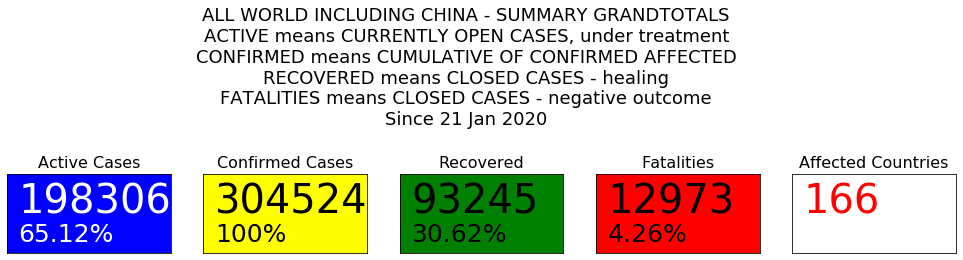

In [10]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'world'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries], num_affected_countries]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries], 0]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities', 'Affected Countries']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red', 'white']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black', 'red']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'ALL WORLD INCLUDING CHINA - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

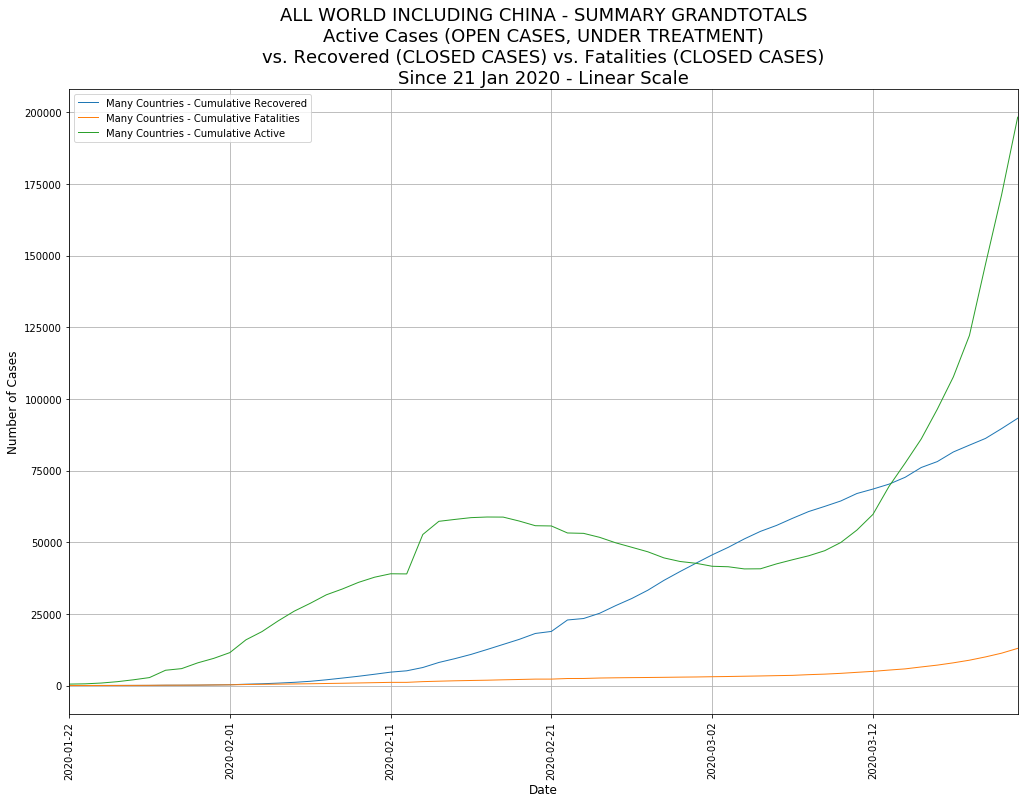

In [11]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - SUMMARY GRANDTOTALS' + \
        '\n' + \
        'Active Cases (OPEN CASES, UNDER TREATMENT)' + \
        '\n' + \
        'vs. Recovered (CLOSED CASES) vs. Fatalities (CLOSED CASES)' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

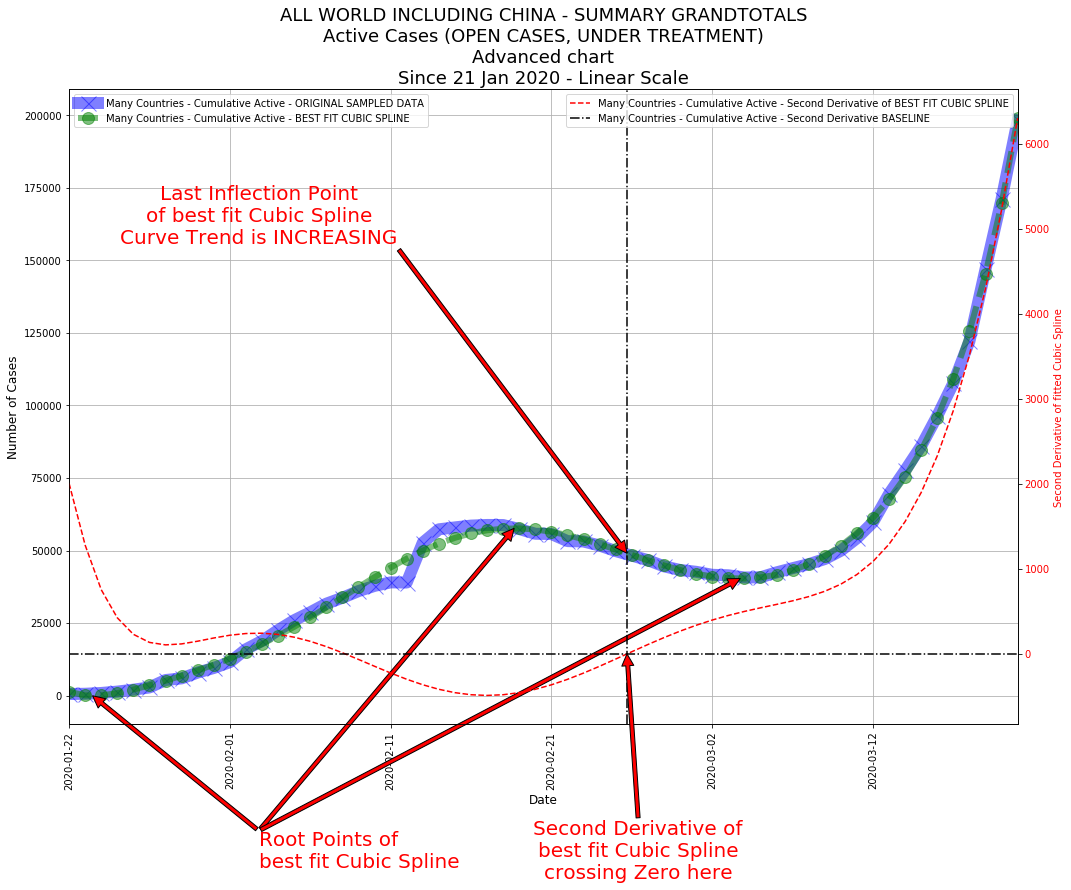

In [12]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - SUMMARY GRANDTOTALS' + \
        '\n' + \
        'Active Cases (OPEN CASES, UNDER TREATMENT)' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

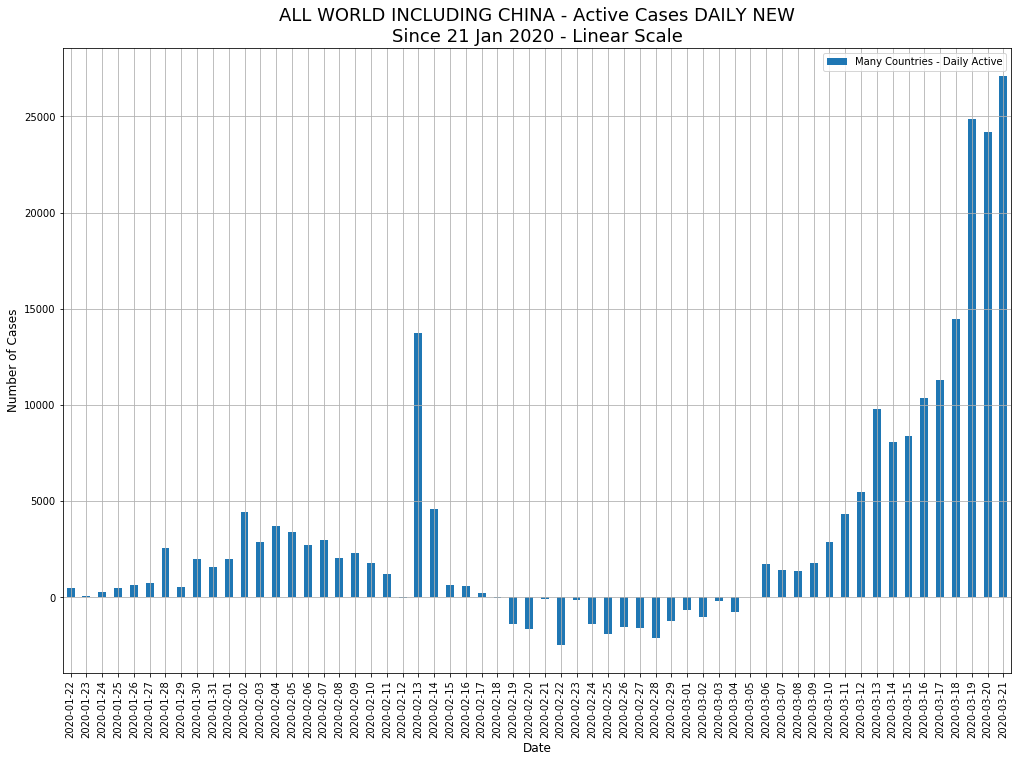

In [13]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Active Cases DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

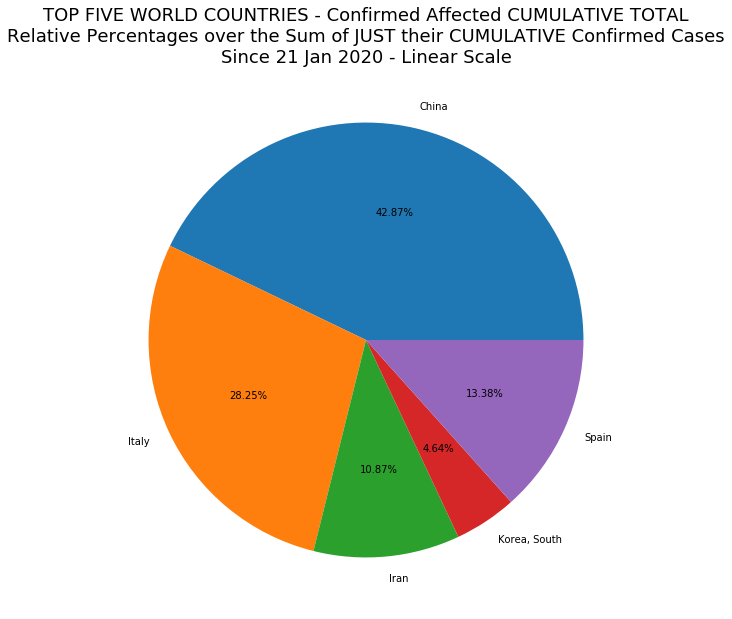

In [14]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_world_confirmed_top5

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP FIVE WORLD COUNTRIES - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Relative Percentages over the Sum of JUST their CUMULATIVE Confirmed Cases' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

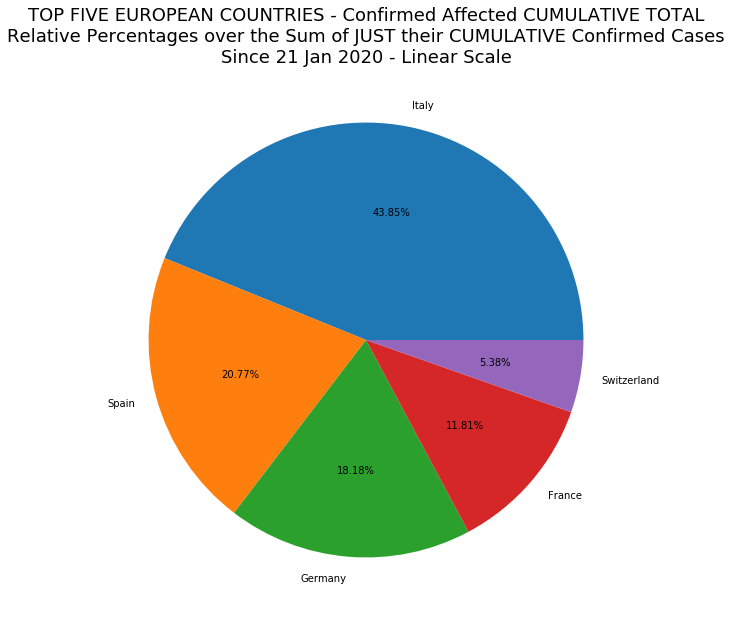

In [15]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_europe_confirmed_top5

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP FIVE EUROPEAN COUNTRIES - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Relative Percentages over the Sum of JUST their CUMULATIVE Confirmed Cases' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

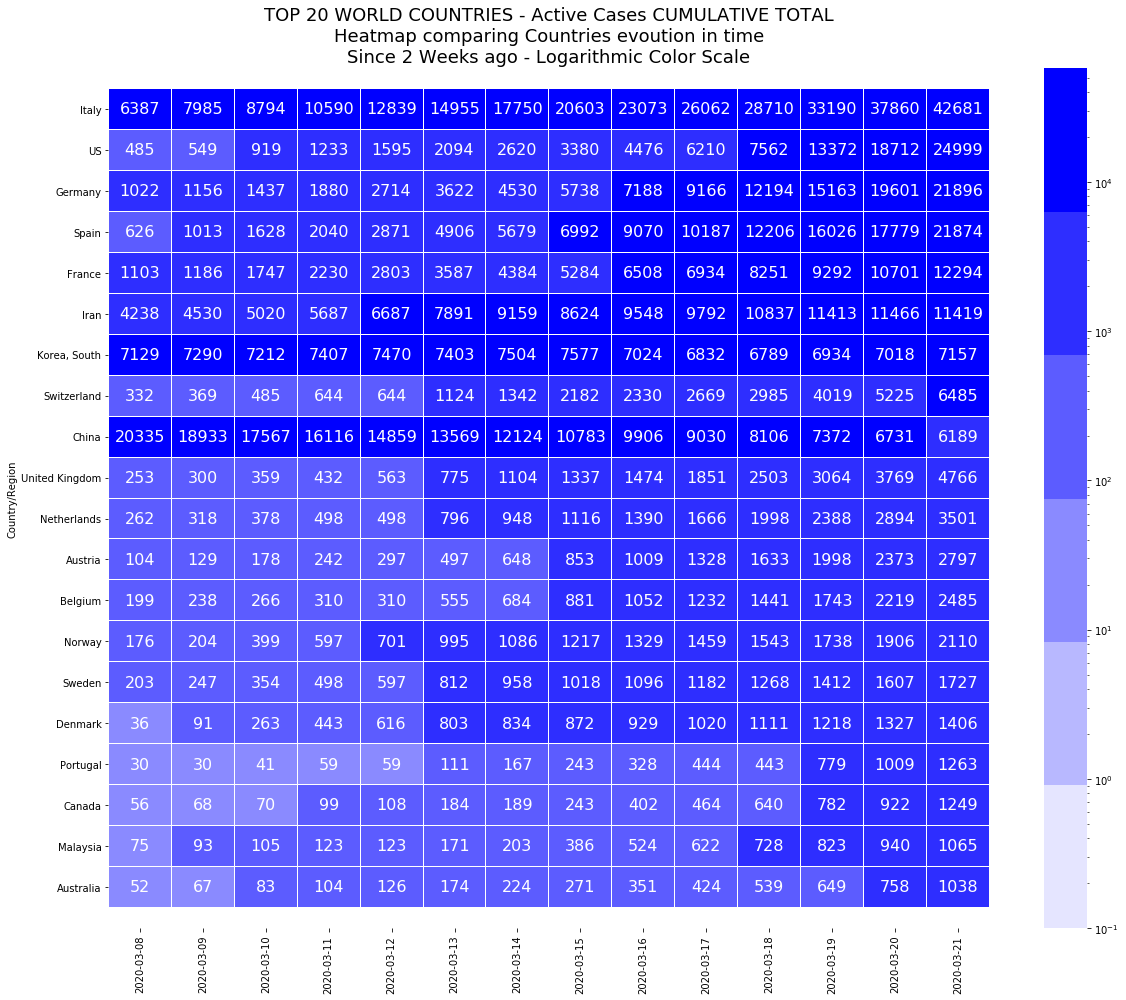

In [16]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF

#dict_of_dataframes['Daily Confirmed Heatmap'] = reduced_confirmed_heatmap_DF
#dict_of_dataframes['Daily Recovered Heatmap'] = reduced_recovered_heatmap_DF
#dict_of_dataframes['Daily Fatalities Heatmap'] = reduced_deaths_heatmap_DF
#dict_of_dataframes['Daily Active Heatmap'] = reduced_active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF

#dict_of_dataframes['Cumulative Confirmed Heatmap'] = confirmed_heatmap_DF
#dict_of_dataframes['Cumulative Recovered Heatmap'] = recovered_heatmap_DF
#dict_of_dataframes['Cumulative Fatalities Heatmap'] = deaths_heatmap_DF
dict_of_dataframes['Cumulative Active Heatmap'] = active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
# - list_of_world_confirmed_top5
# - list_of_europe_confirmed_top5
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# HERE WE DRAW A HEATMAP, THEREFORE THE FORMAT IS NOT 'YYYY-MM-DD'
# INSTEAD WE INDICATE HOW MANY DAYS BACK WE WANT TO GO
start_date = 14 # IN THE CONTEXT OF HEATMAPS, THIS MEANS TO DRAW DATA SINCE X DAYS AGO

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP 20 WORLD COUNTRIES - Active Cases CUMULATIVE TOTAL' + \
        '\n' + \
        'Heatmap comparing Countries evoution in time' + \
        '\n' + \
        'Since 2 Weeks ago - Logarithmic Color Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'log'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 20

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked)

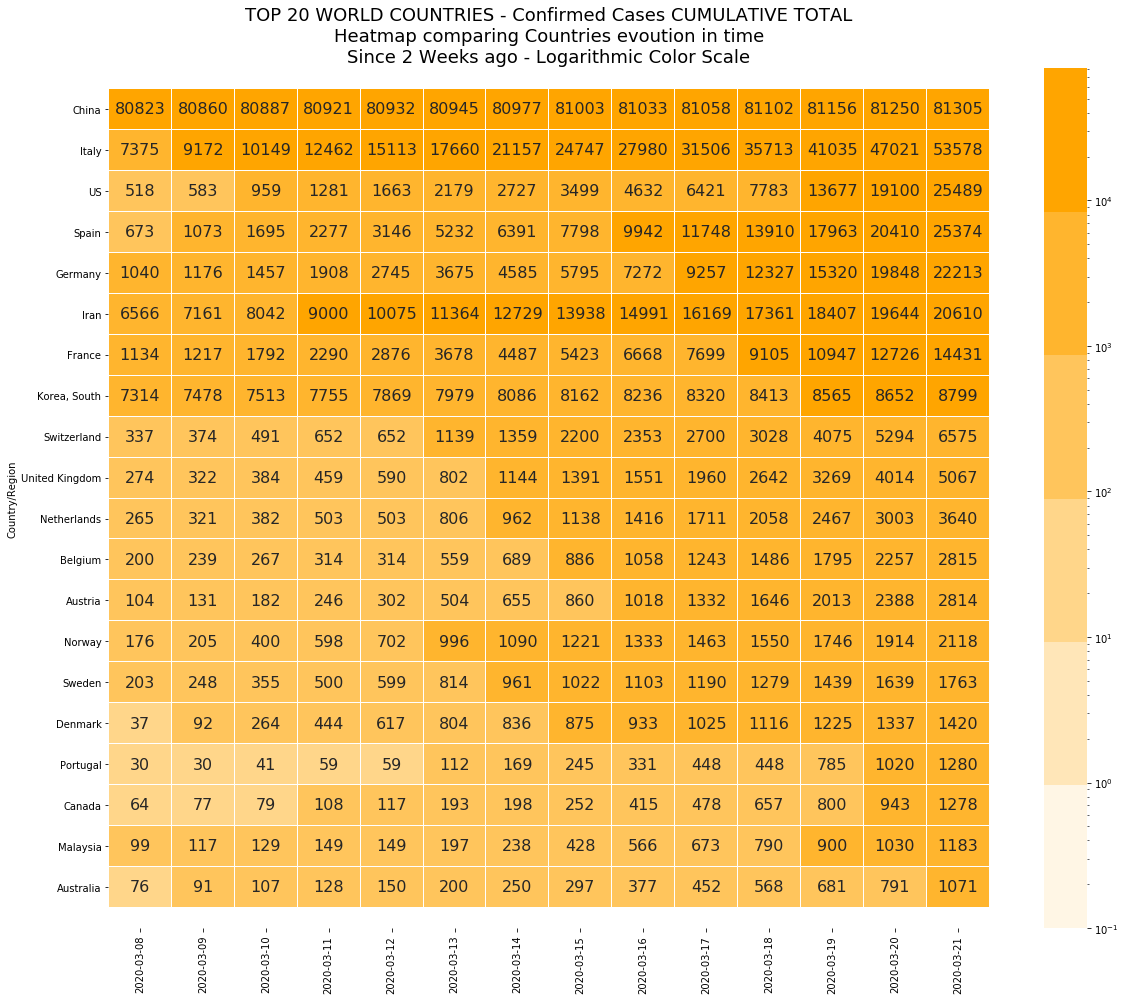

In [17]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF

#dict_of_dataframes['Daily Confirmed Heatmap'] = reduced_confirmed_heatmap_DF
#dict_of_dataframes['Daily Recovered Heatmap'] = reduced_recovered_heatmap_DF
#dict_of_dataframes['Daily Fatalities Heatmap'] = reduced_deaths_heatmap_DF
#dict_of_dataframes['Daily Active Heatmap'] = reduced_active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF

dict_of_dataframes['Cumulative Confirmed Heatmap'] = confirmed_heatmap_DF
#dict_of_dataframes['Cumulative Recovered Heatmap'] = recovered_heatmap_DF
#dict_of_dataframes['Cumulative Fatalities Heatmap'] = deaths_heatmap_DF
#dict_of_dataframes['Cumulative Active Heatmap'] = active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
# - list_of_world_confirmed_top5
# - list_of_europe_confirmed_top5
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# HERE WE DRAW A HEATMAP, THEREFORE THE FORMAT IS NOT 'YYYY-MM-DD'
# INSTEAD WE INDICATE HOW MANY DAYS BACK WE WANT TO GO
start_date = 14 # IN THE CONTEXT OF HEATMAPS, THIS MEANS TO DRAW DATA SINCE X DAYS AGO

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP 20 WORLD COUNTRIES - Confirmed Cases CUMULATIVE TOTAL' + \
        '\n' + \
        'Heatmap comparing Countries evoution in time' + \
        '\n' + \
        'Since 2 Weeks ago - Logarithmic Color Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'log'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 20

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked)

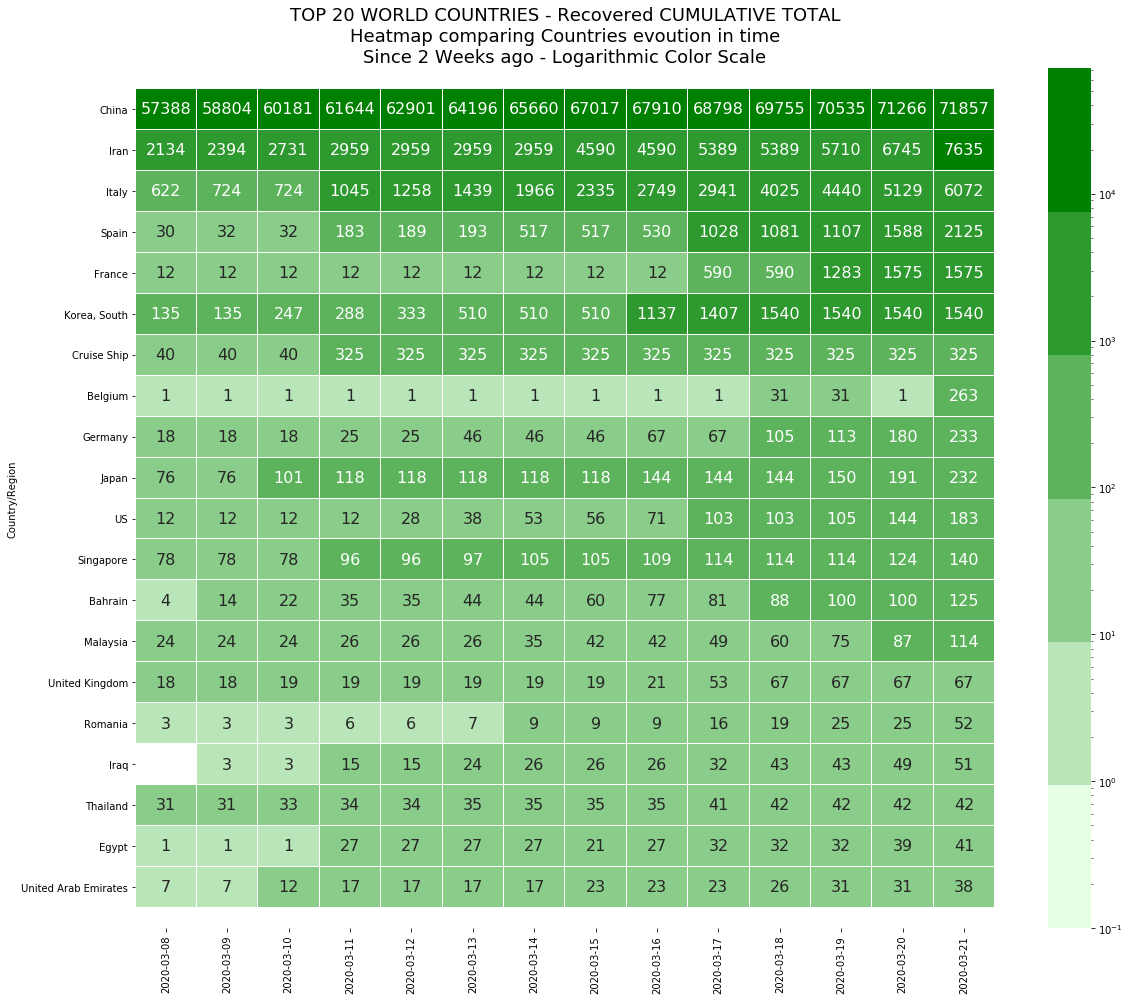

In [18]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF

#dict_of_dataframes['Daily Confirmed Heatmap'] = reduced_confirmed_heatmap_DF
#dict_of_dataframes['Daily Recovered Heatmap'] = reduced_recovered_heatmap_DF
#dict_of_dataframes['Daily Fatalities Heatmap'] = reduced_deaths_heatmap_DF
#dict_of_dataframes['Daily Active Heatmap'] = reduced_active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF

#dict_of_dataframes['Cumulative Confirmed Heatmap'] = confirmed_heatmap_DF
dict_of_dataframes['Cumulative Recovered Heatmap'] = recovered_heatmap_DF
#dict_of_dataframes['Cumulative Fatalities Heatmap'] = deaths_heatmap_DF
#dict_of_dataframes['Cumulative Active Heatmap'] = active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
# - list_of_world_confirmed_top5
# - list_of_europe_confirmed_top5
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# HERE WE DRAW A HEATMAP, THEREFORE THE FORMAT IS NOT 'YYYY-MM-DD'
# INSTEAD WE INDICATE HOW MANY DAYS BACK WE WANT TO GO
start_date = 14 # IN THE CONTEXT OF HEATMAPS, THIS MEANS TO DRAW DATA SINCE X DAYS AGO

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP 20 WORLD COUNTRIES - Recovered CUMULATIVE TOTAL' + \
        '\n' + \
        'Heatmap comparing Countries evoution in time' + \
        '\n' + \
        'Since 2 Weeks ago - Logarithmic Color Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'log'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 20

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked)

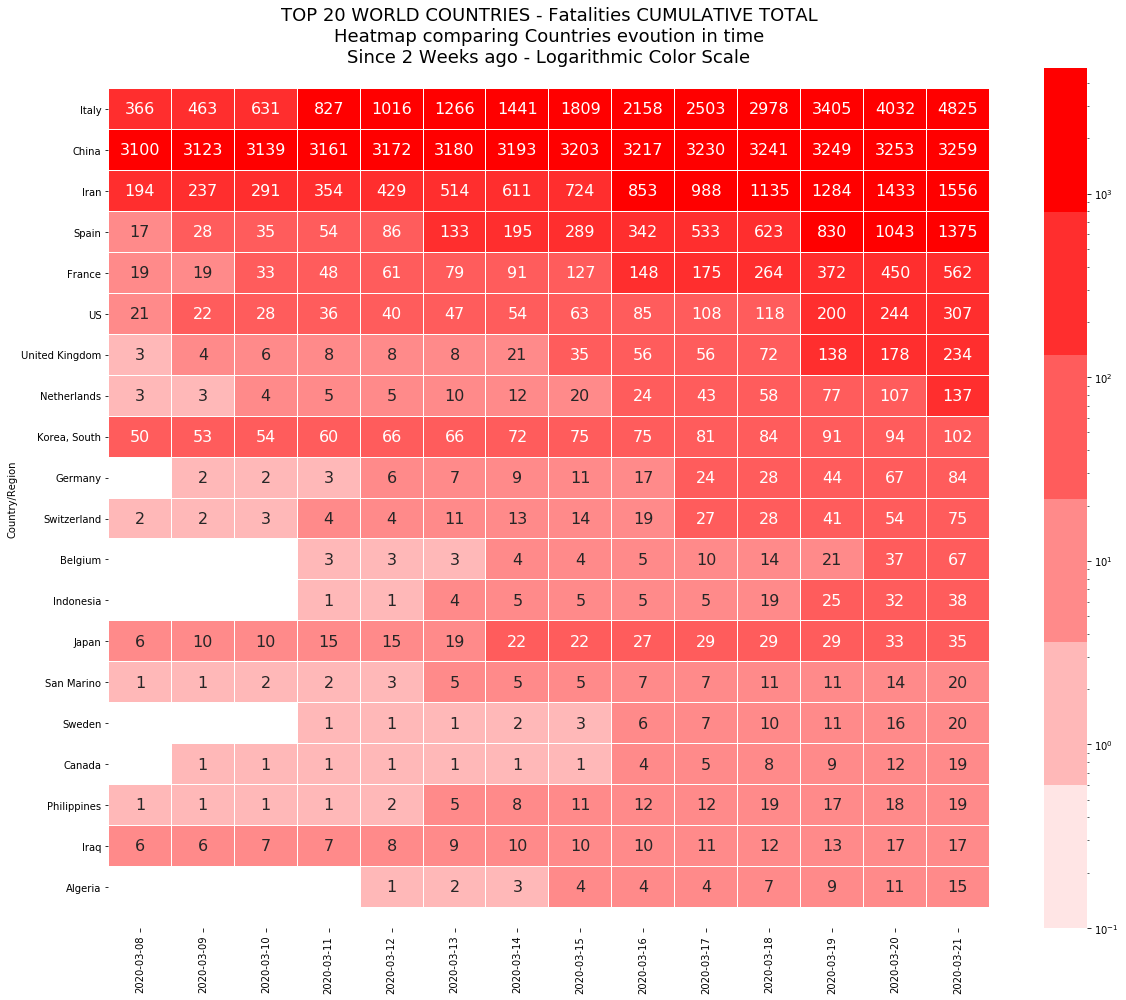

In [19]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF

#dict_of_dataframes['Daily Confirmed Heatmap'] = reduced_confirmed_heatmap_DF
#dict_of_dataframes['Daily Recovered Heatmap'] = reduced_recovered_heatmap_DF
#dict_of_dataframes['Daily Fatalities Heatmap'] = reduced_deaths_heatmap_DF
#dict_of_dataframes['Daily Active Heatmap'] = reduced_active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF

#dict_of_dataframes['Cumulative Confirmed Heatmap'] = confirmed_heatmap_DF
#dict_of_dataframes['Cumulative Recovered Heatmap'] = recovered_heatmap_DF
dict_of_dataframes['Cumulative Fatalities Heatmap'] = deaths_heatmap_DF
#dict_of_dataframes['Cumulative Active Heatmap'] = active_heatmap_DF

#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
# - list_of_world_confirmed_top5
# - list_of_europe_confirmed_top5
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = 14 # IN THE CONTEXT OF HEATMAPS, THIS MEANS TO DRAW DATA SINCE X DAYS AGO

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'TOP 20 WORLD COUNTRIES - Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Heatmap comparing Countries evoution in time' + \
        '\n' + \
        'Since 2 Weeks ago - Logarithmic Color Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'log'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# PIE CHATYS ARE A SPECIAL CASE AS THEY AGGREGATE MORE COUNTRIES IN A SINGLE CHART BY
# DEFINITION, SO THEY NEED THIS FLAG TO BE SET TO "Y"
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 20

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked)

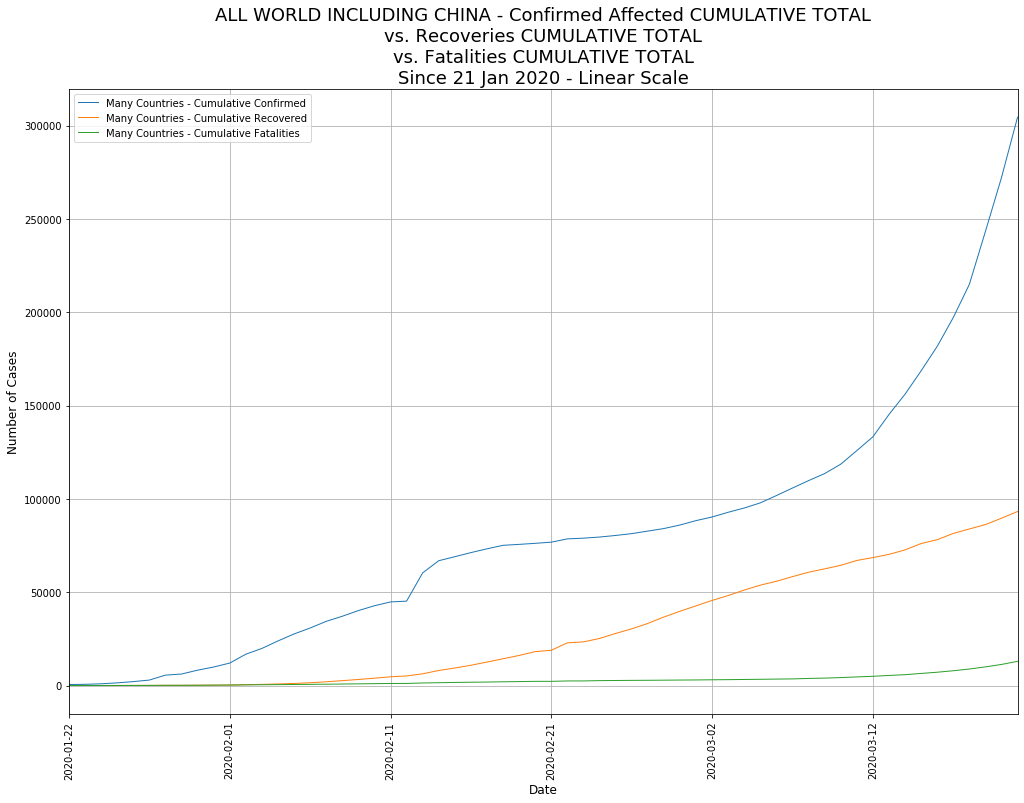

In [20]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

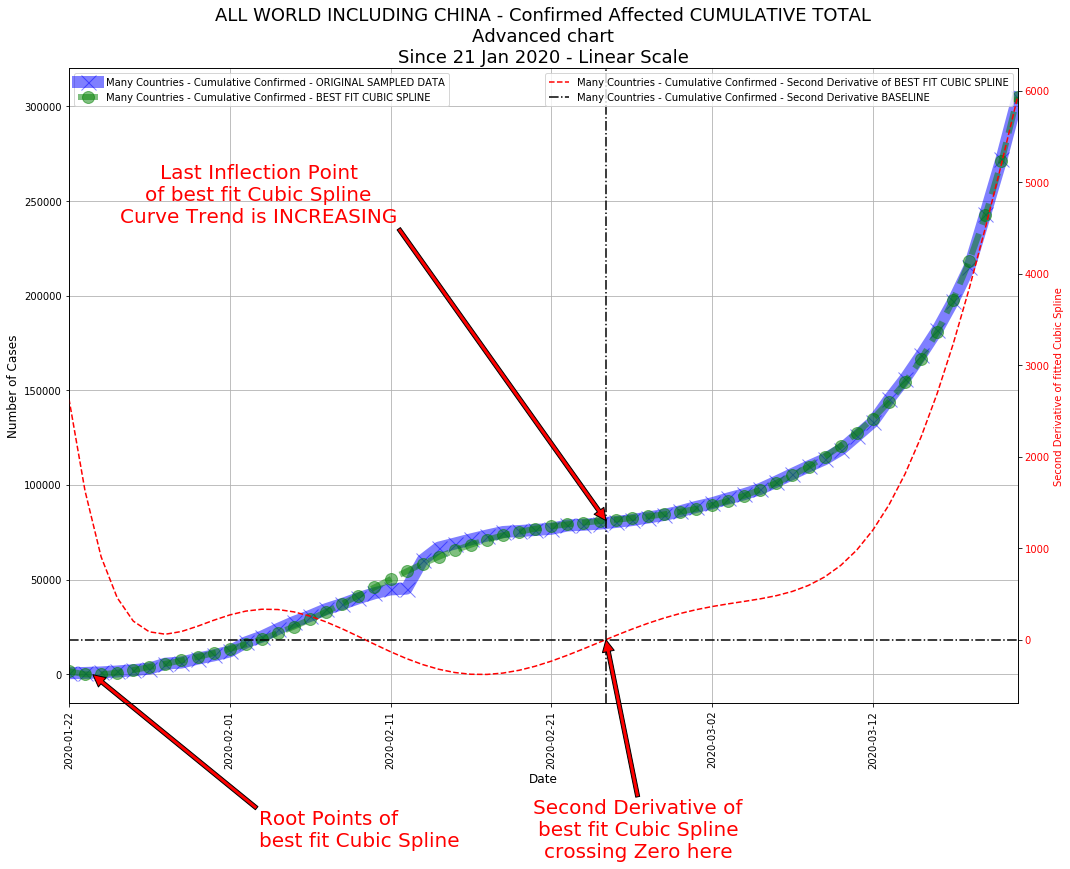

In [21]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

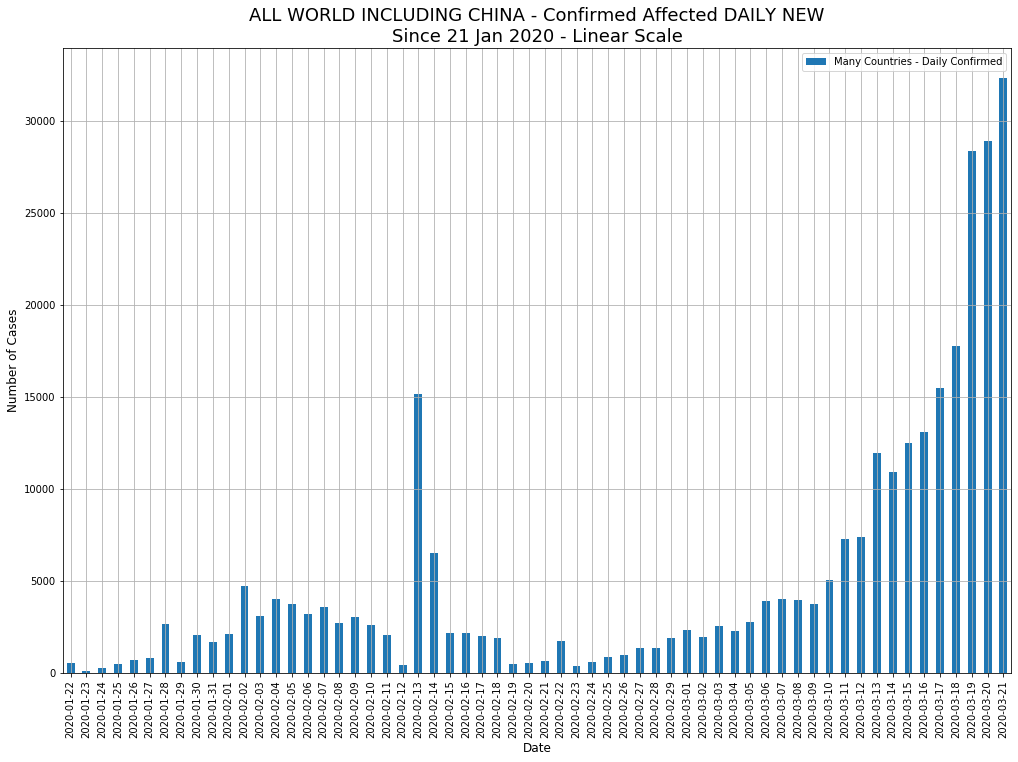

In [22]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

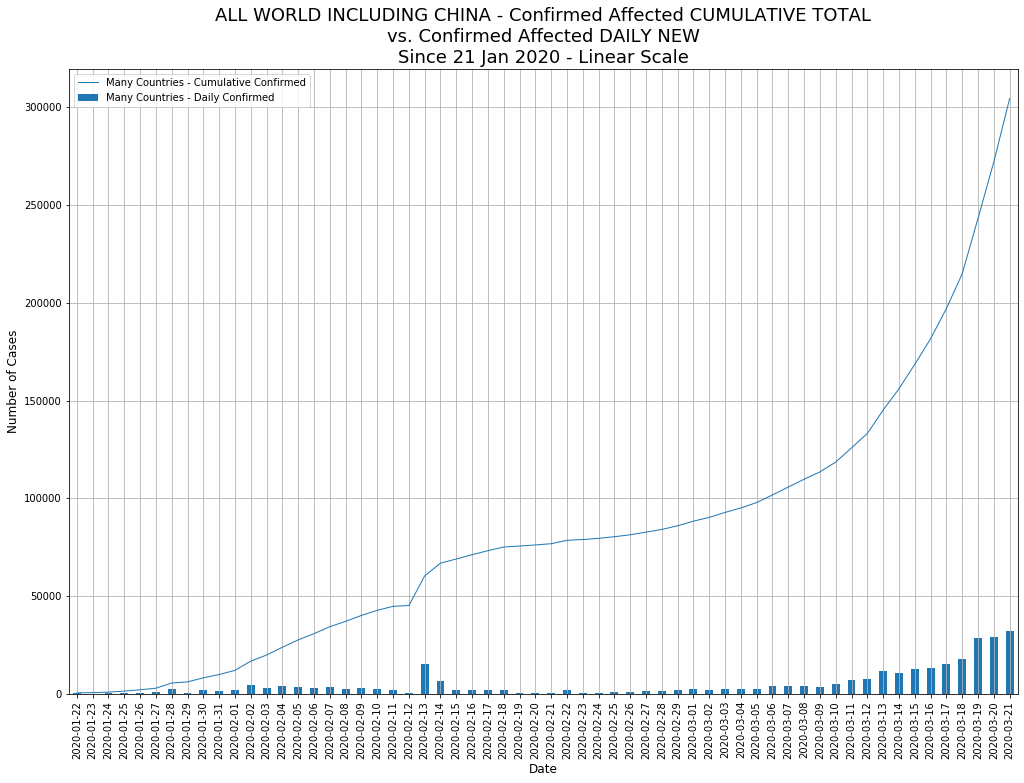

In [23]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

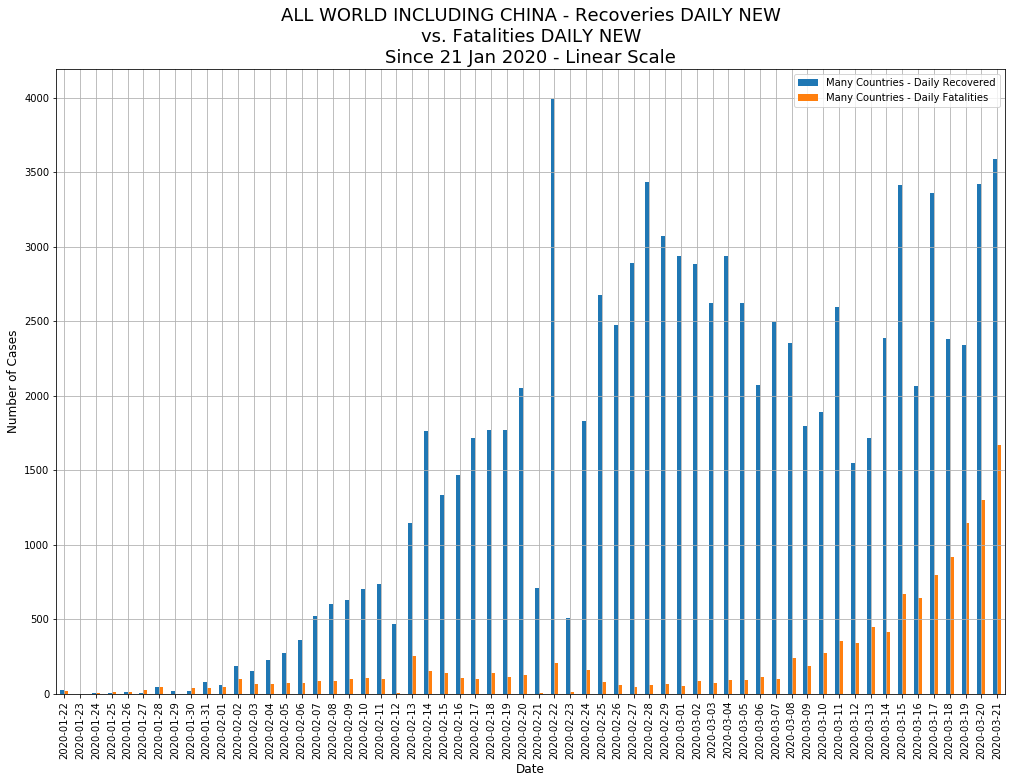

In [24]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ALL WORLD INCLUDING CHINA - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

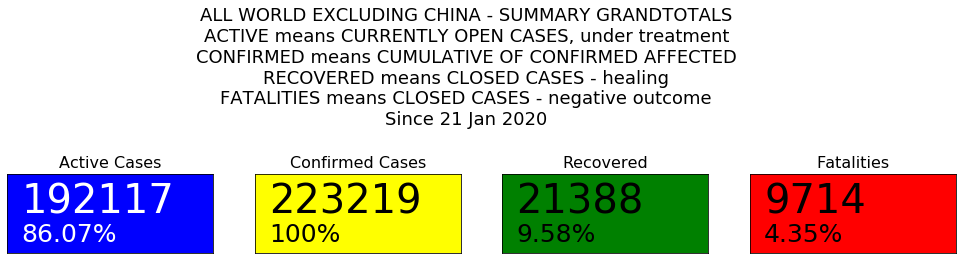

In [25]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'world_nochina'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'ALL WORLD EXCLUDING CHINA - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

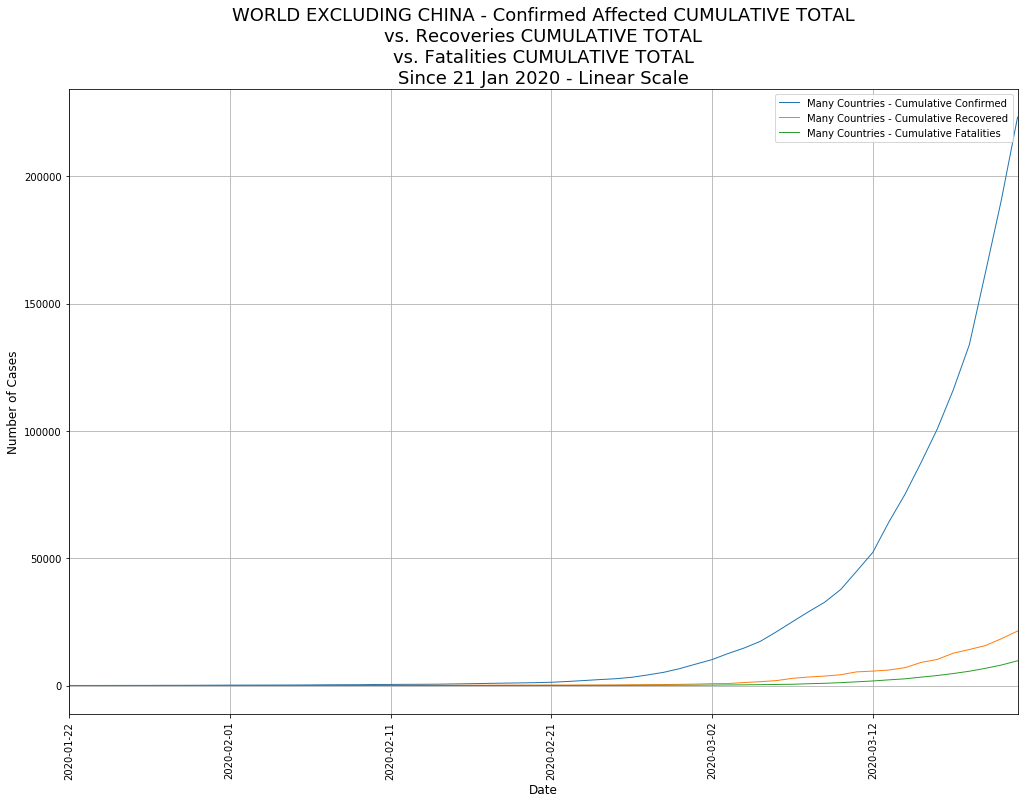

In [26]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

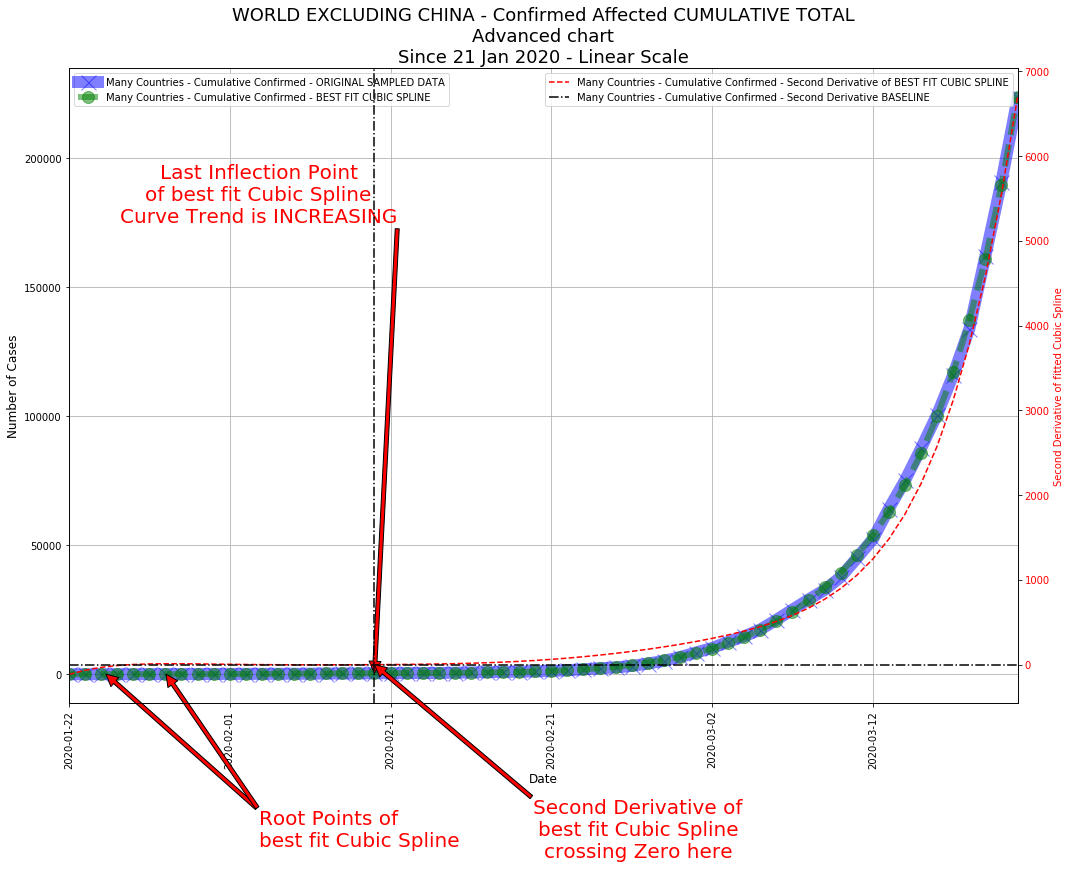

In [27]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

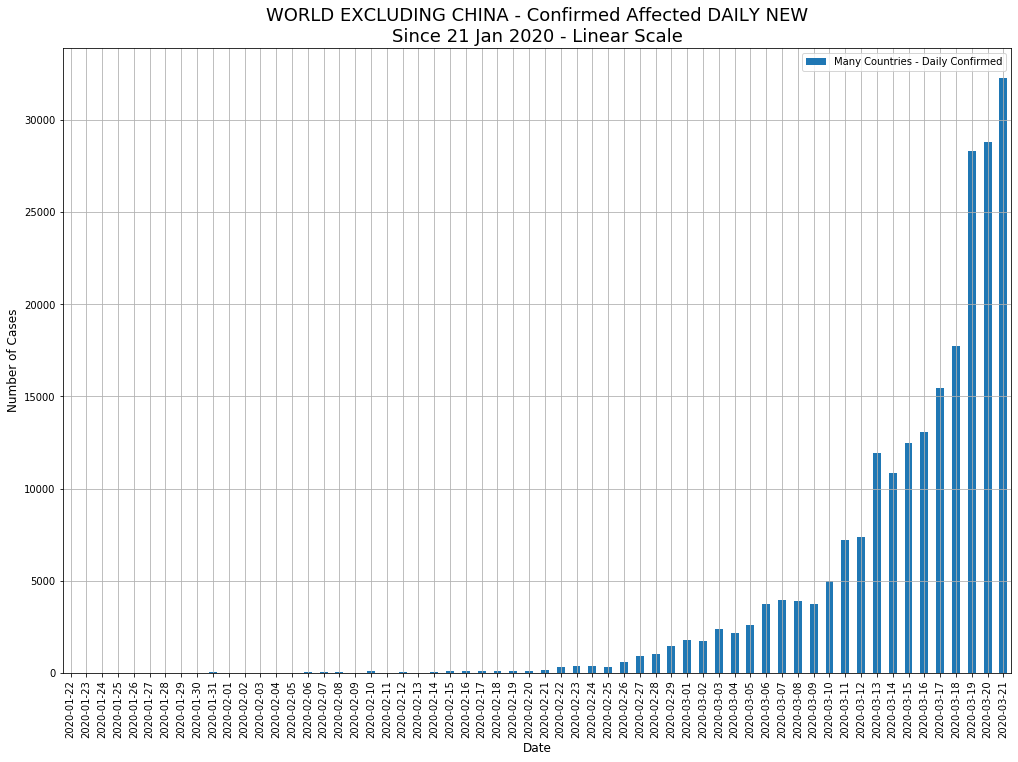

In [28]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

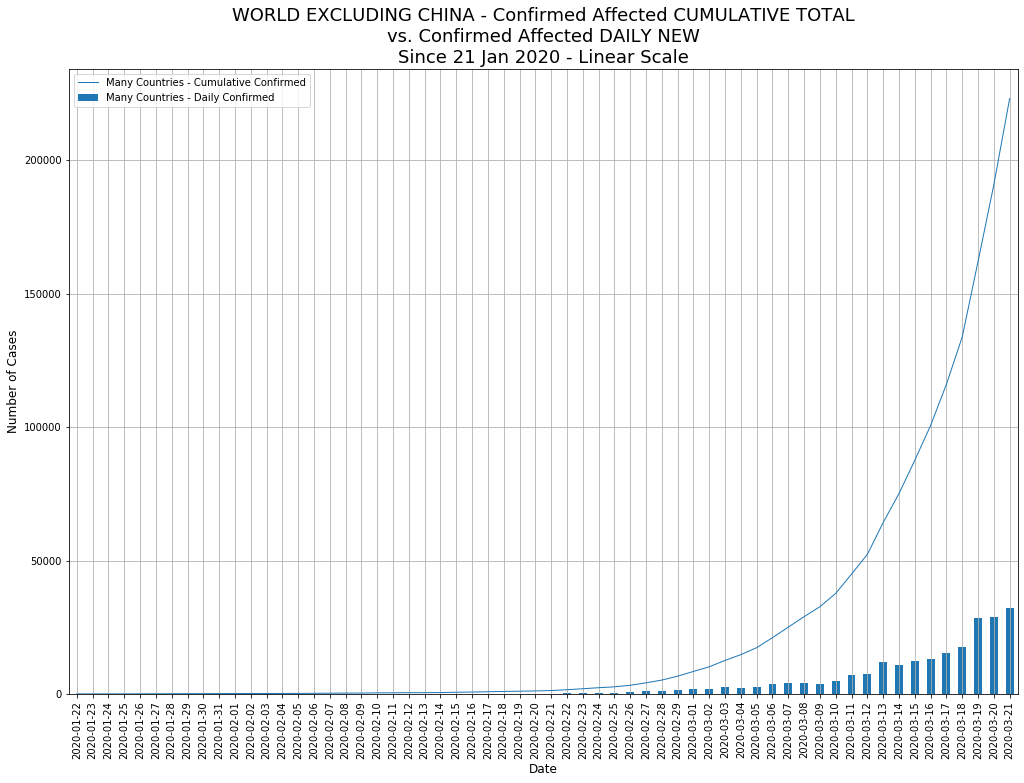

In [29]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

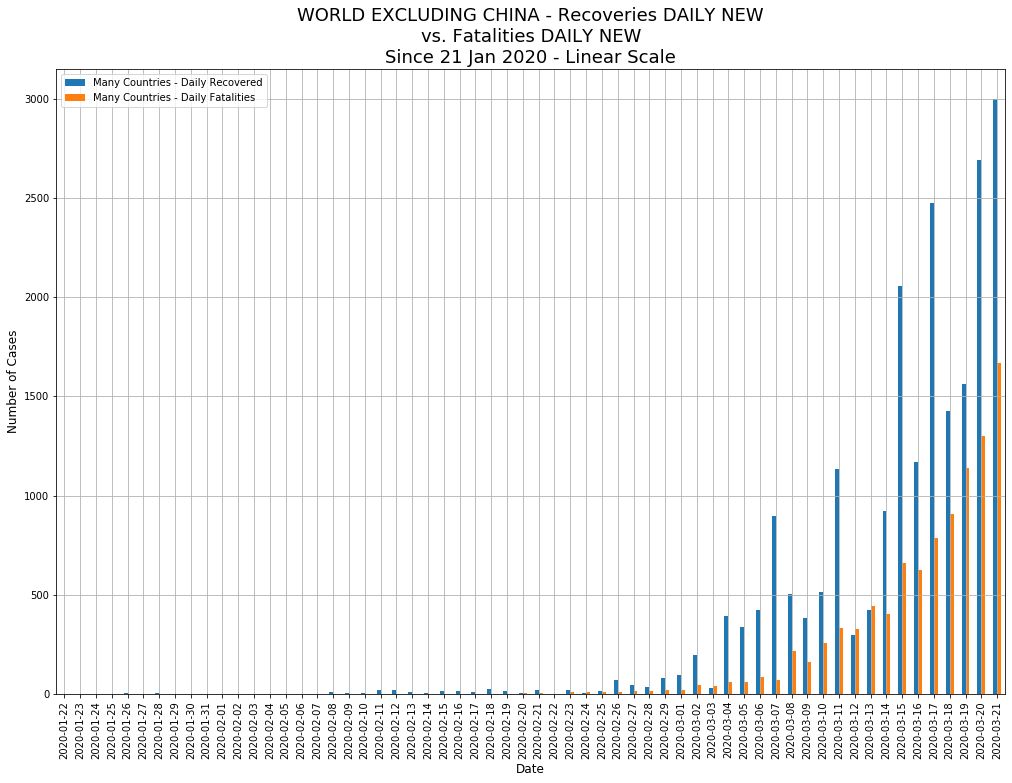

In [30]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_world_nochina

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'WORLD EXCLUDING CHINA - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

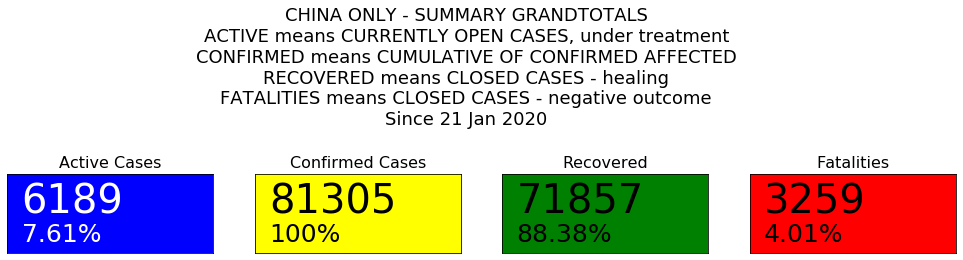

In [31]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'China'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'CHINA ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

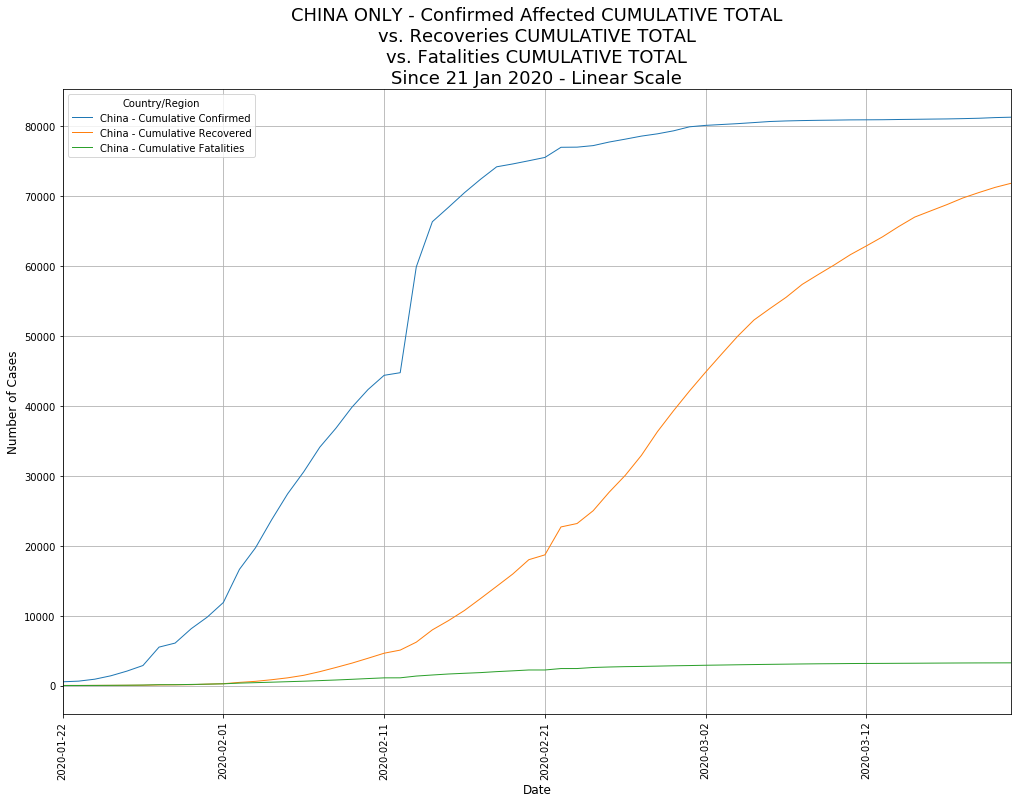

In [32]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

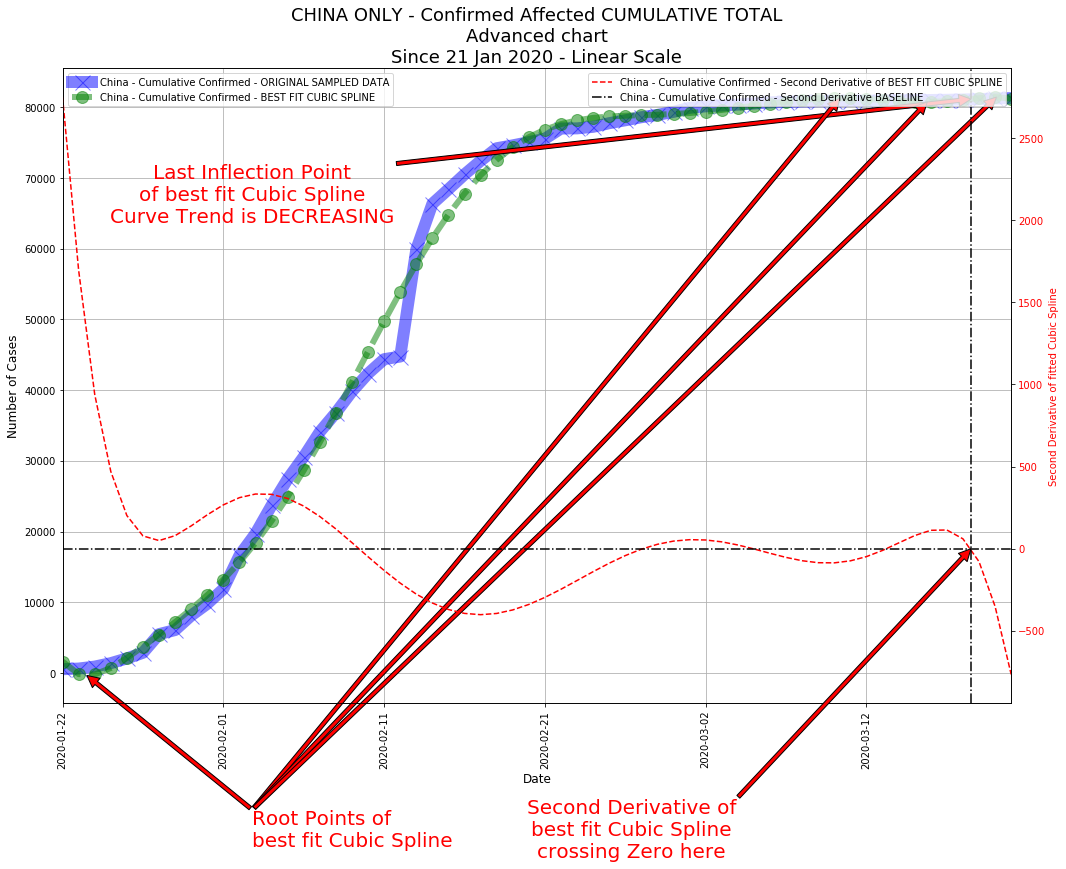

In [33]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

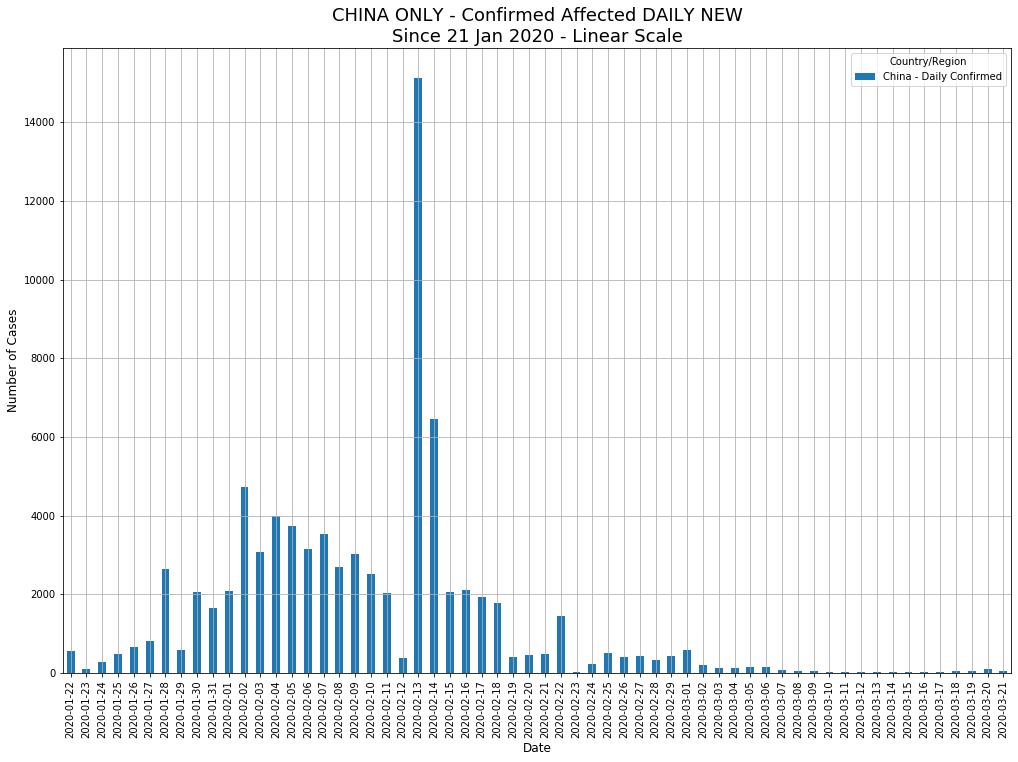

In [34]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

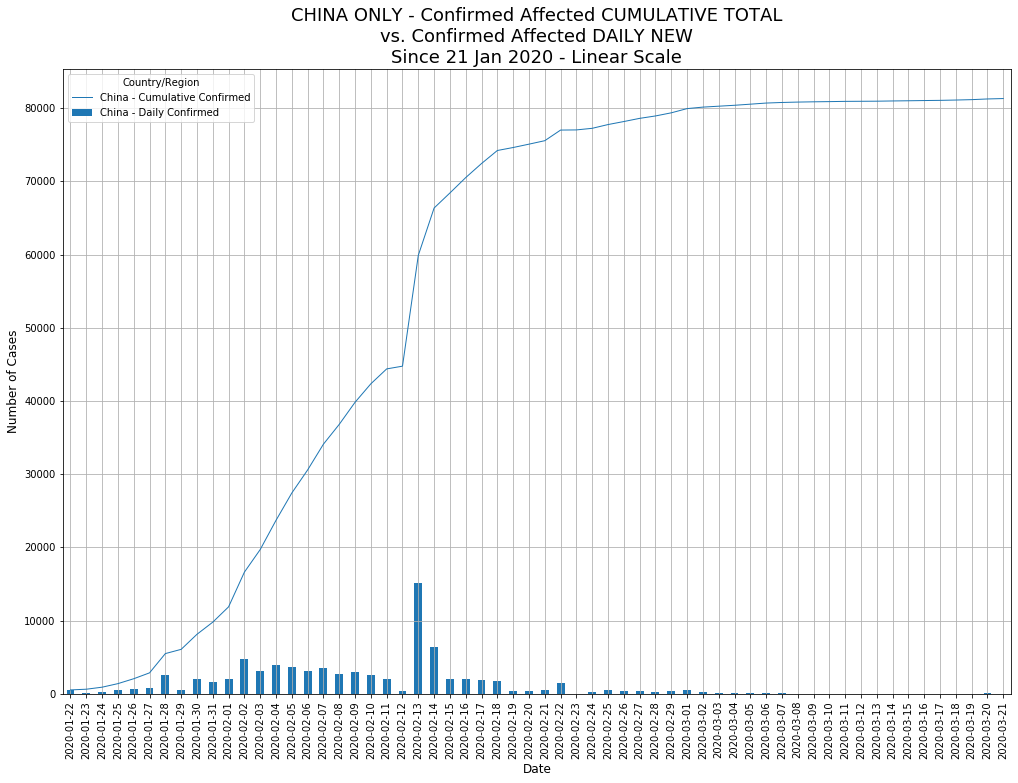

In [35]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

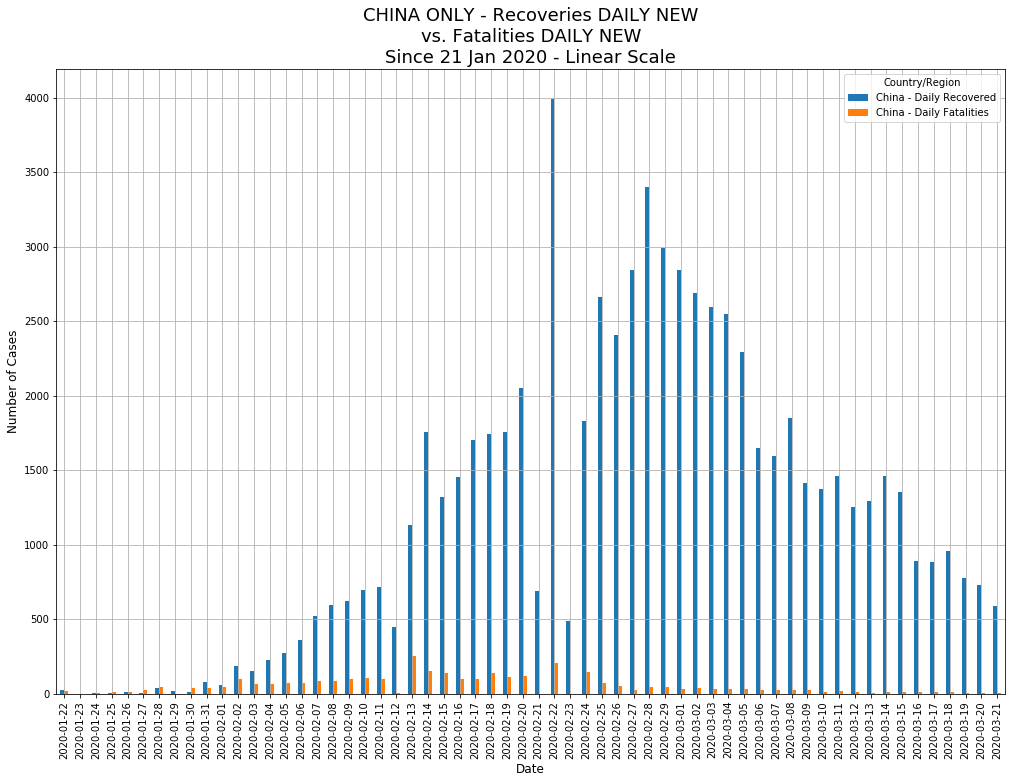

In [36]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['China']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'CHINA ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

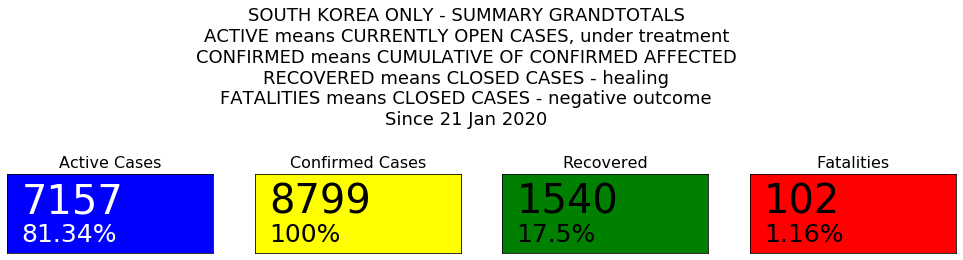

In [37]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'Korea, South'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'SOUTH KOREA ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

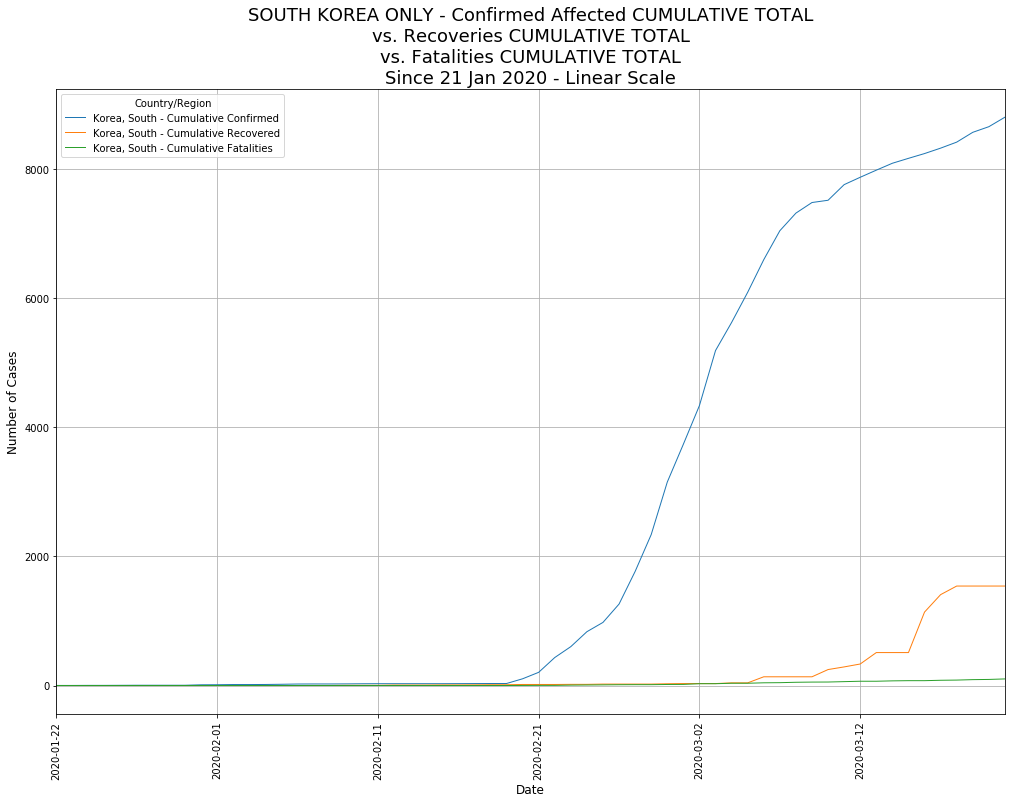

In [38]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Korea, South']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

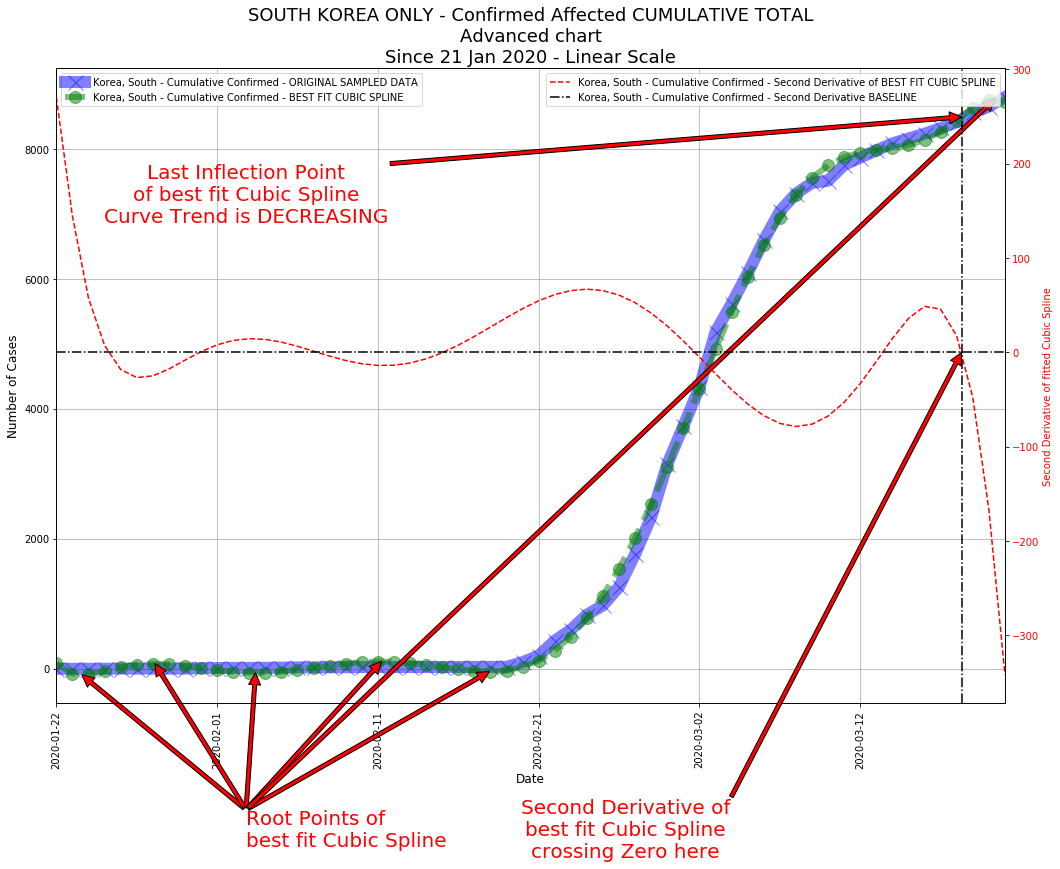

In [39]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Korea, South']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

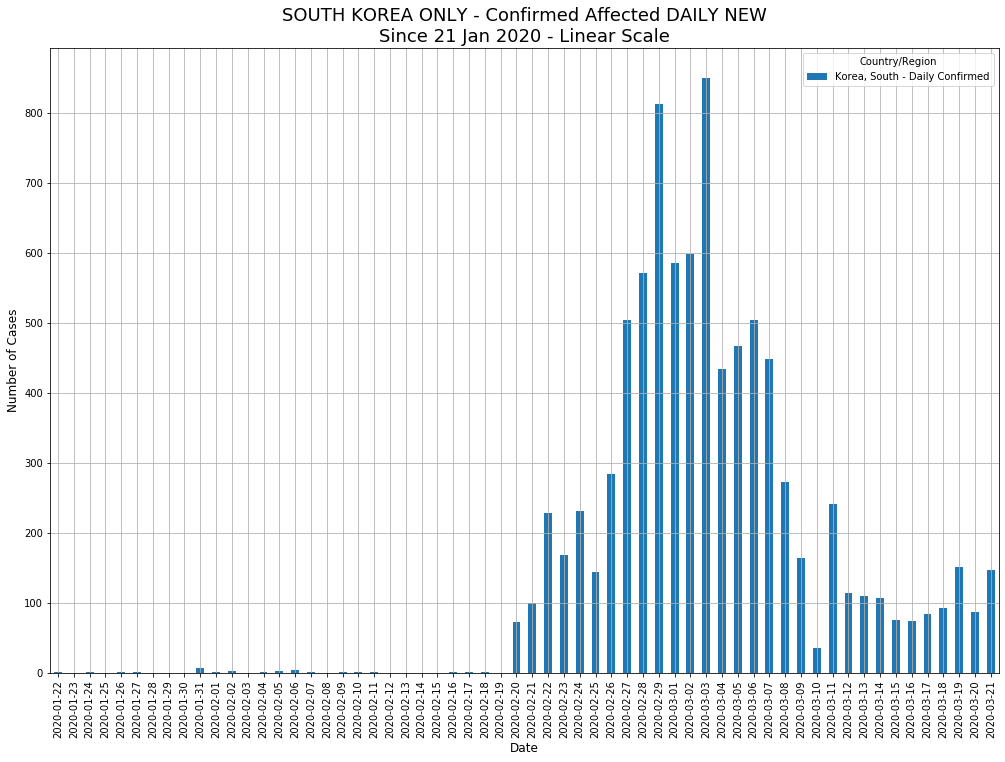

In [40]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Korea, South']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

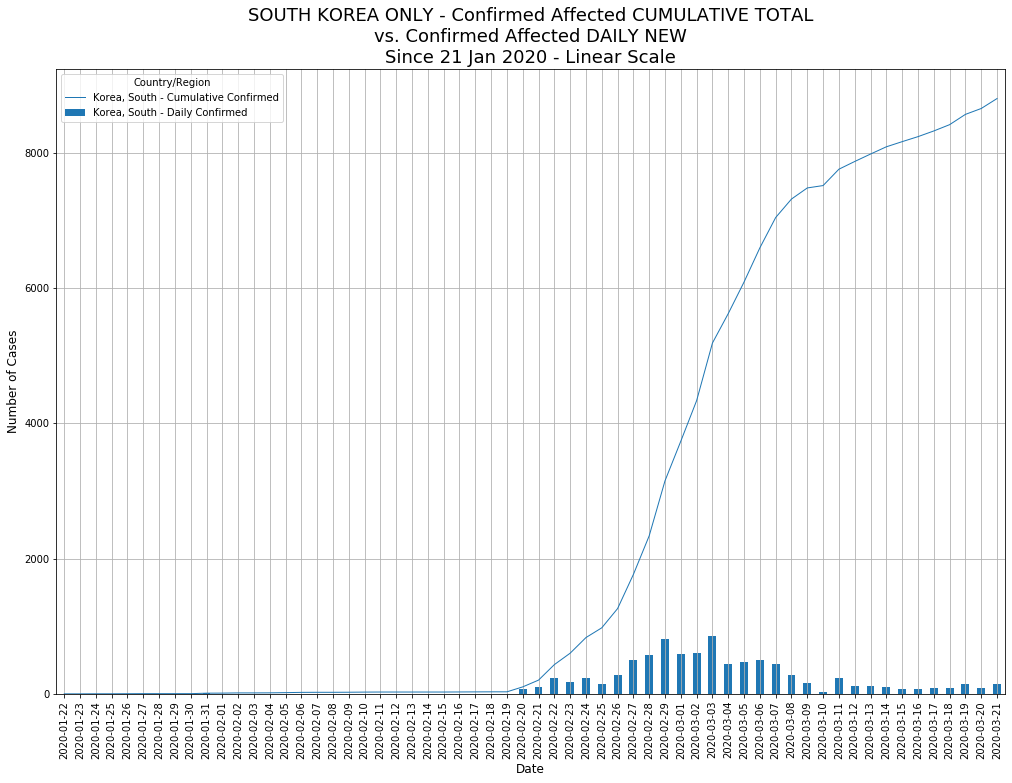

In [41]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Korea, South']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

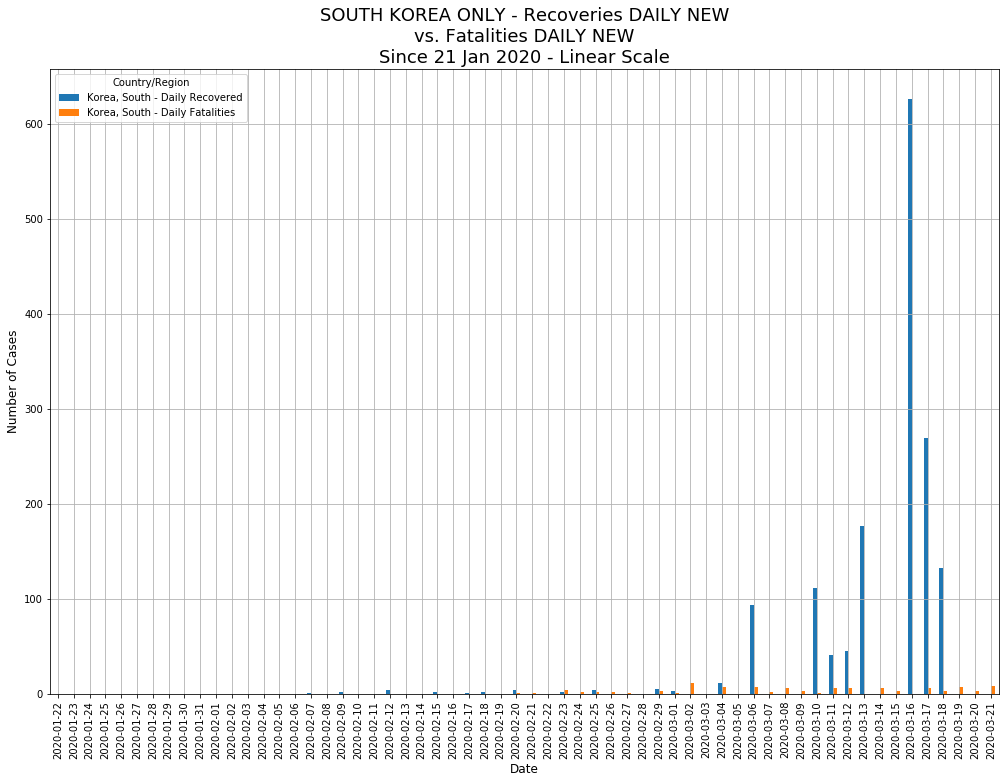

In [42]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Korea, South']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-01-21'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SOUTH KOREA ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 21 Jan 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

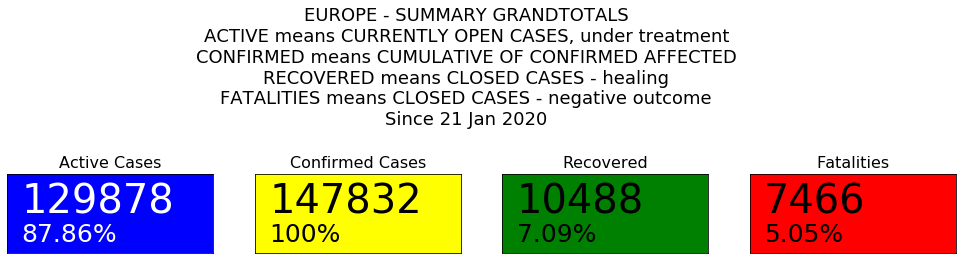

In [43]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'europe'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'EUROPE - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

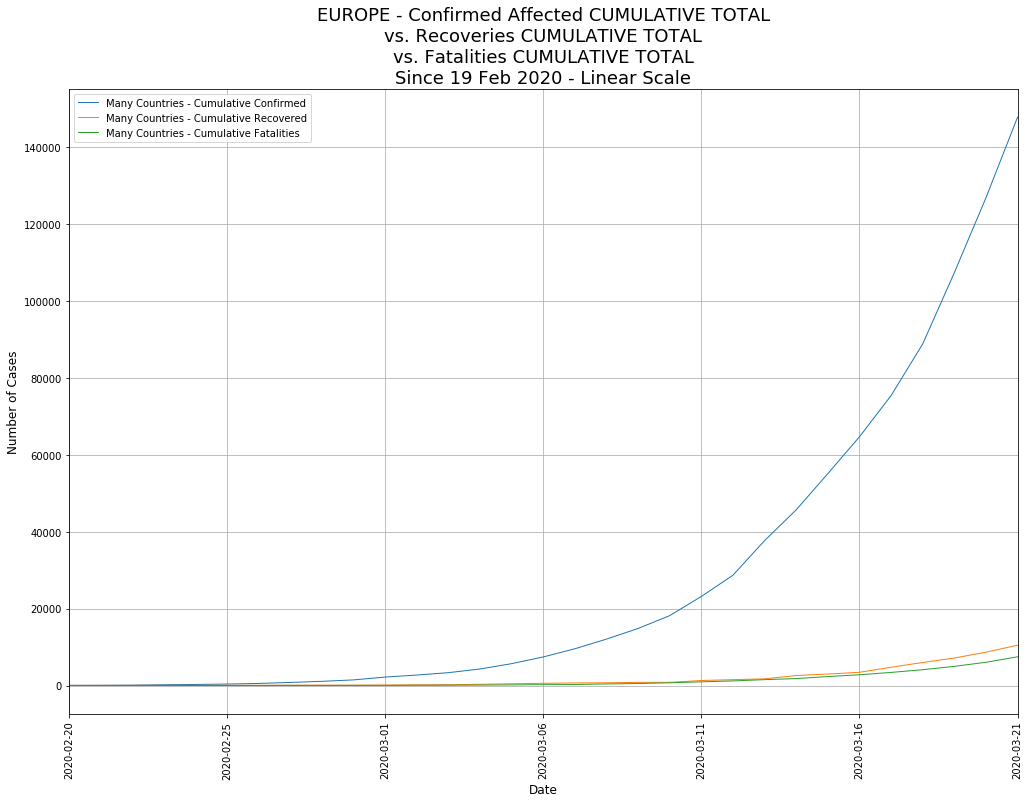

In [44]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

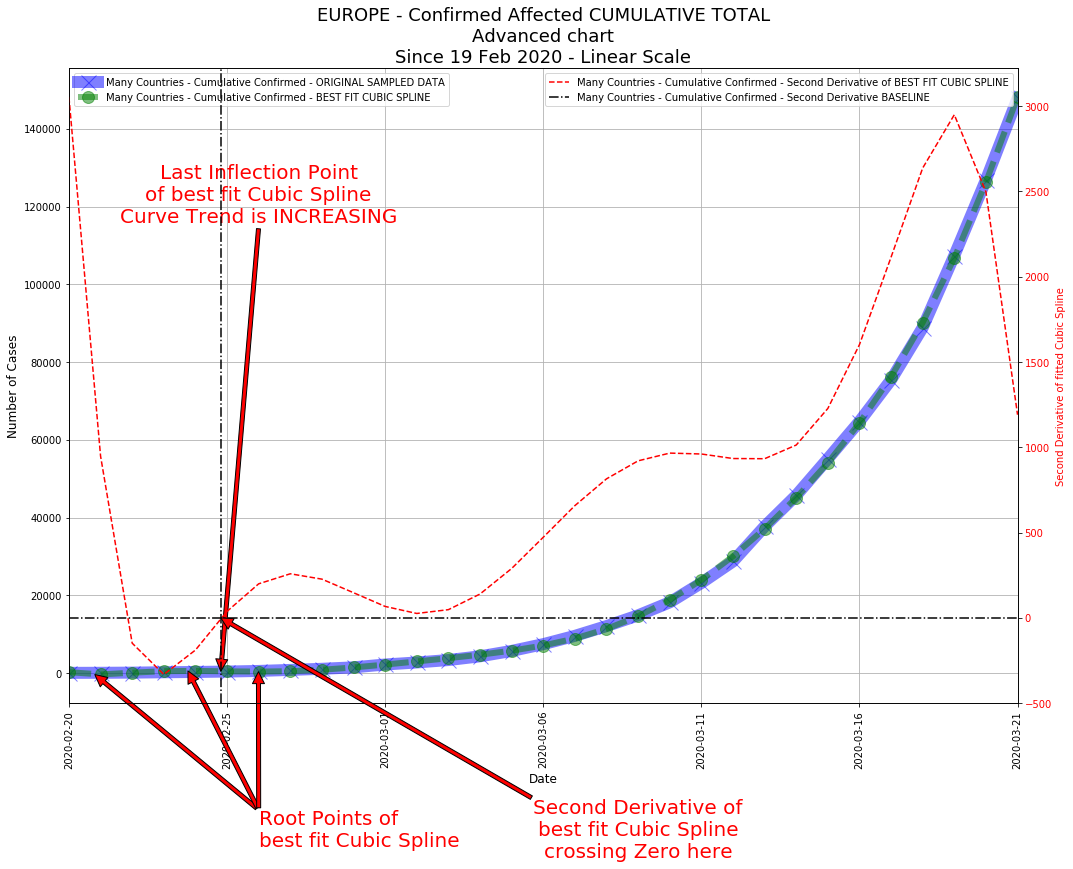

In [45]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

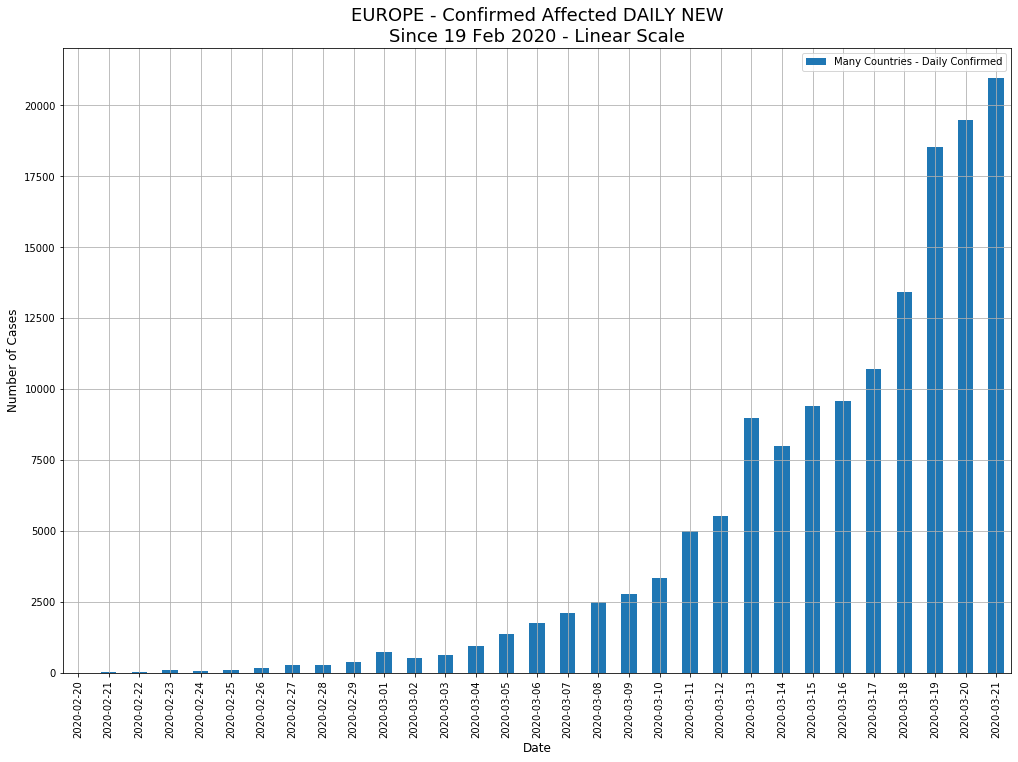

In [46]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

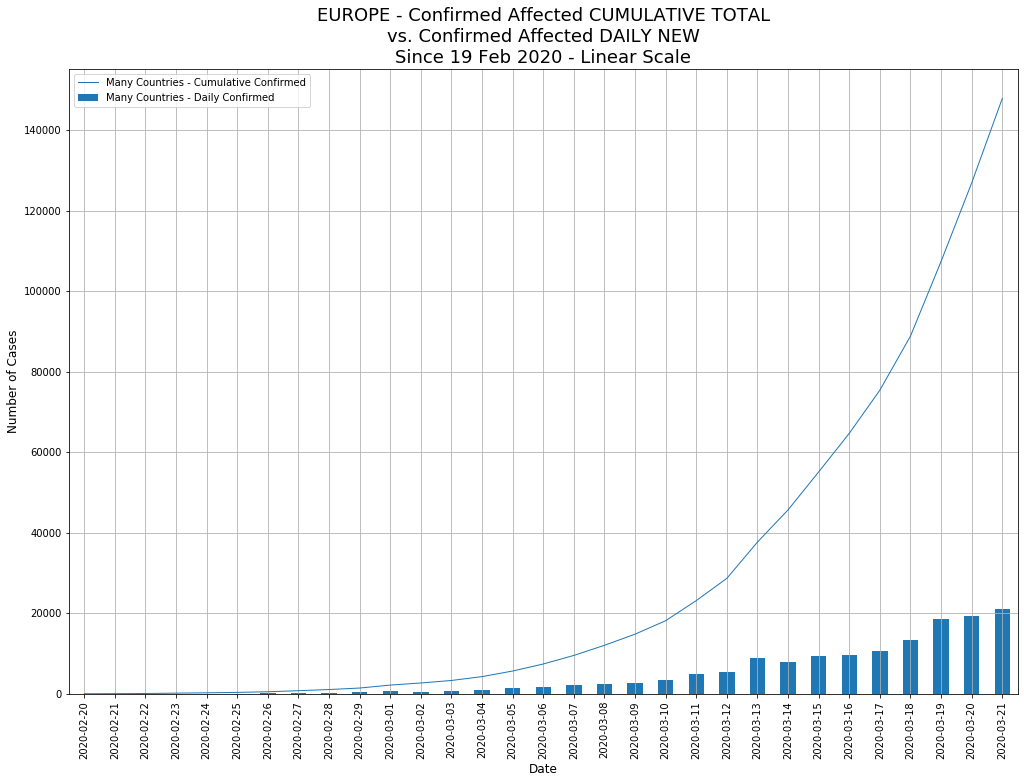

In [47]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

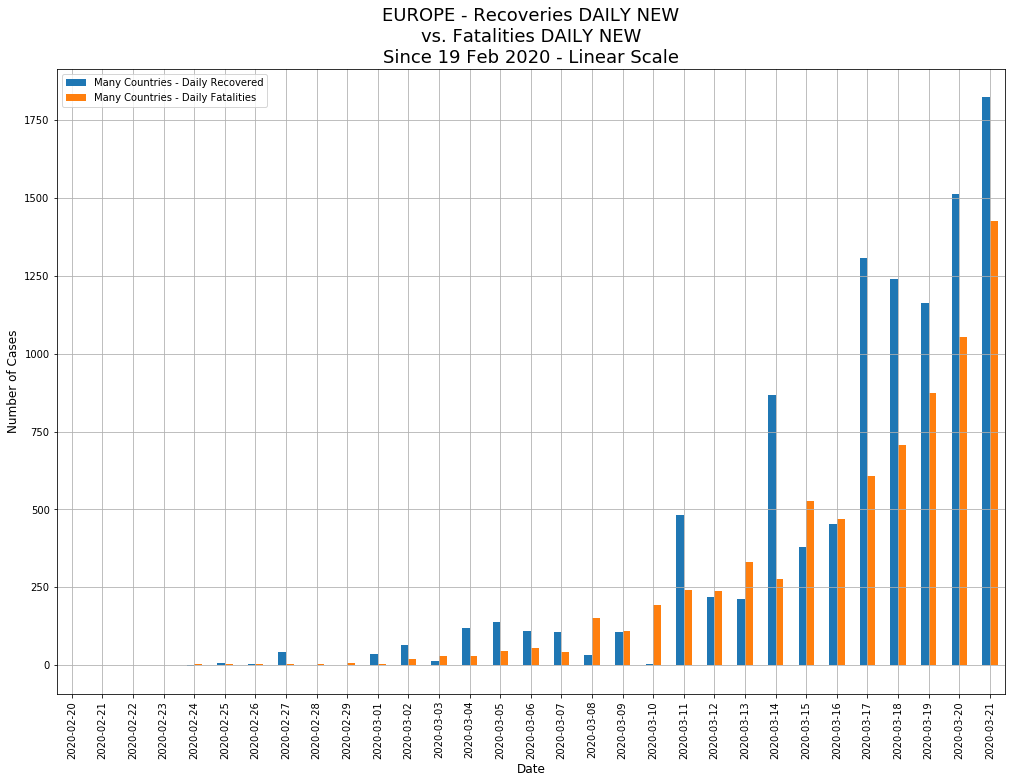

In [48]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPE - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

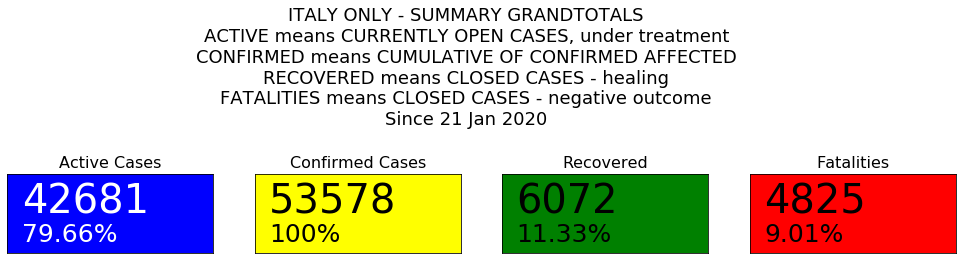

In [49]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'Italy'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'ITALY ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

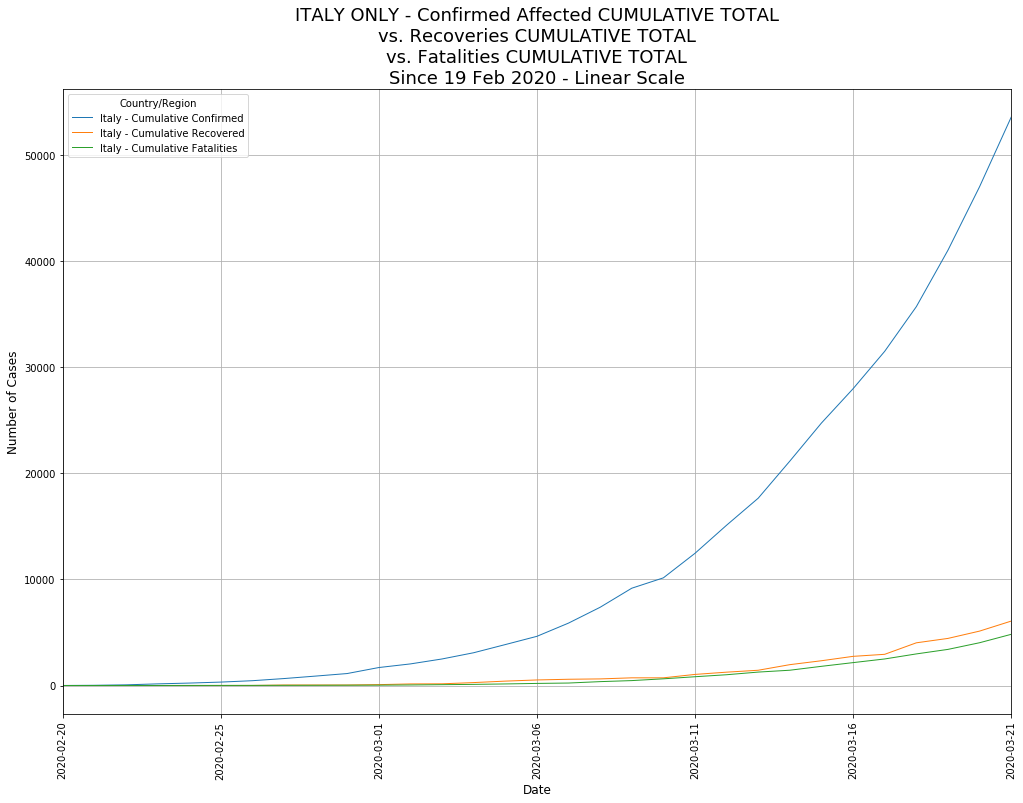

In [50]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

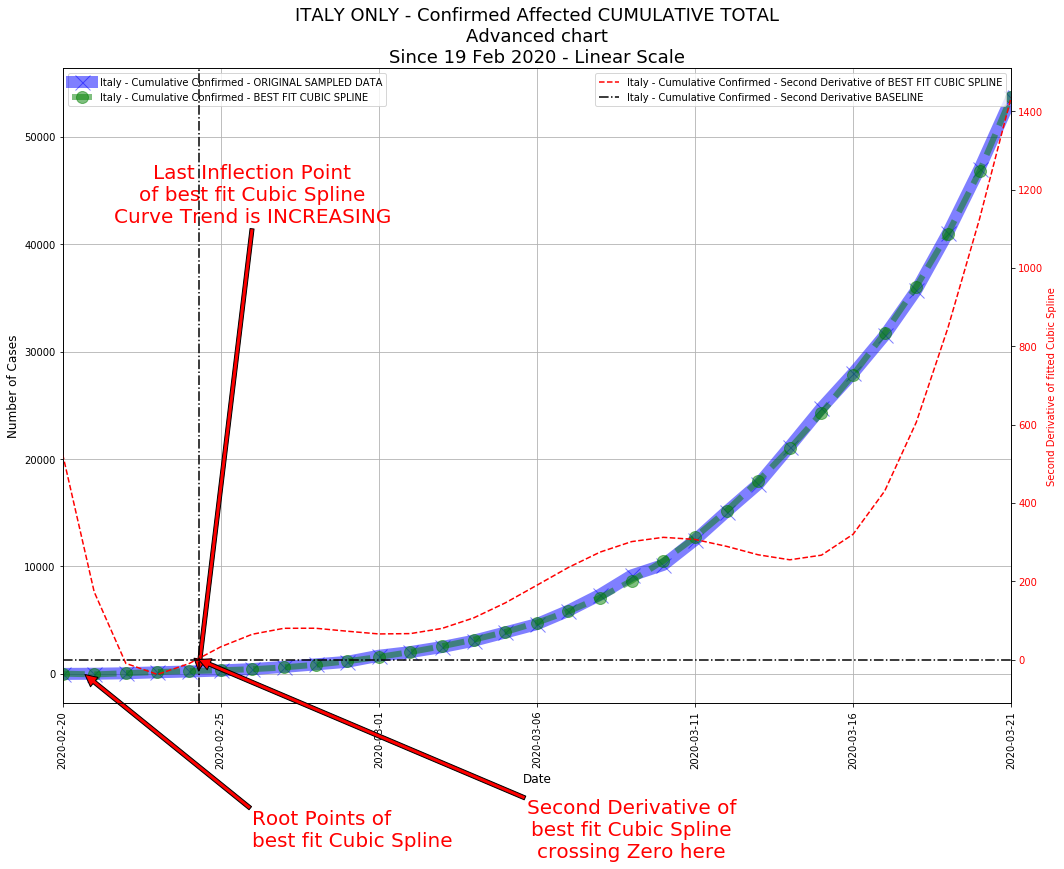

In [51]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

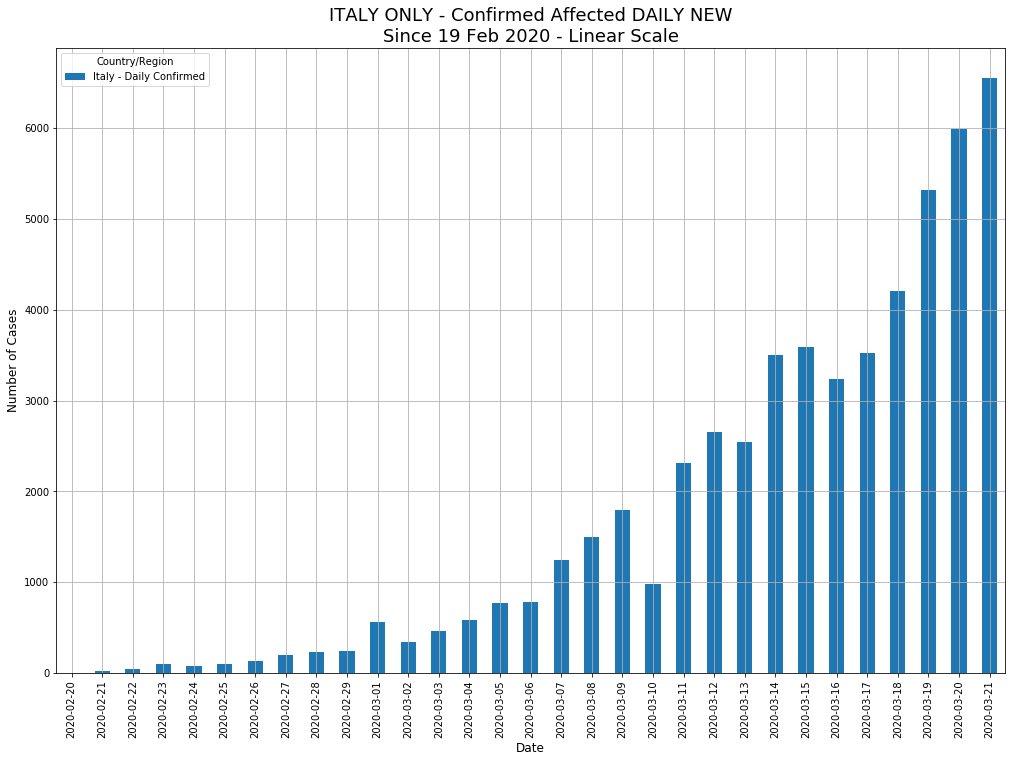

In [52]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

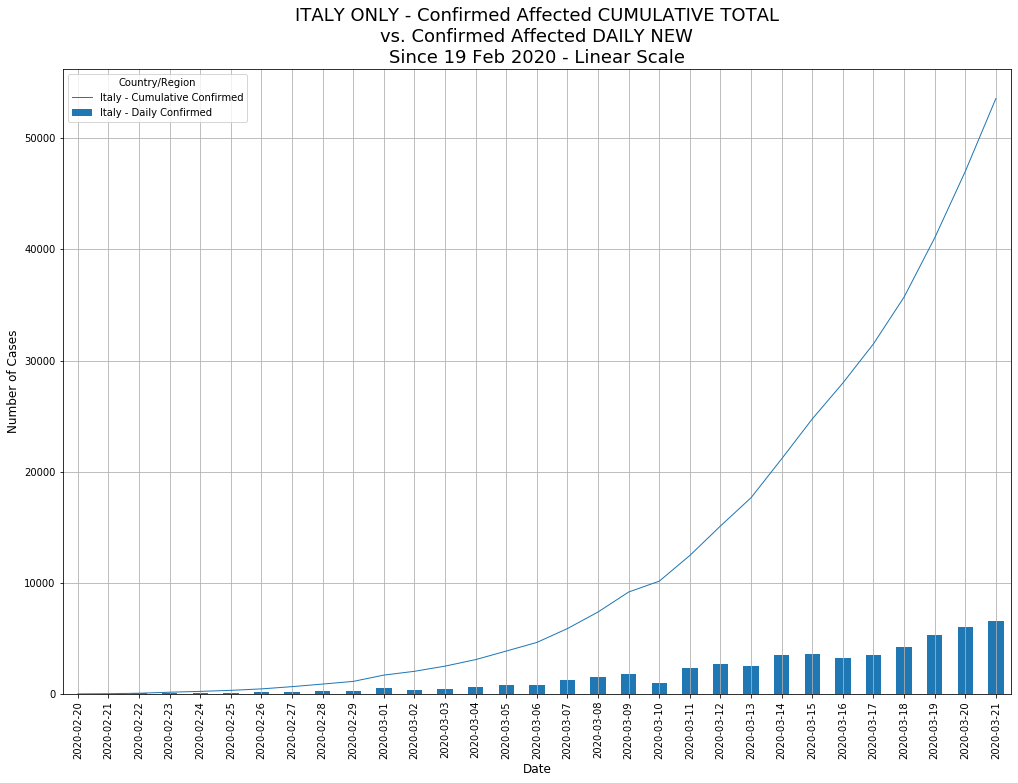

In [53]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

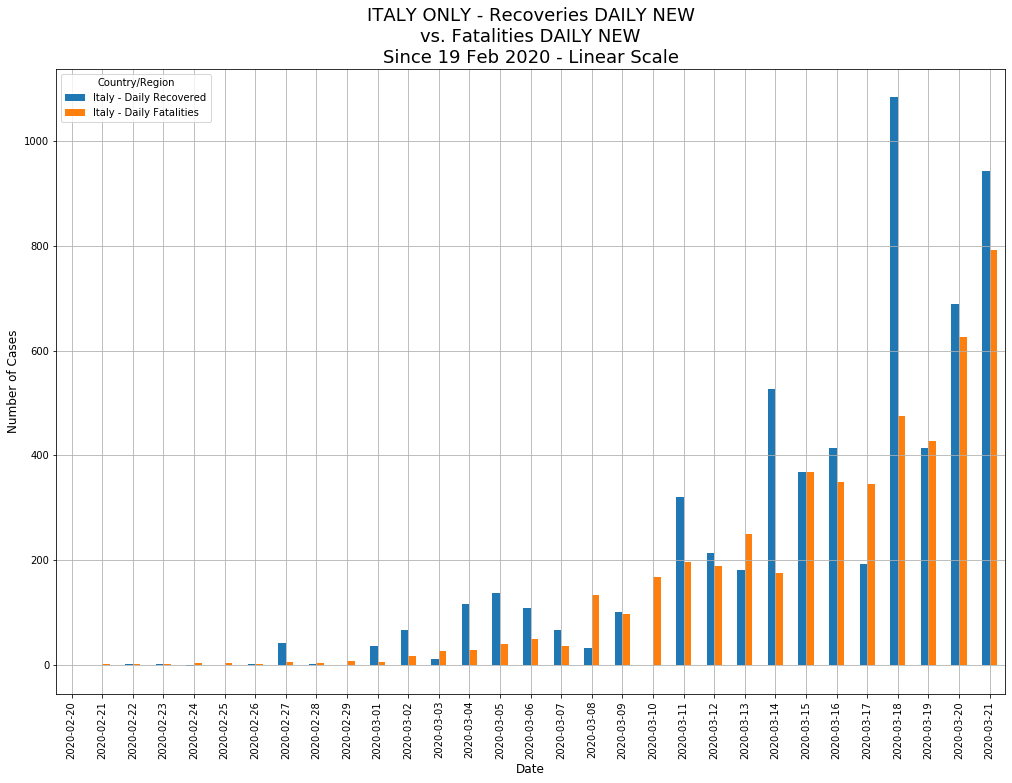

In [54]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Italy']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

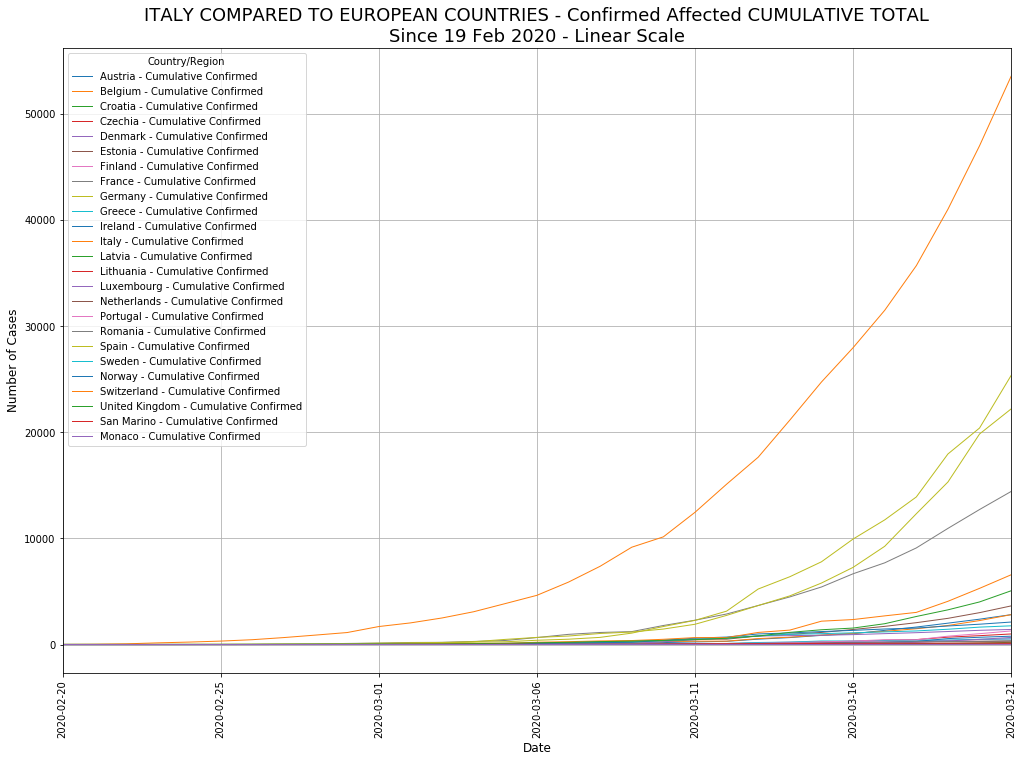

In [55]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'ITALY COMPARED TO EUROPEAN COUNTRIES - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

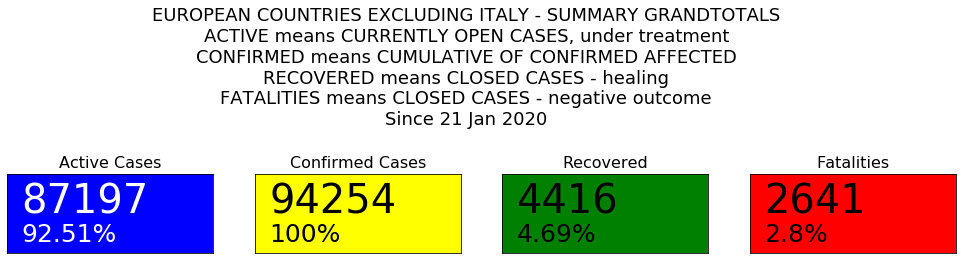

In [56]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'europe_noitaly'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

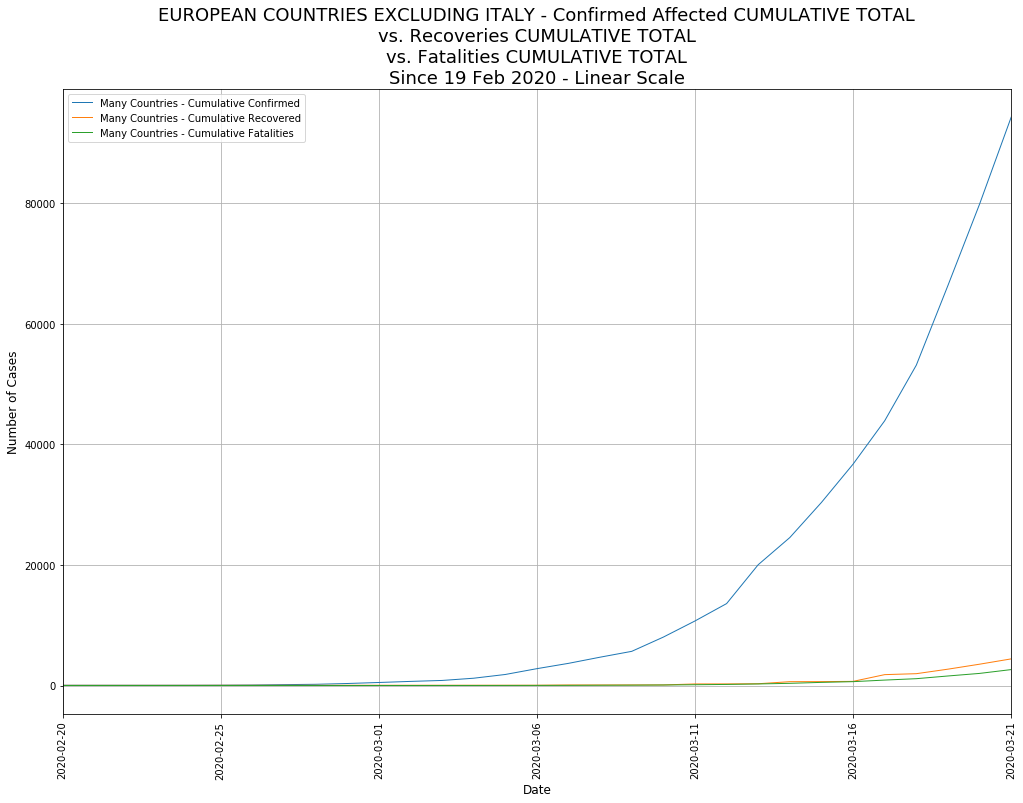

In [57]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

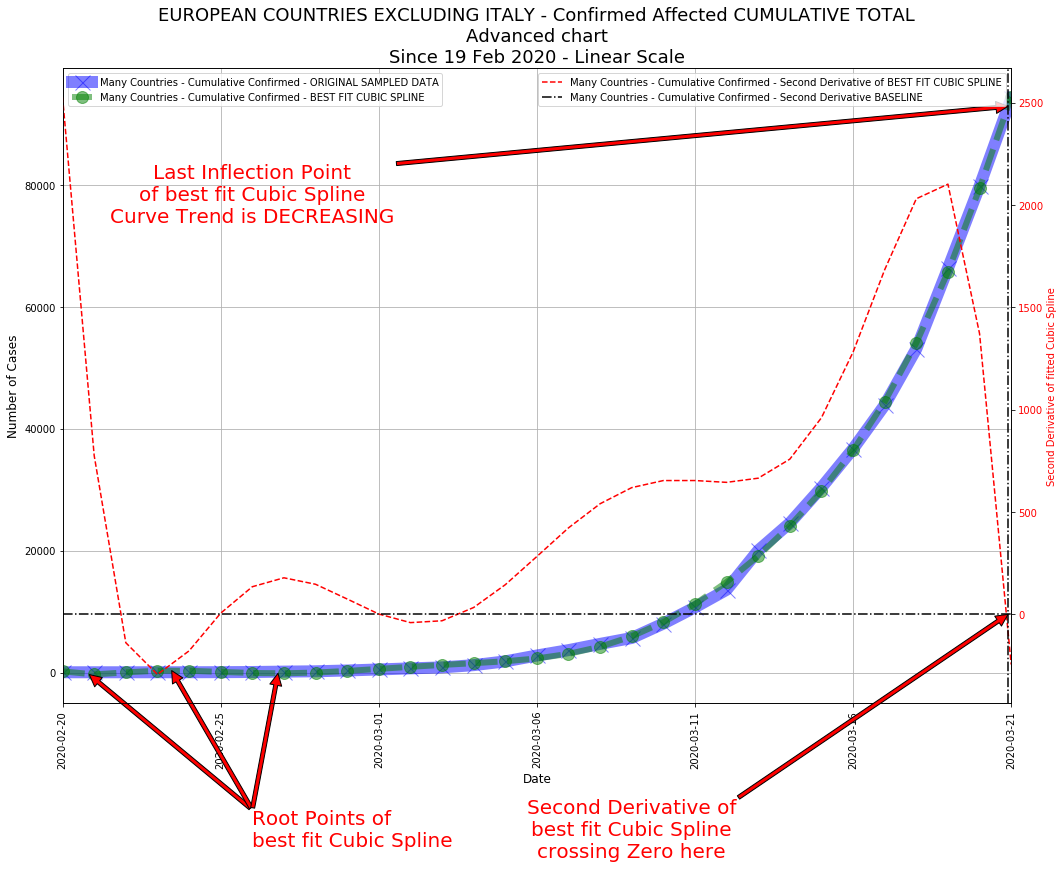

In [58]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

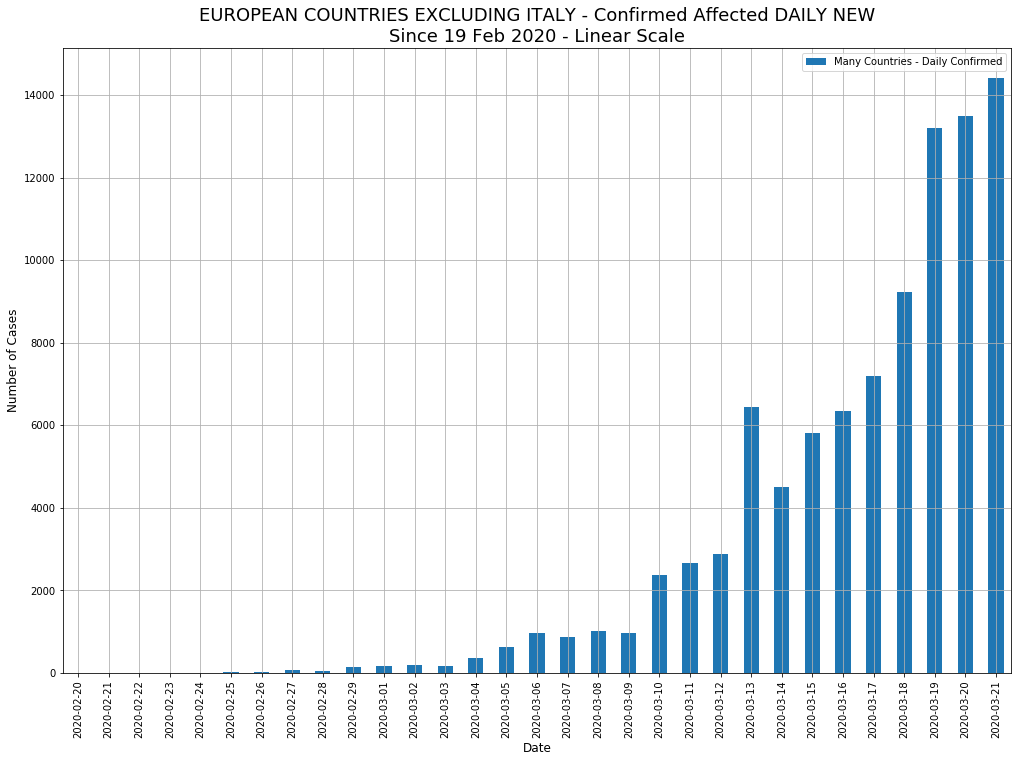

In [59]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

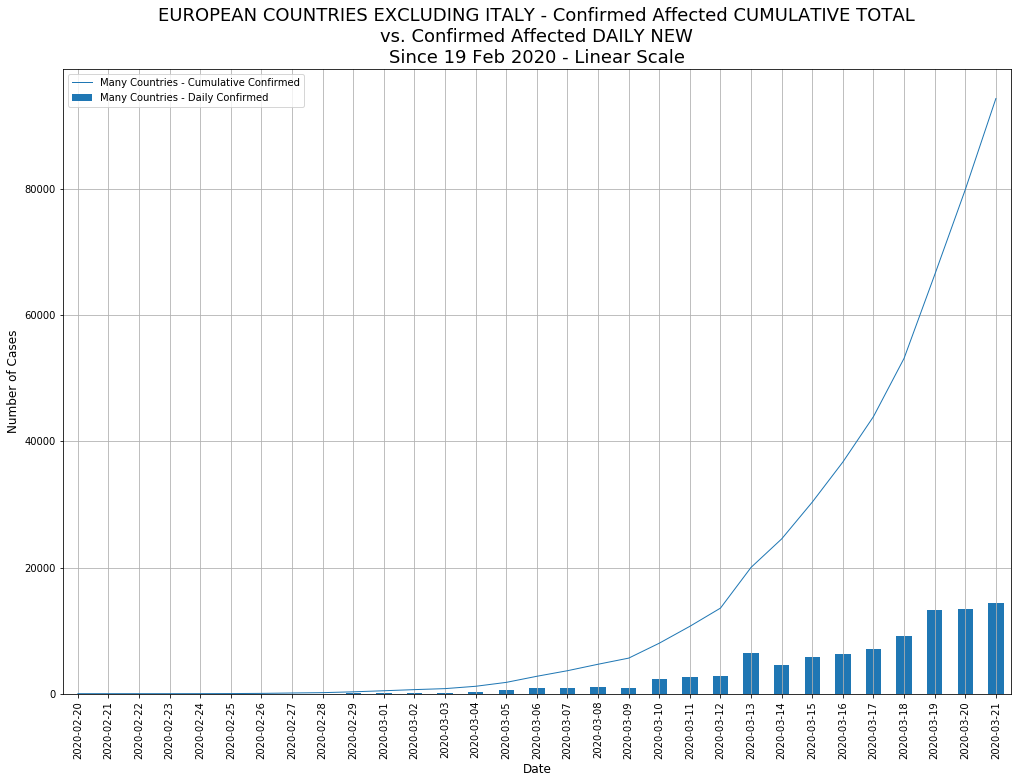

In [60]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

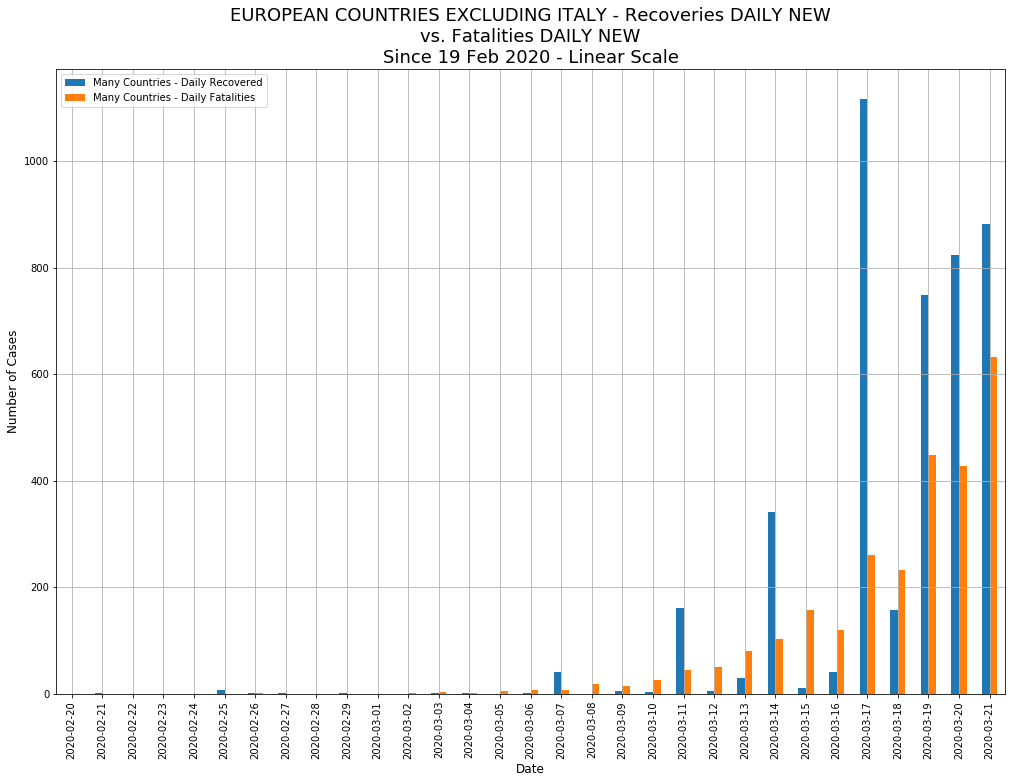

In [61]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

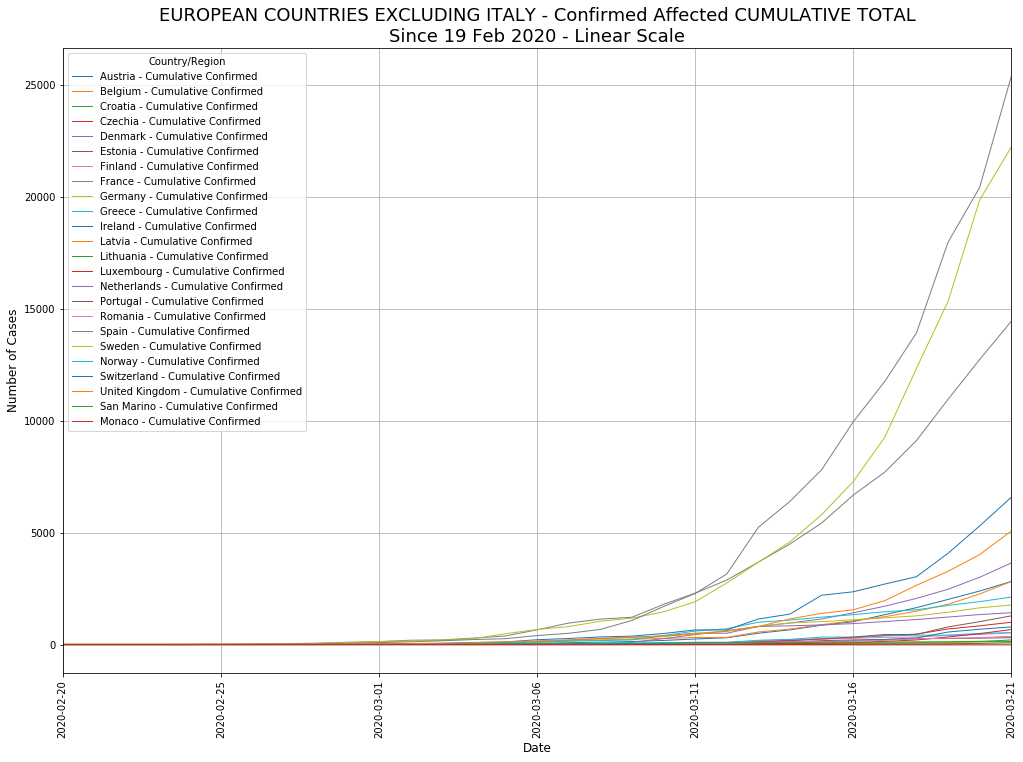

In [62]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = list_of_countries_europe_noitaly

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'EUROPEAN COUNTRIES EXCLUDING ITALY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

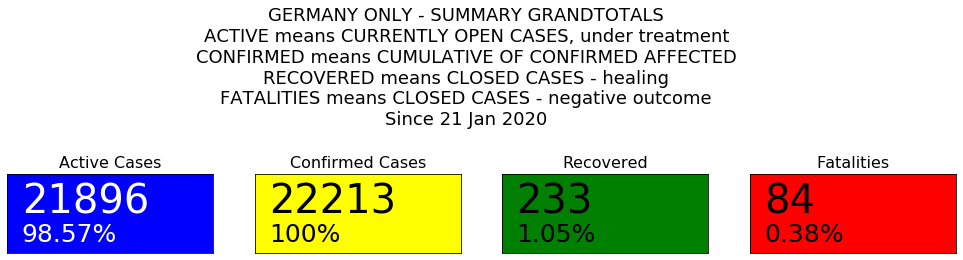

In [63]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'Germany'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'GERMANY ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

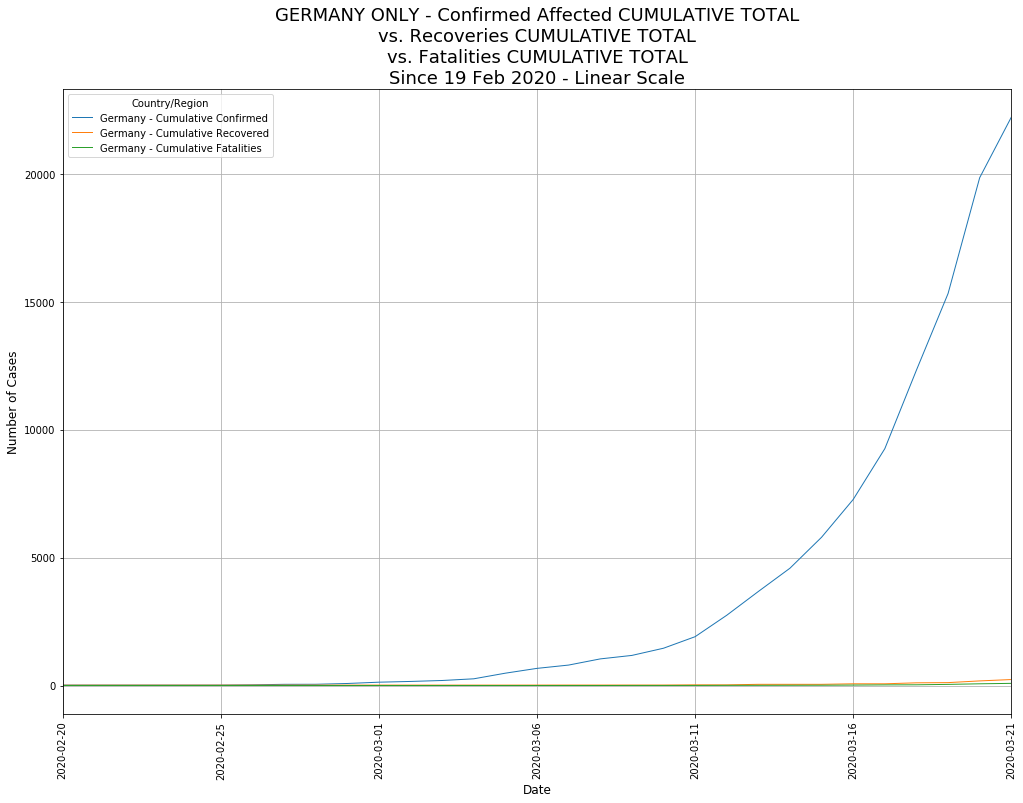

In [64]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

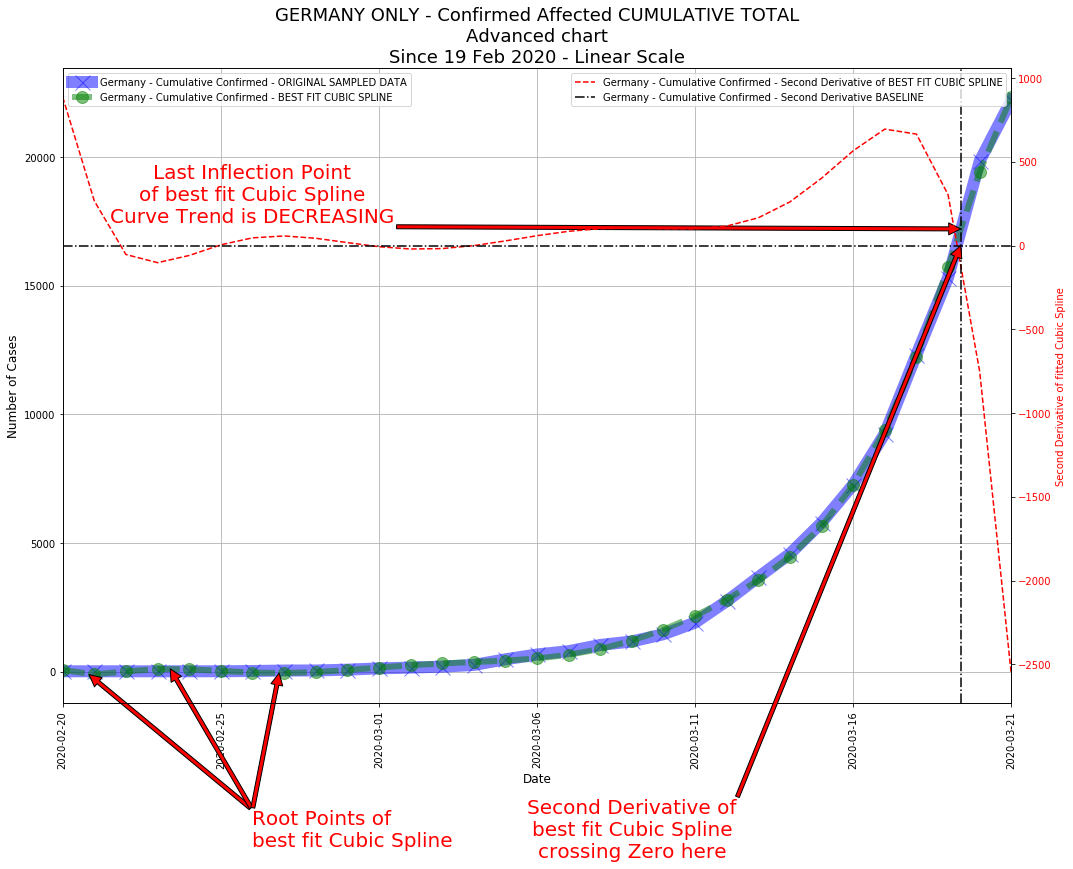

In [65]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

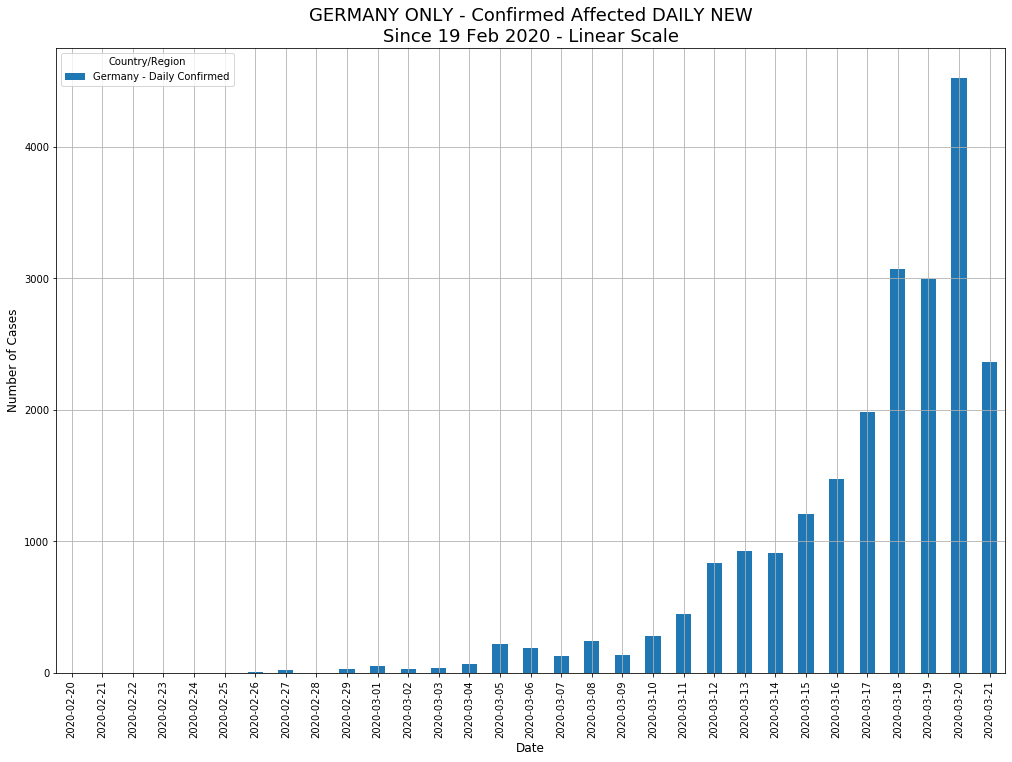

In [66]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

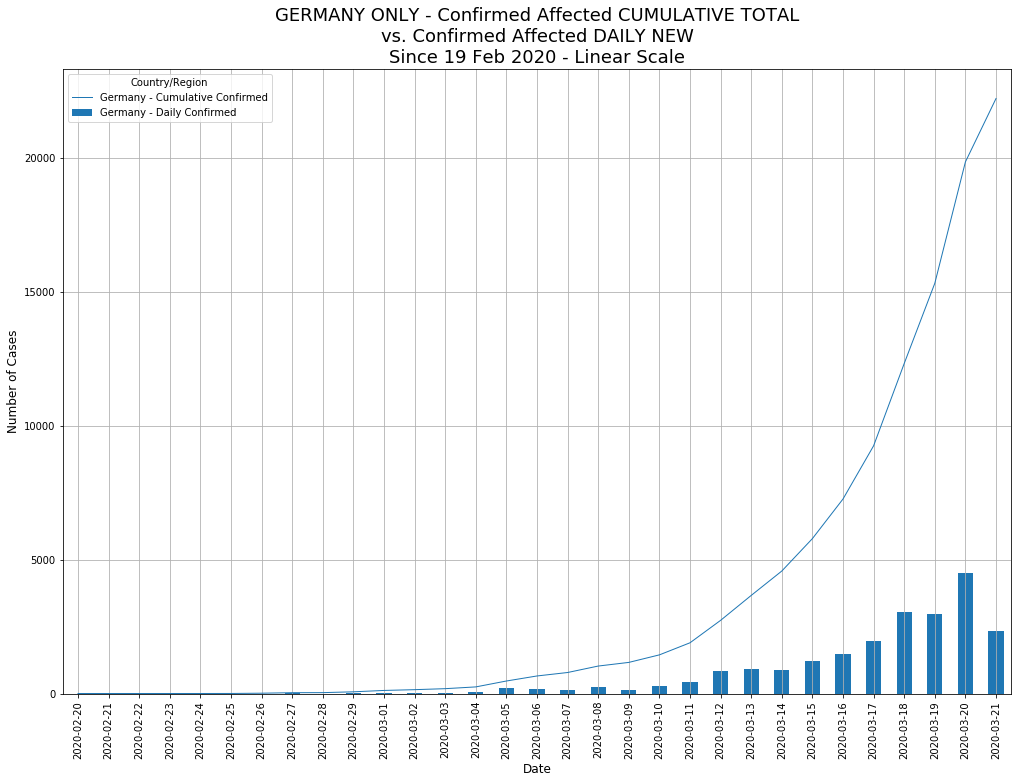

In [67]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

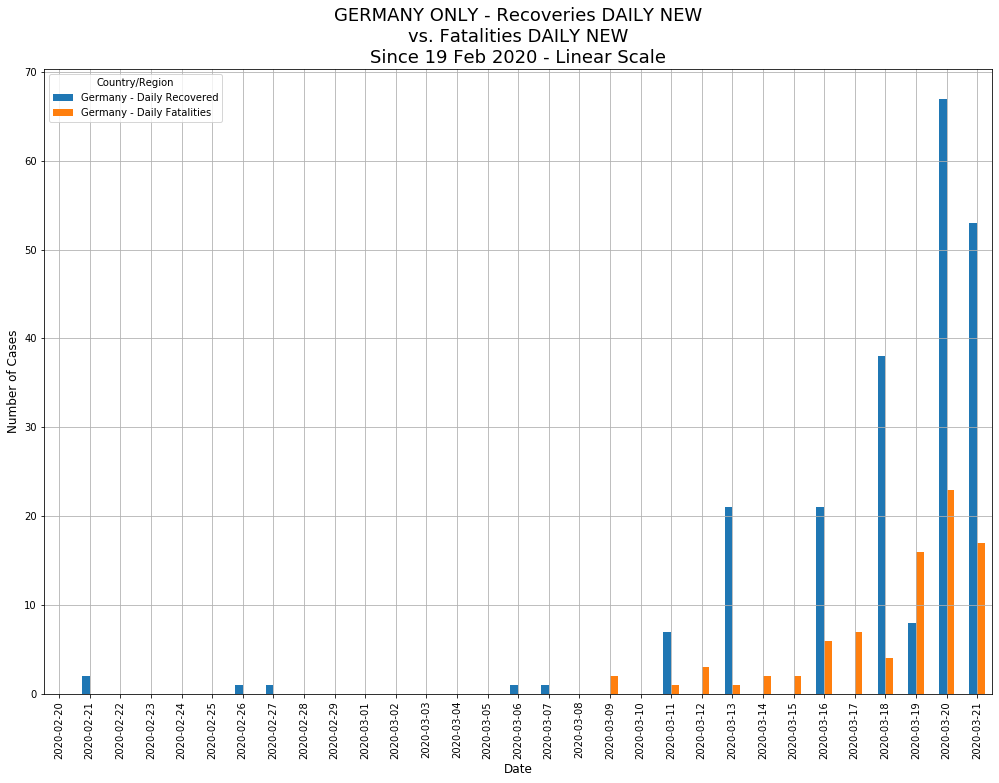

In [68]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Germany']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'GERMANY ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

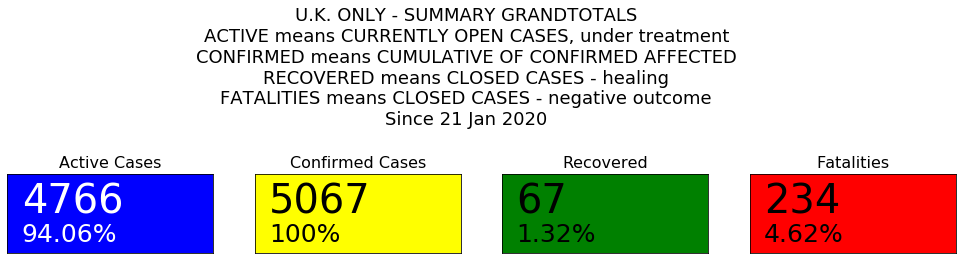

In [69]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'United Kingdom'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'U.K. ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

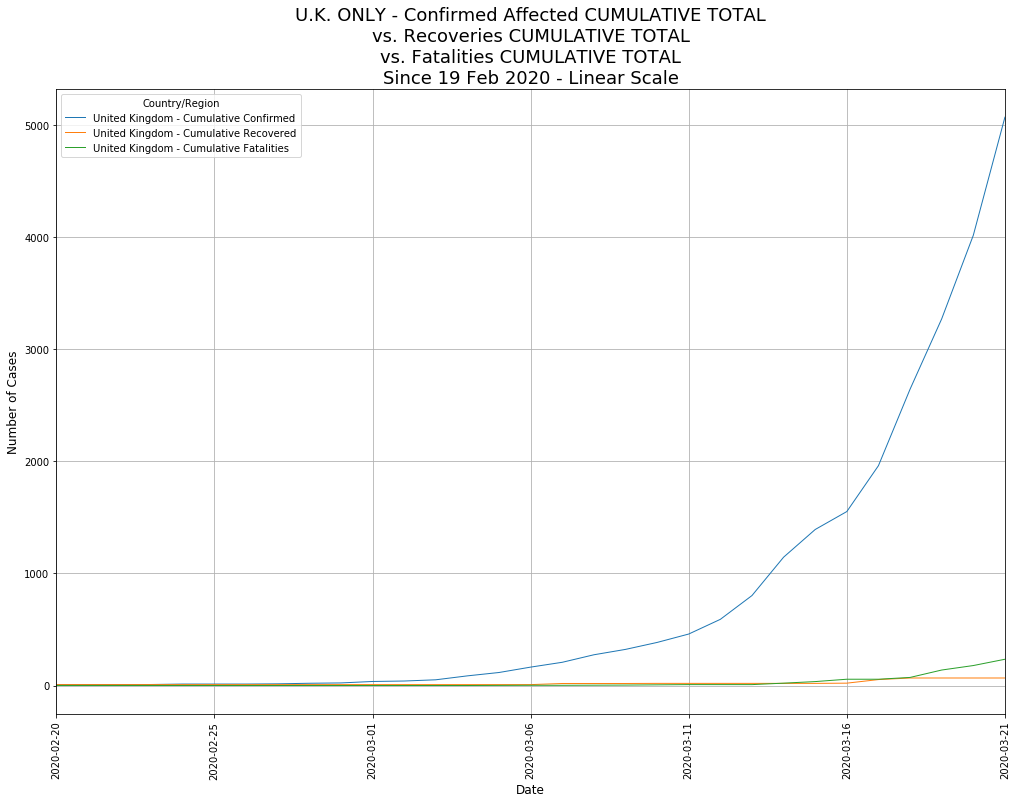

In [70]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['United Kingdom']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

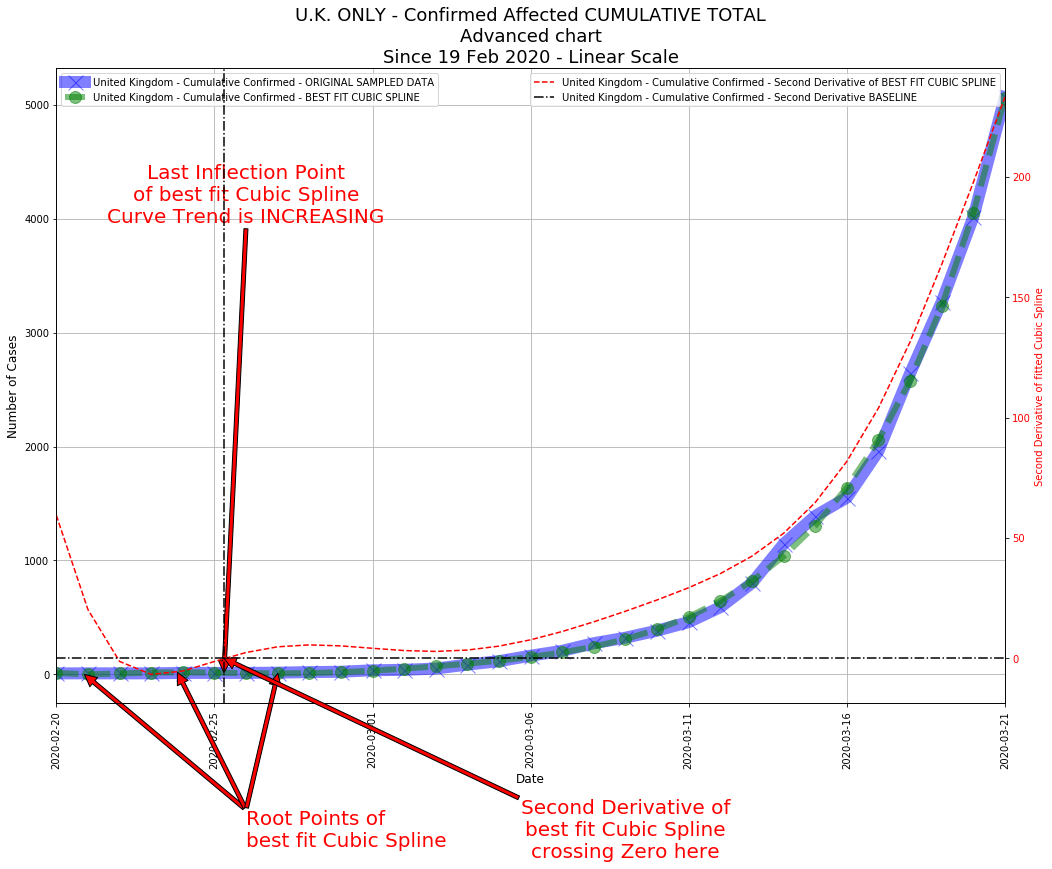

In [71]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['United Kingdom']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

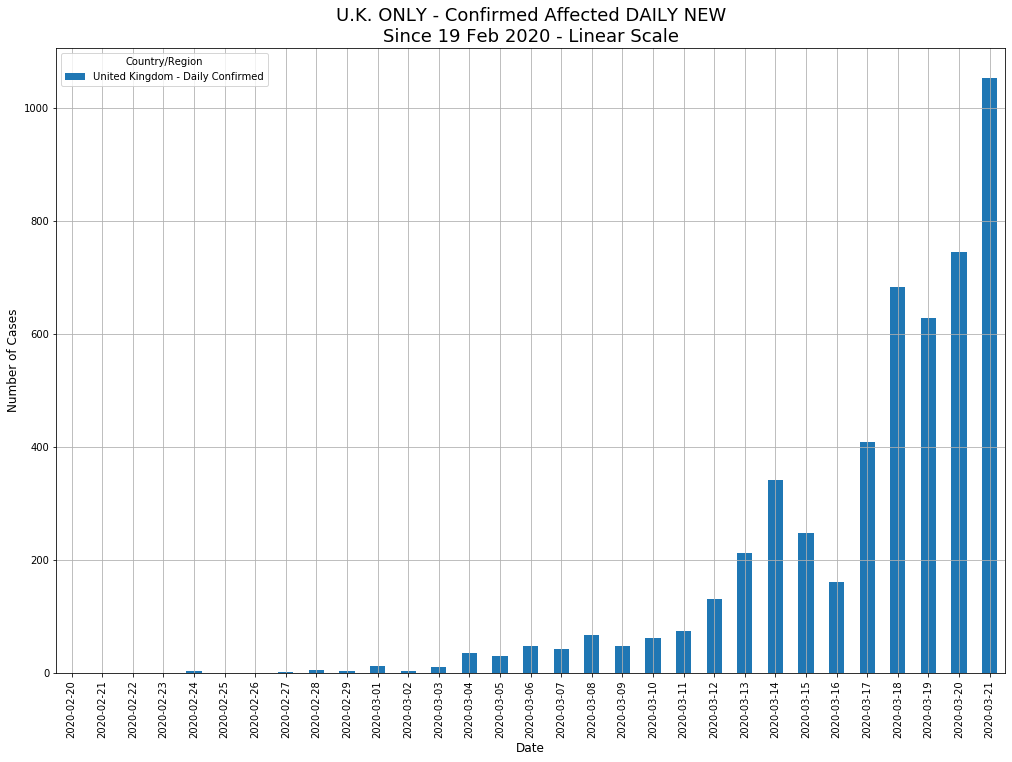

In [72]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['United Kingdom']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

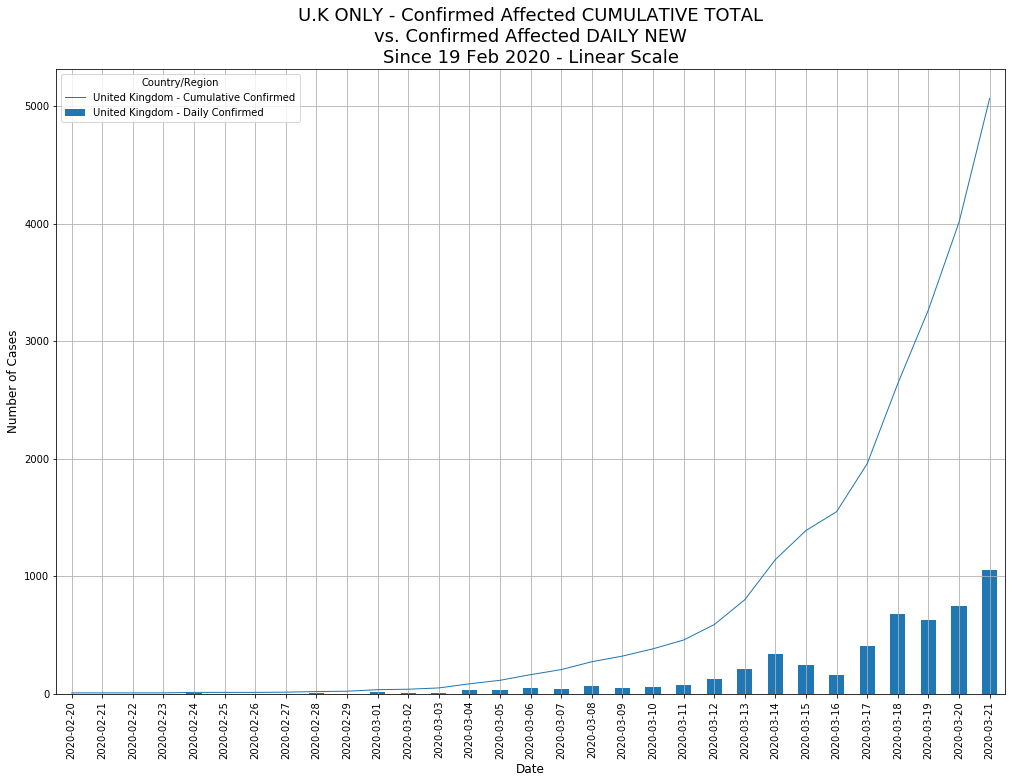

In [73]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['United Kingdom']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

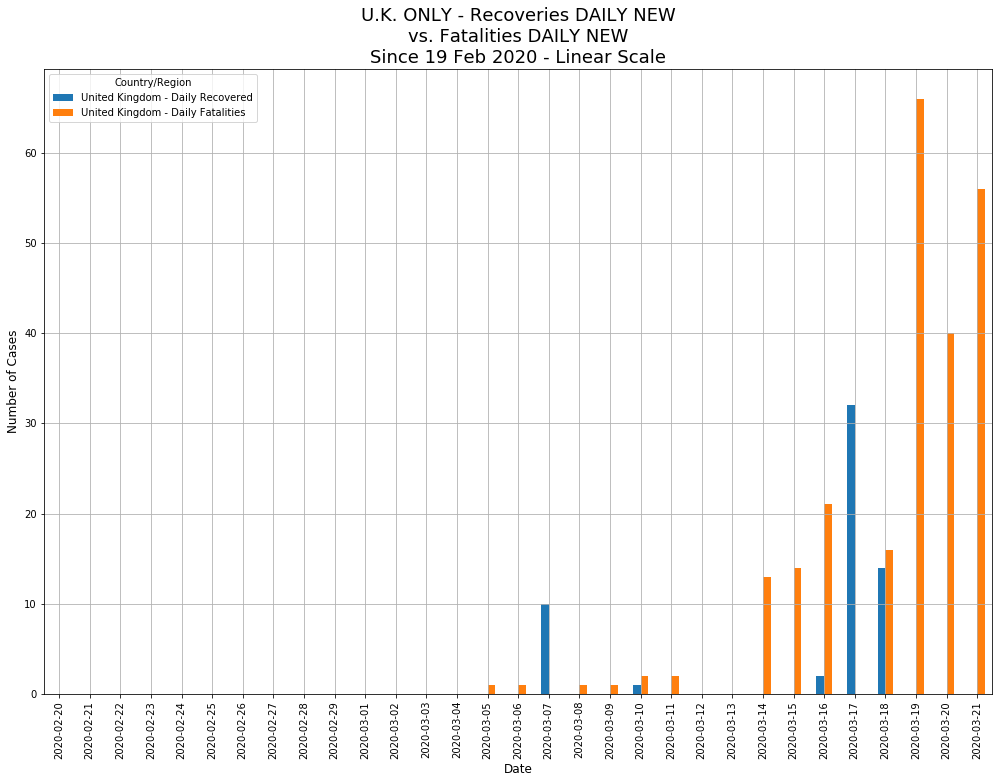

In [74]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['United Kingdom']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.K. ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

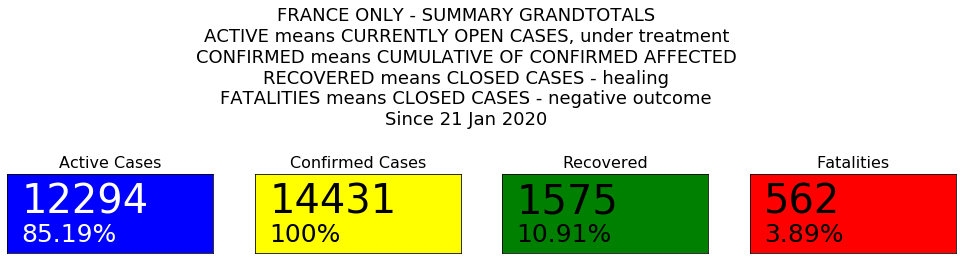

In [75]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'France'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'FRANCE ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

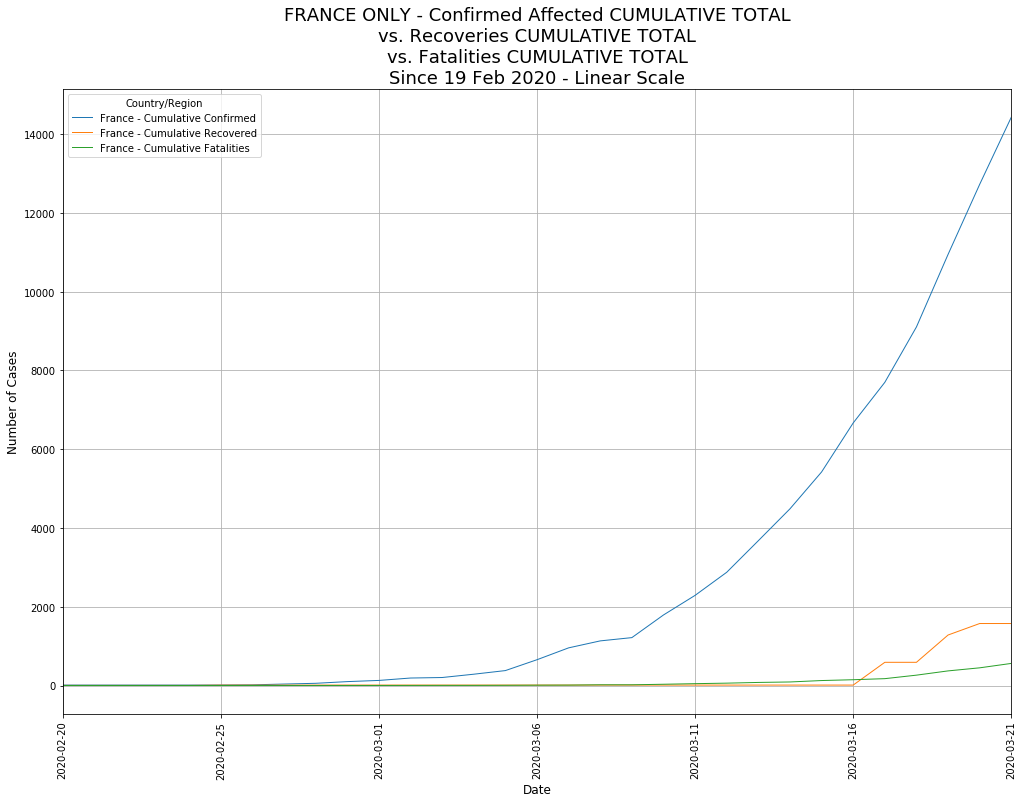

In [76]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

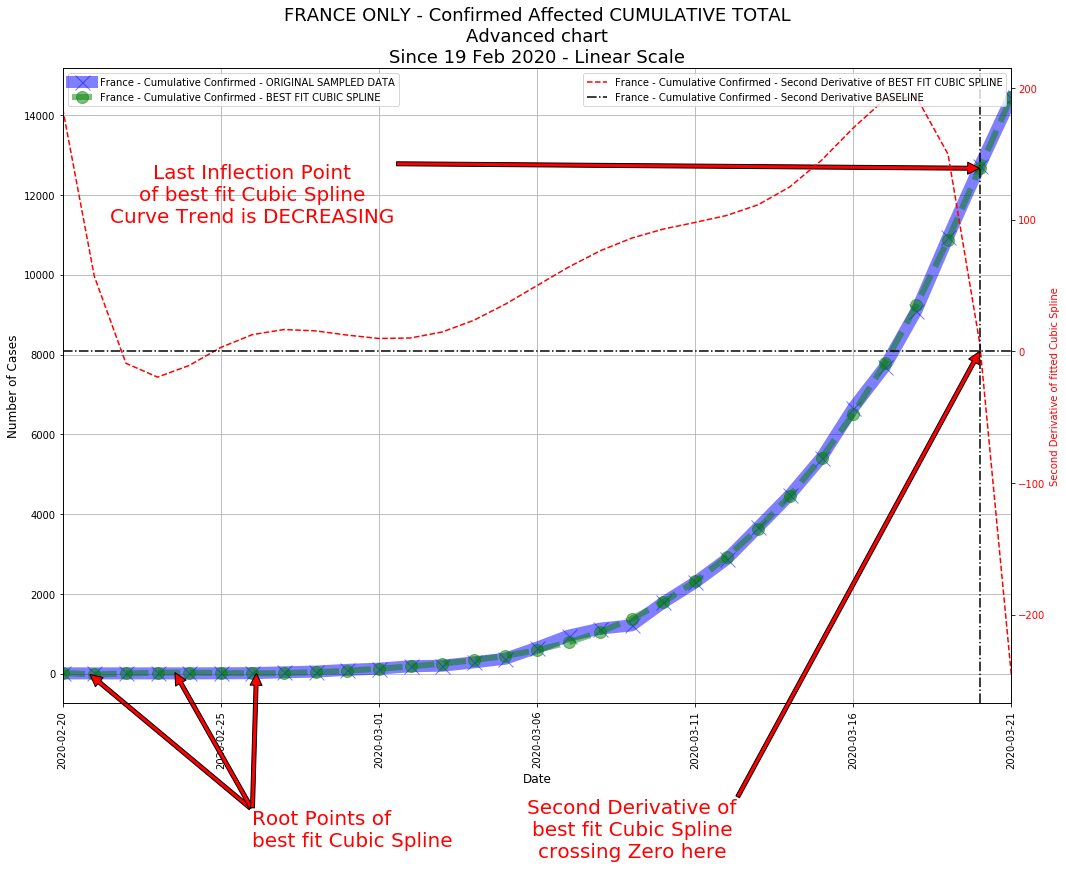

In [77]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

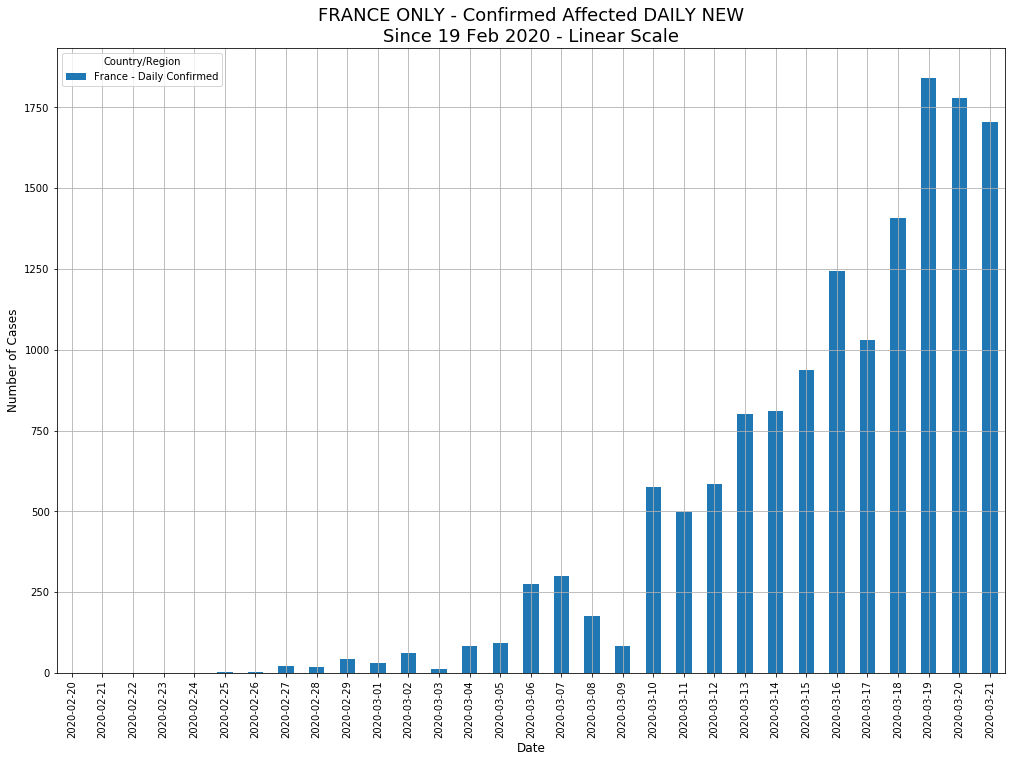

In [78]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

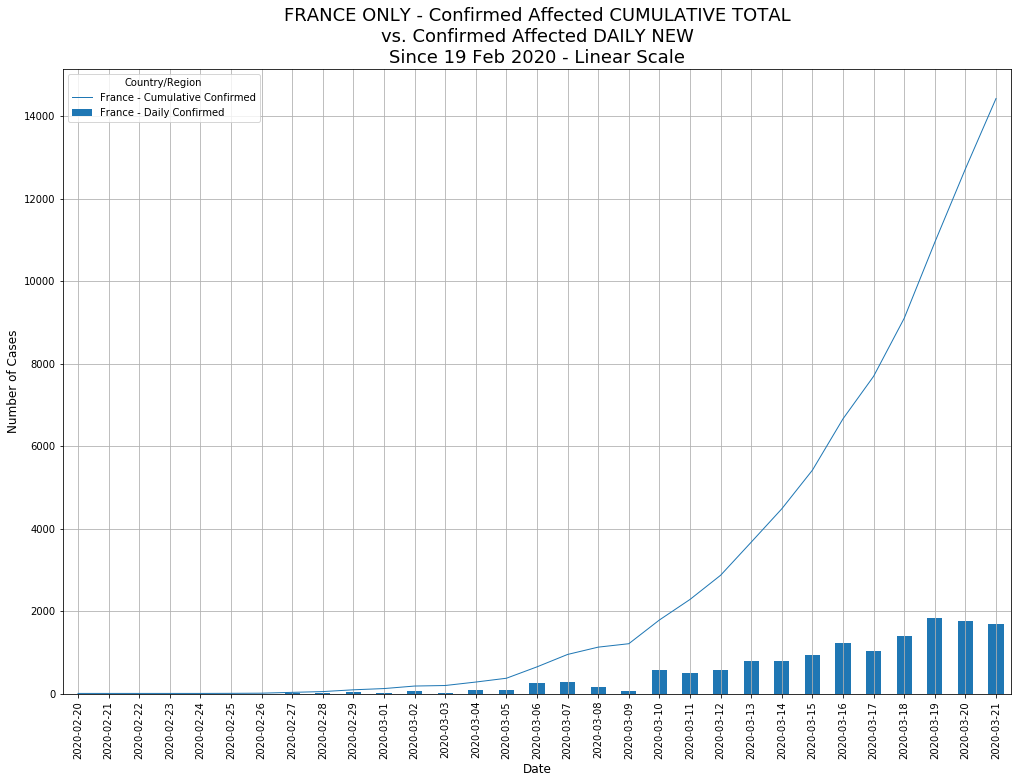

In [79]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

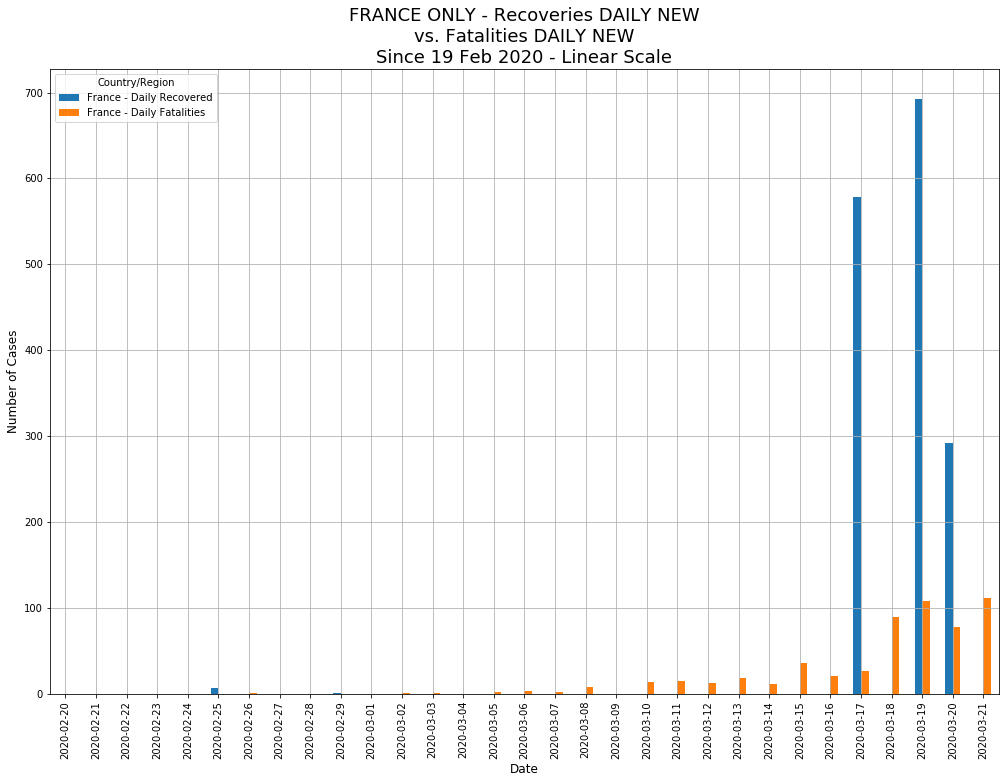

In [80]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['France']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'FRANCE ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

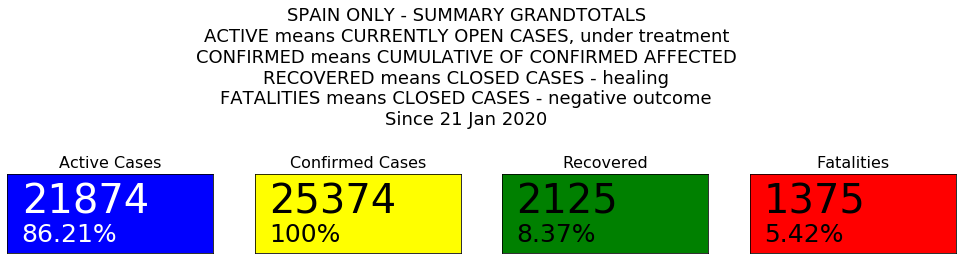

In [81]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'Spain'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'SPAIN ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

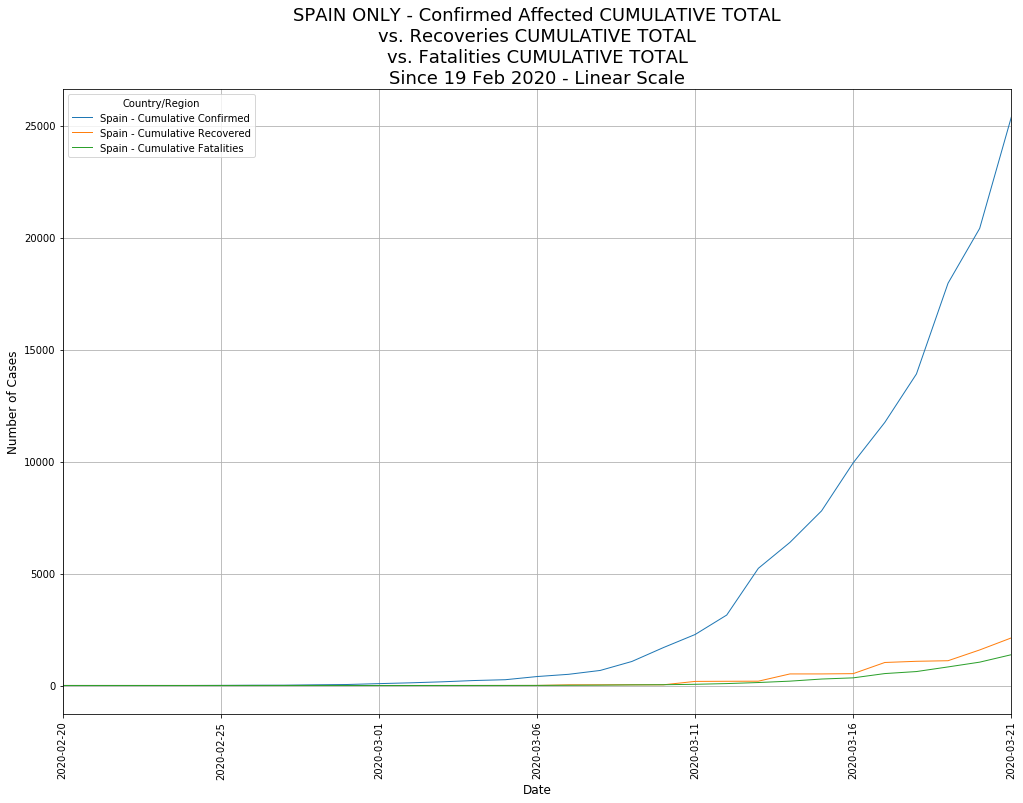

In [82]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Spain']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SPAIN ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

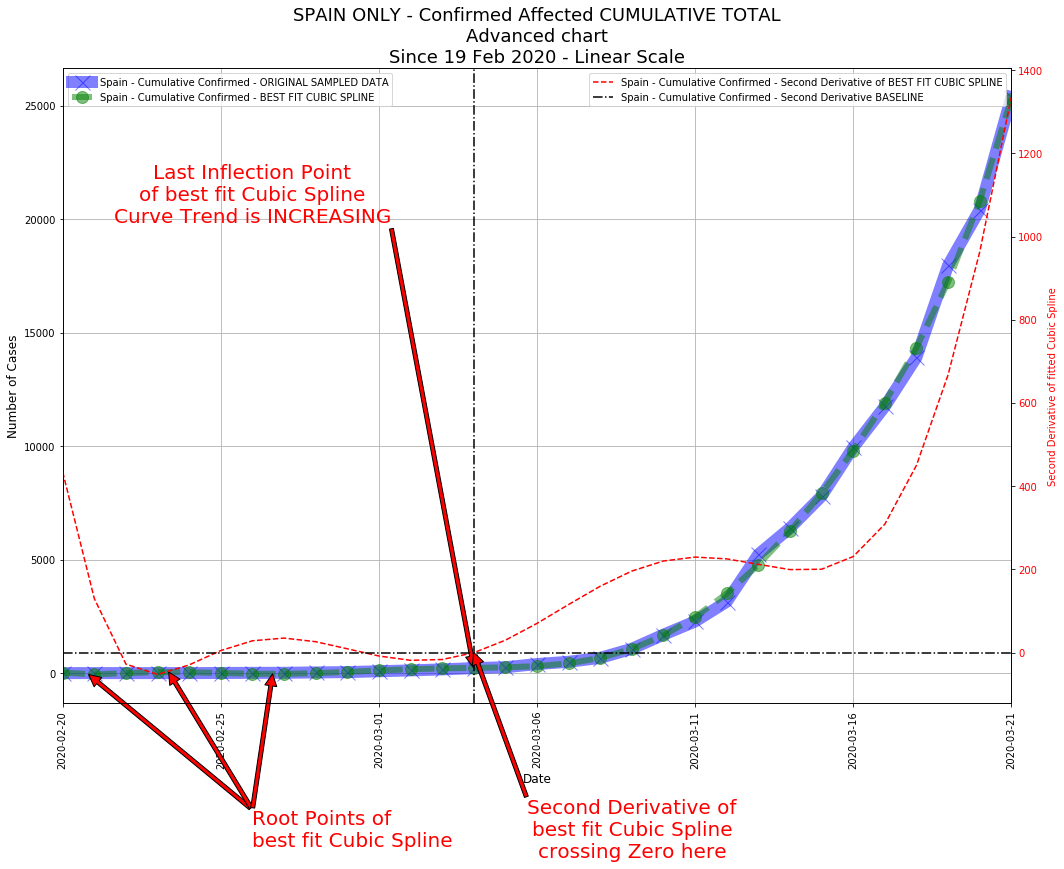

In [83]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Spain']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SPAIN ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

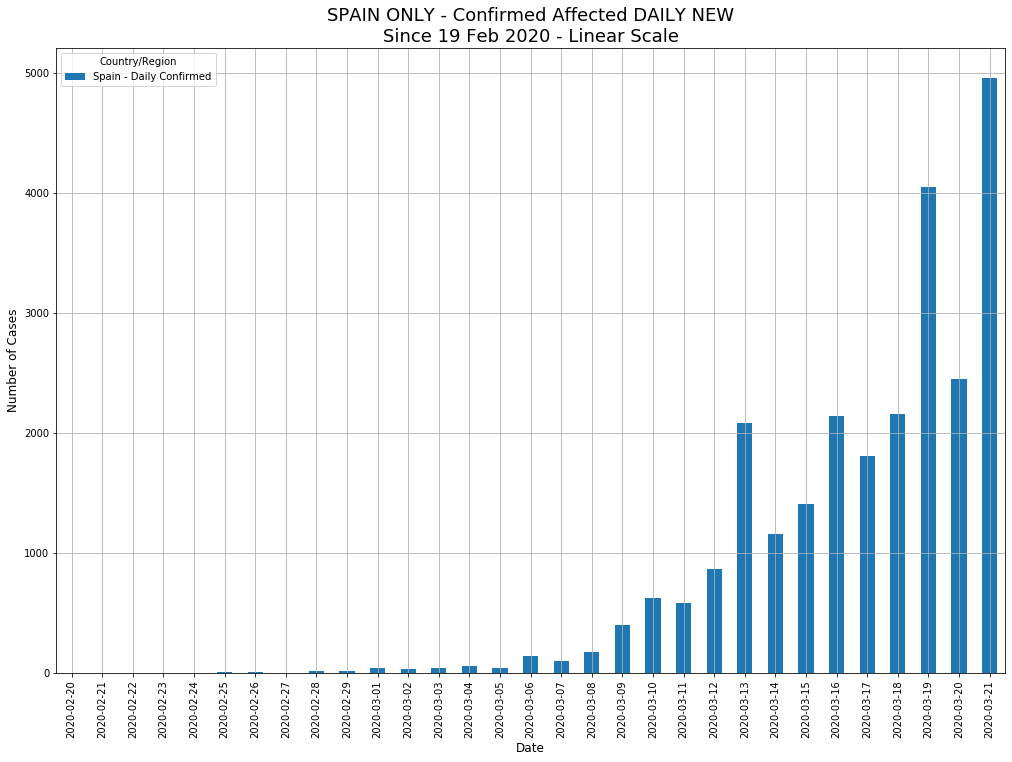

In [84]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Spain']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SPAIN ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

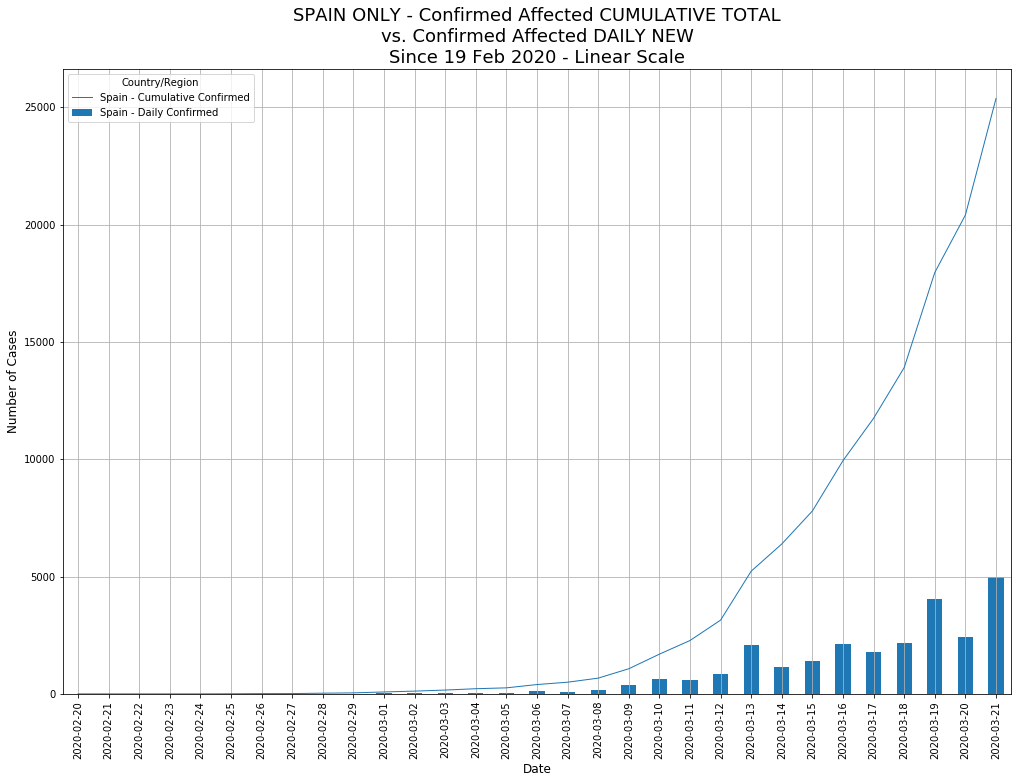

In [85]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Spain']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SPAIN ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

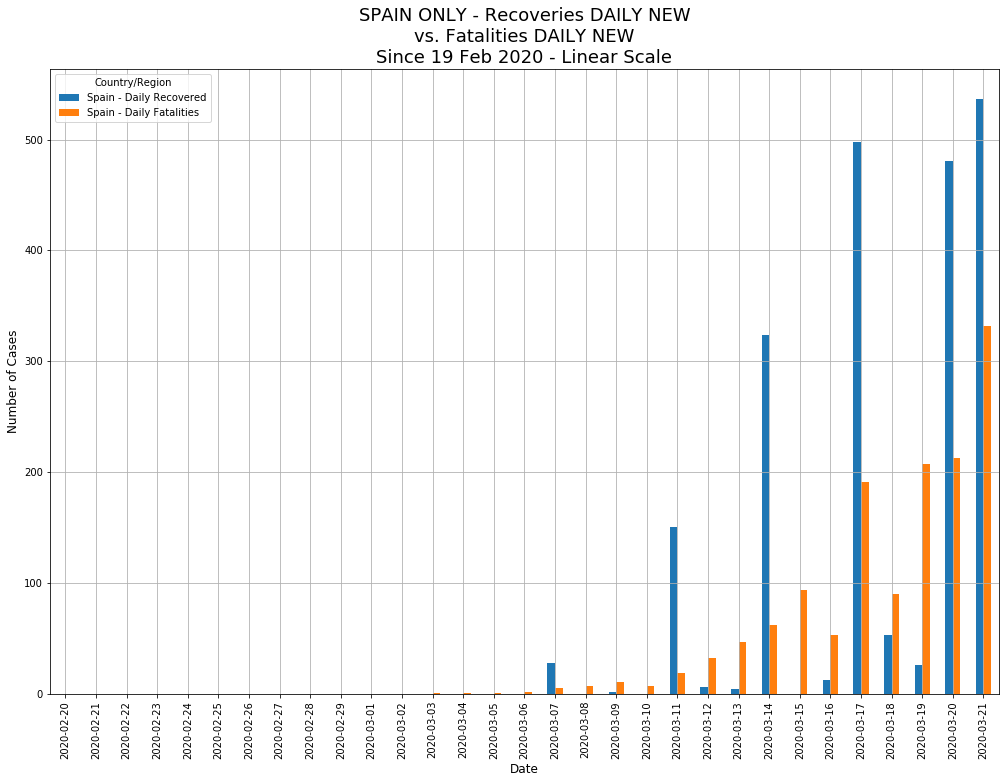

In [86]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['Spain']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'SPAIN ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

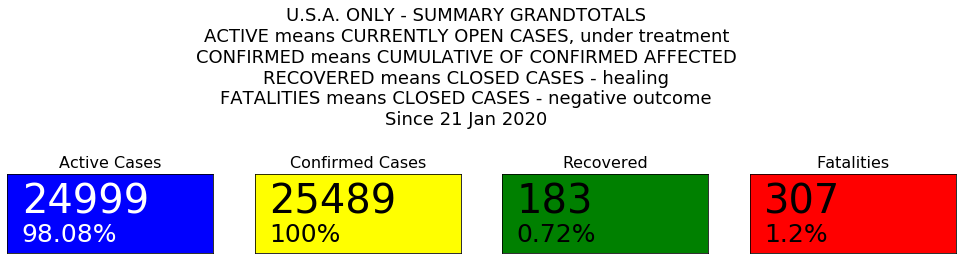

In [87]:
# LET'S PLOT THE WORLD SUMMARY AT A GLANCE
# PUTS RELEVANT VALUES TOGETHER IN LISTS HOLDING THEM ALL
summary_countries = 'US'

summary_figures = [dict_of_active_grandtotals[summary_countries], dict_of_confirmed_grandtotals[summary_countries], dict_of_recovered_grandtotals[summary_countries], dict_of_deaths_grandtotals[summary_countries]]
summary_percs = [dict_of_active_grandtotals_percs[summary_countries], 100, dict_of_recovered_grandtotals_percs[summary_countries], dict_of_deaths_grandtotals_percs[summary_countries]]

# CHOOSE SUB TITLES FOR EACH BOX
summary_subtitles = ['Active Cases', 'Confirmed Cases', 'Recovered', 'Fatalities']

# CHOOSE COLORS FOR EACH BOX
summary_colors = ['blue', 'yellow', 'green', 'red']

# CHOOSE TEXT COLORS FOR EACH BOX
summary_text_colors = ['white', 'black', 'black', 'black']

# LET'S CHOOSE A TITLE (USED TO SAVE FILE)
summary_title = 'U.S.A. ONLY - SUMMARY GRANDTOTALS' + \
                '\n' + \
                'ACTIVE means CURRENTLY OPEN CASES, under treatment' + \
                '\n' + \
                'CONFIRMED means CUMULATIVE OF CONFIRMED AFFECTED' + \
                '\n' + \
                'RECOVERED means CLOSED CASES - healing' + \
                '\n' + \
                'FATALITIES means CLOSED CASES - negative outcome' + \
                '\n' + \
                'Since 21 Jan 2020'

# LET'S PLOT!
plot_summary_headings_chart(
summary_figures,
summary_percs,
summary_subtitles,
summary_colors,
summary_text_colors,
summary_title)

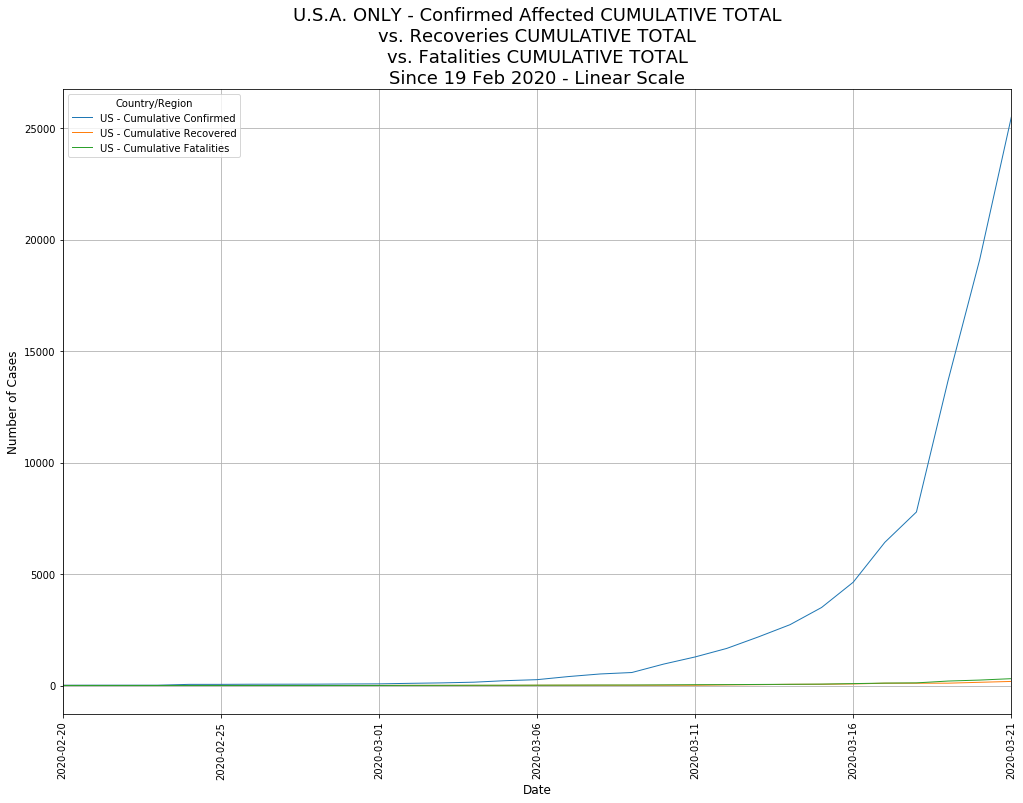

In [88]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
dict_of_dataframes['Cumulative Recovered'] = recovered_DF
dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Recoveries CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Fatalities CUMULATIVE TOTAL' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

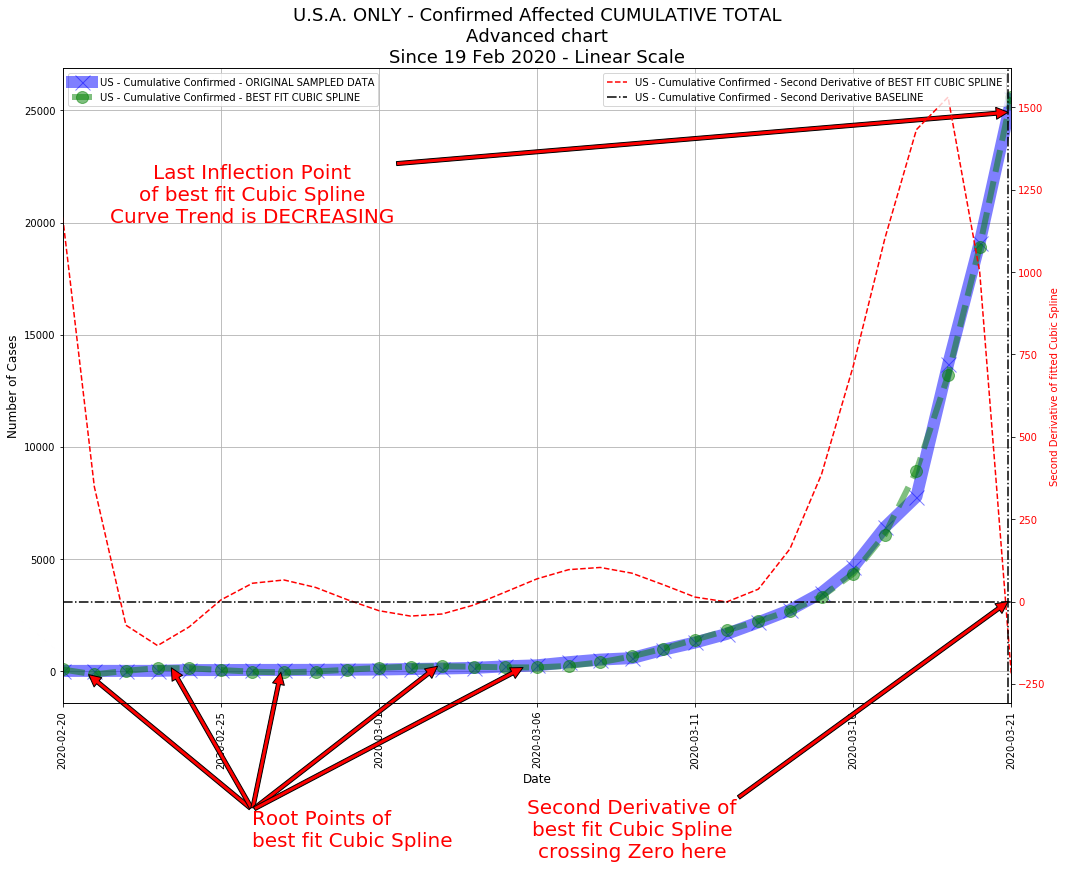

In [89]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'Advanced chart' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S INDICATE HOW MANY RECORDS WE WANT TO KEEP FROM THE TOP RANKED DOWN
# USEFUL FOR HEATMAPS. PUT ZERO FOR ALL RECORDS. DEFAULT 10
num_ranked = 10

# LET'S INDICATE IF WE WANT TO DRAW AN ADVANCED CHART E.G. WITH CUBIC POLYNOMIAL FITTING
# SECOND DERIVATIVES, INFLECTION POINTS AND ROOT POINTS. DEFAULT 'N'
flg_advanced_chart = 'Y'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date,
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries,
num_ranked,
flg_advanced_chart)

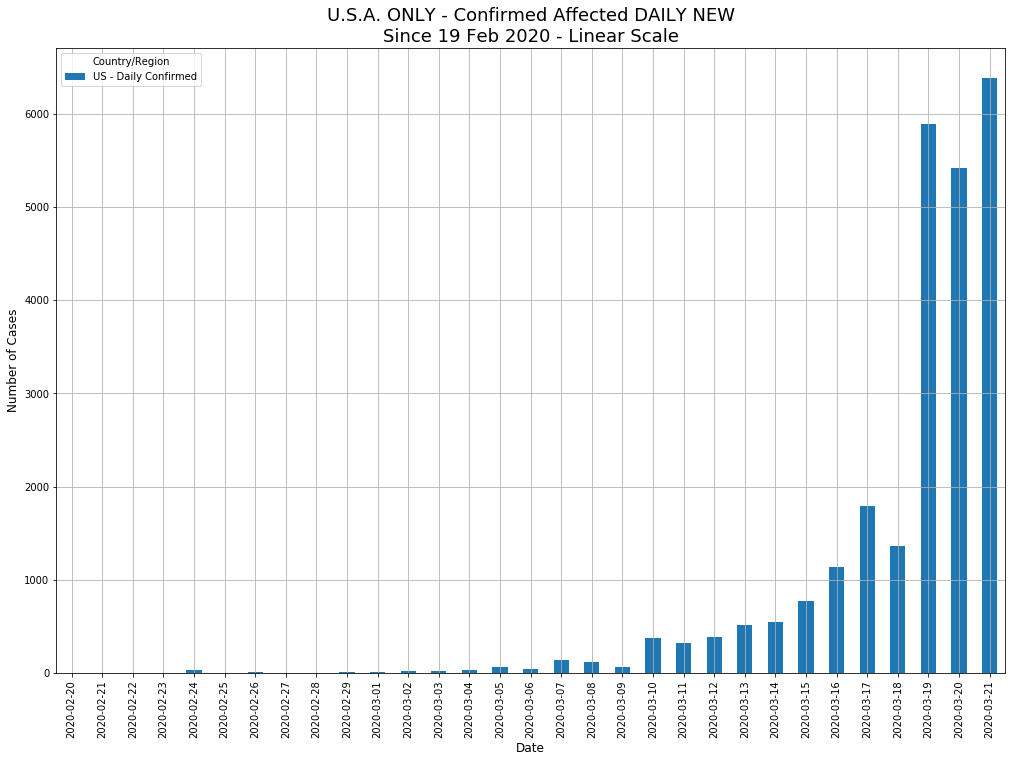

In [90]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

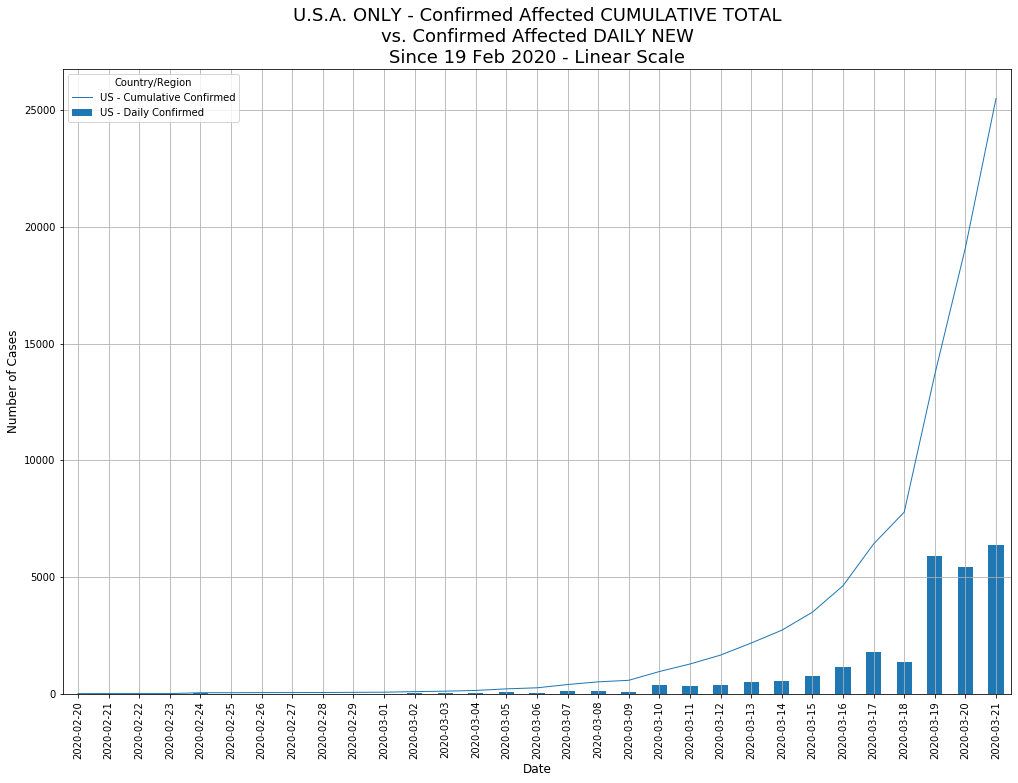

In [91]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
#dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
#dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Confirmed Affected CUMULATIVE TOTAL' + \
        '\n' + \
        'vs. Confirmed Affected DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

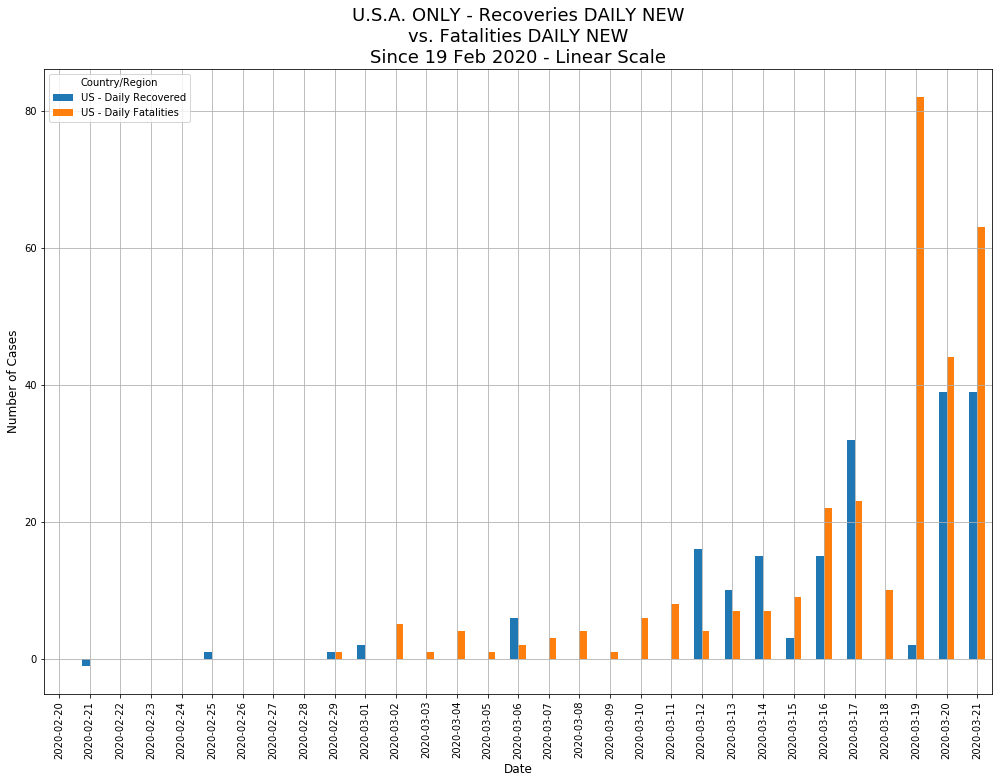

In [92]:
# LET'S PLOTS A COMPLETE CHART!
# CHOOSE DATAFRAMES OF INTEREST FOR THIS PARTICULAR CHART
# THEY WILL BE PUT IN A DICTIONARY HOLDING THEM ALL
# DICTIONARY KEYS ARE THE LEGEND ENTRIES THAT WILL BE PLOTTED
dict_of_dataframes = {}
#dict_of_dataframes['Daily Confirmed'] = reduced_confirmed_DF
dict_of_dataframes['Daily Recovered'] = reduced_recovered_DF
dict_of_dataframes['Daily Fatalities'] = reduced_deaths_DF
#dict_of_dataframes['Daily Active'] = reduced_active_DF
#dict_of_dataframes['Cumulative Confirmed'] = confirmed_DF
#dict_of_dataframes['Cumulative Recovered'] = recovered_DF
#dict_of_dataframes['Cumulative Fatalities'] = deaths_DF
#dict_of_dataframes['Cumulative Active'] = active_DF
#dict_of_dataframes['Cumulative Confirmed Shares'] = confirmed_pie_DF
#dict_of_dataframes['Cumulative Recovered Shares'] = recovered_pie_DF
#dict_of_dataframes['Cumulative Fatalities Shares'] = deaths_pie_DF

# CHOOSE A LIST OF COUNTRIES FOR THIS PARTICULAR CHART
# THE LIST CAN BE EXPLICIT OR CAN BE A REFERENCE TO THESE PREVIOUSLY INITIALIZED VARIABLES:
# - list_of_countries_world
# - list_of_countries_world_nochina
# - list_of_countries_europe
# - list_of_countries_europe_noitaly
list_of_countries = ['US']

# CHOOSE A START DATE FOR THIS PARTICULAR CHART
# FORMAT MUST MATCH 'YYYY-MM-DD'
start_date = '2020-02-19'

# CHOOSE A TITLE FOR THIS THIS PARTICULAR CHART
title = 'U.S.A. ONLY - Recoveries DAILY NEW' + \
        '\n' + \
        'vs. Fatalities DAILY NEW' + \
        '\n' + \
        'Since 19 Feb 2020 - Linear Scale'

# CHOOSE A SCALE TYPE FOR THIS THIS PARTICULAR CHART
# VALID VALUES ARE 'plain' OR 'log'
scale_type = 'plain'

# CHOOSE WHETHER YOU WANT TO TOTALIZE DATA ACROSS MULTIPLE NATIONS IN THE SPECIFIED LIST
# OR IF YOU WANT SEPARATE CHARTS FOR EACH NATION
# VALID VALUES ARE 'Y' OR 'N'
flg_totalize_countries = 'N'

# LET'S PLOT!
plot_complete_chart(
list_of_countries,
start_date, 
title,
scale_type,
dict_of_dataframes,
dict_of_charttypes,
flg_totalize_countries)

In [93]:
# GENERATES "index.html" PAGE IN "./charts" TO SHOW SAVED CHARTS ON BROWSER

now = datetime.now()
last_updated = now.strftime("%d %b, %Y - %H:%M:%S")
os.chdir('charts')

html_str = """<!DOCTYPE html>
<html>
<head>
  <meta charset='UTF-8'>
  <title>COVID-19 Charts</title>
</head>
<body>
<font face='Impact' size='3' color='black'>
<h1>COVID-19 Charts - Last updated """ + last_updated + """ (CET)</h1>
</font>
<p>
<b>Data Source Reference:</b><br>
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE:
<br>
<a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>
</p>
<p>
<b>Terms of use:</b><br>
Please see the Terms of Use extensively described at the above link for reference
</p>
<p>
<b>Disclaimer:</b><br>
This Website, the related GitHub repo and its contents, including all data, mapping, and analysis is provided to the public strictly for educational and academic research purposes. It is hereby disclaimed any and all representations and warranties with respect to the Website and related Git Repo, including accuracy, fitness for use, and merchantability. Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.
</p>
<p>
<b>GitHub Repository:</b><br>
Please visit the GitHub Repository containing the full source code (Jupyter Notebook) used to generate the charts:
<br>
<a href='https://github.com/r-lomba/covid-19-charts'>https://github.com/r-lomba/covid-19-charts</a>
</p>
<p>
<b>Contacts:</b><br>
You can contact me here:
<br>
<a href='mailto:r.lombardelli@digitalgarage.it'>r.lombardelli@digitalgarage.it</a>
</p>
<hr>
<font face='Impact' size='3' color='black'>
<h1 align='center'>The World at a glance - Grandtotals Summary - """ + last_updated + """ (CET)</h1>
</font>
<table border=0>"""

i = 0

for file in sorted(filter(os.path.isfile, os.listdir('.')), key=os.path.getmtime):
    filename = os.fsdecode(file)
    if filename.endswith('.png'): 
        html_str = html_str + "<tr><p><br><br><br></p></tr>" # EMPTY LINE TO CREATE SPACE BETWEEN SINGLE CHARTS
        html_str = html_str + "<tr><img src='" + filename.replace(' ', '%20') + "'></tr>"
        
        if (i == 0): # COMMENTS TO THE SUMMARY CHART
            i = 1
            html_str += "<tr bgcolor='cyan'><br><br><br><br><font face='Arial' size='3' color='black'><h3 aligh='center'>Highlight of the chart just below: It's interesting to notice that Recoveries surpassed Active Cases at the beginning of March. Active Cases rising again in number since 5th of March, though</b></h3></font><br></tr>"

html_str += "</table></body></html>"

Html_file= open('./index.html','w')
Html_file.write(html_str)
Html_file.close()

os.chdir('..')